In [39]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
from scipy import stats

import os

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [4]:
# Functions

def return_missing_values_df_bar(df, bars=True):

    """Displays nans in percent"""

    missing_percent_df = \
        pd.DataFrame(100 - (df.count()/df.shape[0])*100,
                     columns=['Missing Values'])

    if bars:
        return missing_percent_df[missing_percent_df['Missing Values'] > 0]\
                                 .style.bar(color=sns.color_palette('mako_r')
                                            .as_hex()[3])
    else:
        return missing_percent_df[missing_percent_df['Missing Values'] > 0]
    
    
# Cleaning 

def organization_type_semantic_cleaning(value):
    
    trade_type_x = ['Trade: type 3',
                    'Trade: type 2',
                    'Trade: type 1',
                    'Trade: type 4',
                    'Trade: type 5',
                    'Trade: type 6']

    industry_type_x = [
                    'Industry: type 9',
                    'Industry: type 3',
                    'Industry: type 11',
                    'Industry: type 7',
                    'Industry: type 1',
                    'Industry: type 4',
                    'Industry: type 5',
                    'Industry: type 2',
                    'Industry: type 12',
                    'Industry: type 6',
                    'Industry: type 10',
                    'Industry: type 13',
                    'Industry: type 8']

    transport_type_x = [
                    'Transport: type 2',
                    'Transport: type 3',
                    'Transport: type 1',
                    'Transport: type 4' # Added for scale
    ]

    public_type = [
                    'Security',
                    'Military',
                    'Police',
                    'Security Ministries',
                    'Emergency',
                    'Postal']

    other_second = [
                    'Housing',
                    'Bank',
                    'Agriculture',
                    'Restaurant',
                    'Services',
                    'University',
                    'Hotel',
                    'Electricity',
                    'Insurance',
                    'Telecom',
                    'Advertising',
                    'Realtor',
                    'Culture',
                    'Mobile',
                    'Legal Services',
                    'Cleaning',
                    'Religion',]
    
    if value in trade_type_x:
        return 'trade_type_x'
    
    elif value in industry_type_x:
        return 'industry_type_x'
    
    elif value in transport_type_x:
        return 'transport_type_x'
    
    elif value in public_type:
        return 'public_type'
    
    elif value in other_second:
        return 'other_second'
    
    return value

# Kernel Kaggle's Functions 
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bb, nan_as_category = True):
    bureau = bureau
    bb = bb
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(previous_application, nan_as_category = True):
    prev = previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(POS_CASH_balance, nan_as_category = True):
    pos = POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments_function(installments_payments, nan_as_category = True):
    ins = installments_payments
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance_function(credit_card_balance, nan_as_category = True):
    cc = credit_card_balance
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    return cc_agg

<h6>Set Ups

In [5]:
# Imports HomeCredit_columns_description.csv

columns_description_df = \
    pd.read_csv(r'E:\Data\Projet 7\HomeCredit_columns_description.csv', encoding='latin1')

# Imports application_train.csv

application_train = pd.read_csv(r'E:\Data\Projet 7\application_train.csv')

# Imports bureau.csv

bureau = pd.read_csv(r'E:\Data\Projet 7\bureau.csv')

# Imports bureau_balance.csv

bureau_balance = pd.read_csv(r'E:\Data\Projet 7\bureau_balance.csv')

# Imports previous_application.csv

previous_application = pd.read_csv(r'E:\Data\Projet 7\previous_application.csv')

# Imports POS_CASH_balance

POS_CASH_balance = pd.read_csv(r'E:\Data\Projet 7\POS_CASH_balance.csv')

# Imports installments_payments

installments_payments = pd.read_csv(r'E:\Data\Projet 7\installments_payments.csv')

# Imports credit_card_balance

credit_card_balance = pd.read_csv(r'E:\Data\Projet 7\credit_card_balance.csv')

# Sets up a random seed

random_seed = 34
np.random.seed(random_seed)

<img src="./home_credit.png">

<h1>Ad hoc & Kernel Cleanings

<h3>Application_train

In [6]:
# Displays head

application_train.head(3)

# Displays shape

application_train.shape

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  

[3 rows x 122 columns]

(307511, 122)

In [7]:
# Retrieves columns informations of application_train from columns_description_df

application_train_column_df = \
    columns_description_df[columns_description_df['Table'] == 
                           'application_{train|test}.csv'].copy()

# 73 unique descriptions / 122 columns

application_train_column_df['Description'].nunique()

# (47 occurences)

most_recurrent_description = \
    application_train_column_df['Description'].value_counts().index[0]

most_recurrent_description

# Retrieves the name of the columns on the current building where the client live

current_building_columns = \
    application_train_column_df[
        application_train_column_df['Description'] == most_recurrent_description]['Row'].values

current_building_columns

# Most of these columns have 50%+ missing values

return_missing_values_df_bar(application_train[current_building_columns], bars=True)

73

'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'

array(['APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMON

In [8]:
# Computes the columns that arren't current building related

not_current_building_columns = \
    [i for i in application_train.columns if i not in current_building_columns]

# Displays missing values of not_current_building_columns

return_missing_values_df_bar(application_train[not_current_building_columns], bars=True)

In [9]:
is_missing_values_above_10_serie = \
    (100 - (application_train.count()/application_train.shape[0])*100) > 10

In [10]:
application_train_selected_columns = \
    [i for i in is_missing_values_above_10_serie.index 
     if not is_missing_values_above_10_serie[i]]

<h6>Constant cleanings & Feature Creation

In [11]:
# CODE_GENDER cleaning

application_train['CODE_GENDER'].value_counts()

application_train['CODE_GENDER'] = \
    application_train['CODE_GENDER'].apply(lambda x: np.random.choice(['M', 'F']) 
                                           if x in ['XNA'] else x)

application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

F    202450
M    105061
Name: CODE_GENDER, dtype: int64

In [12]:
# NAME_EDUCATION_TYPE

application_train['NAME_EDUCATION_TYPE'].value_counts()

application_train['NAME_EDUCATION_TYPE'] = \
    application_train['NAME_EDUCATION_TYPE']\
        .apply(lambda x: 'Secondary' 
               if x in ['Academic degree', 'Lower secondary', 'Secondary / secondary special'] 
               else x)

application_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

Secondary            222371
Higher education      74863
Incomplete higher     10277
Name: NAME_EDUCATION_TYPE, dtype: int64

In [13]:
# NAME_FAMILY_STATUS

application_train['NAME_FAMILY_STATUS'].value_counts()

application_train['NAME_FAMILY_STATUS'] = \
    application_train['NAME_FAMILY_STATUS']\
    .apply(lambda x : np.random.choice([i for i in 
                                        application_train['NAME_FAMILY_STATUS'].unique() 
                                        if  i not in ['Unknown']])  
           if x in ['Unknown'] else x)

application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19771
Widow                    16089
Name: NAME_FAMILY_STATUS, dtype: int64

In [14]:
# NAME_INCOME_TYPE

application_train['NAME_INCOME_TYPE'].value_counts()

application_train['NAME_INCOME_TYPE'] = \
    application_train['NAME_INCOME_TYPE'].apply(lambda x : 'Other' 
                                if x in ['Unemployed', 'Student', 
                                'Businessman', 'Maternity leave'] else x)

application_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Other                       55
Name: NAME_INCOME_TYPE, dtype: int64

In [15]:
# ORGANIZATION_TYPE

application_train['ORGANIZATION_TYPE'] = \
    application_train['ORGANIZATION_TYPE'].apply(organization_type_semantic_cleaning)

application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
other_second              17893
Other                     16683
industry_type_x           14311
public_type               12913
Medicine                  11193
Business Entity Type 2    10553
Government                10404
transport_type_x           8990
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
trade_type_x               6484
Business Entity Type 1     5984
Name: ORGANIZATION_TYPE, dtype: int64

In [16]:
# Change the sign of DAYS columns

for days_columns in [column for column in application_train.columns 
                     if column.startswith('DAYS')]:
    
    application_train[days_columns] = -application_train[days_columns]

In [17]:
# Replicates the same engineering of the Kernel Kaggle
# (https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features)

application_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
application_train['DAYS_EMPLOYED_PERC'] = \
    application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']

application_train['INCOME_CREDIT_PERC'] = \
    application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']

application_train['INCOME_PER_PERSON'] = \
    application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']

application_train['ANNUITY_INCOME_PERC'] = \
    application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']

application_train['PAYMENT_RATE'] = \
    application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']

In [18]:
application_train_selected_engineered_columns = \
    application_train_selected_columns + ['DAYS_EMPLOYED_PERC',
                                          'INCOME_CREDIT_PERC','INCOME_PER_PERSON',
                                          'ANNUITY_INCOME_PERC','PAYMENT_RATE']

In [19]:
application_train = application_train[application_train_selected_engineered_columns].copy()

<h3>Other Tables

In [20]:
# The Kernel can be directly applied on other tables

bureau_balance_kernel = \
    bureau_and_balance(bureau, bureau_balance, nan_as_category = True)

previous_application_kernel = \
    previous_applications(previous_application, nan_as_category = True)

POS_CASH_balance_kernel = \
    pos_cash(POS_CASH_balance, nan_as_category = True)

installments_payments_kernel = \
    installments_payments_function(installments_payments, nan_as_category = True)

credit_card_balance_kernel = \
    credit_card_balance_function(credit_card_balance, nan_as_category = True)

<h3>Merge

In [21]:
# Left joins each tables onto application_train

application_train = application_train\
    .join(bureau_balance_kernel, how='left', on='SK_ID_CURR')
application_train = application_train\
    .join(previous_application_kernel, how='left', on='SK_ID_CURR')
application_train = application_train\
    .join(POS_CASH_balance_kernel, how='left', on='SK_ID_CURR')
application_train = application_train\
    .join(installments_payments_kernel, how='left', on='SK_ID_CURR')
application_train = application_train\
    .join(credit_card_balance_kernel, how='left', on='SK_ID_CURR')

In [22]:
# Displays some issues with 'PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX',
# 'INSTAL_PAYMENT_PERC_MAX'. e.g : np.inf

application_train[['PREV_APP_CREDIT_PERC_MAX',
                   'REFUSED_APP_CREDIT_PERC_MAX',
                   'INSTAL_PAYMENT_PERC_MAX']].describe()

PREV_APP_CREDIT_PERC_MAX  REFUSED_APP_CREDIT_PERC_MAX  \
count              2.908300e+05                 9.536400e+04   
mean                        inf                          inf   
std                         NaN                          NaN   
min                0.000000e+00                 0.000000e+00   
25%                1.000000e+00                 9.132077e-01   
50%                1.042589e+00                 1.000000e+00   
75%                1.131835e+00                 1.000000e+00   
max                         inf                          inf   

       INSTAL_PAYMENT_PERC_MAX  
count             2.916350e+05  
mean                       inf  
std                        NaN  
min               5.121918e-01  
25%               1.000000e+00  
50%               1.000000e+00  
75%               1.000000e+00  
max                        inf

In [23]:
#Replace rare cases of np.inf with np.nan

application_train['PREV_APP_CREDIT_PERC_MAX'] = \
    application_train['PREV_APP_CREDIT_PERC_MAX']\
        .apply(lambda x : np.nan if x == np.inf else x)

application_train['REFUSED_APP_CREDIT_PERC_MAX'] = \
    application_train['REFUSED_APP_CREDIT_PERC_MAX']\
        .apply(lambda x : np.nan if x == np.inf else x)

application_train['INSTAL_PAYMENT_PERC_MAX'] = \
    application_train['INSTAL_PAYMENT_PERC_MAX']\
        .apply(lambda x : np.nan if x == np.inf else x)

In [24]:
# Displays head and shape of application_train

application_train.head()
application_train.shape

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0  ...                                 NaN   
1  ...                                 NaN   
2  ...                                 NaN   
3  ...                                 0.0   
4  ...                                 NaN   

  CC_NAME_CONTRACT_STATUS_Signed_MEAN CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3                                 0.0                                0.0   
4                                 NaN                                NaN   

  CC_NAME_CONTRACT_STATUS_Signed_VAR CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                NaN                             NaN   
3                                0.0                             0.0   
4                                NaN                             NaN   

  CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                             NaN                               NaN   
1                             NaN                               NaN   
2                             NaN                               NaN   
3                             0.0                               0.0   
4                             NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  
3                              0.0                              0.0       6.0  
4                              NaN                              NaN       NaN  

[5 rows x 620 columns]

(307511, 620)

<h1>Analysis

<h6>Analysis Setups 

In [25]:
# Creates same dataframe as application_train whicthout sk_id_curr and target  

application_train_untargeted = application_train.iloc[:, 2:].copy()

application_train_untargeted.shape

(307511, 618)

In [26]:
# Looks for binary features

n_uniques_equals_2_serie = \
    (application_train_untargeted.nunique() == 2)

# Retrieves binary features

binary_types_columns = \
    [i for i in n_uniques_equals_2_serie.index if n_uniques_equals_2_serie[i]]

In [27]:
# Retrieves numerical features

numerical_not_binary_columns = \
    [i for i in application_train_untargeted.select_dtypes(['float', 'int']).columns 
     if i not in binary_types_columns]

# Retrieves categorical features

categorical_not_binary_columns = \
    [i for i in application_train_untargeted.select_dtypes(object).columns 
     if i not in binary_types_columns]

In [28]:
# Sets up a pipelines and a columns transformer for further processings 
# For TSNE and Pearson's correlations

categorical_pipeline = Pipeline([
    ('One_hot_encoder', OneHotEncoder(sparse=False))
])

numerical_pipeline = Pipeline([
    ('Simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
])

# Column Transformer

column_transformer = \
    ColumnTransformer([
        ('Categorical_pipeline', categorical_pipeline, 
                                      make_column_selector(dtype_include=['O'])),
        ('Numerical_pipeline', numerical_pipeline, 
                                      make_column_selector(dtype_exclude=['O'])),
    ], remainder ='passthrough')

<h6>Target

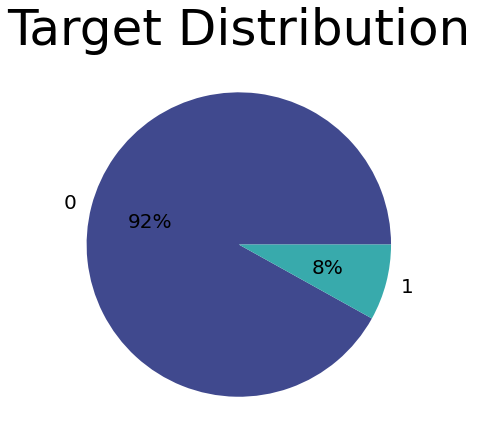

In [29]:
# Plots the repartition of Target

fig, ax = plt.subplots(figsize=(7,7))

ax.pie(
    application_train['TARGET'].value_counts(normalize=True).mul(100), 
    colors=sns.color_palette('mako', 2), 
    labels=application_train['TARGET'].value_counts(normalize=True).index, 
    autopct='%.0f%%',
    textprops={'fontsize': text_size -10}
)



plt.title('Target Distribution', fontsize = title_size);

<h6>Univariate Analysis

In [30]:
# Value counts types of features 

application_train_types_count_df = \
    application_train_untargeted.dtypes.value_counts()\
                        .to_frame(name='Count')\
                        .reset_index()\
                        .rename({'index' : 'Types'}, axis = 1)

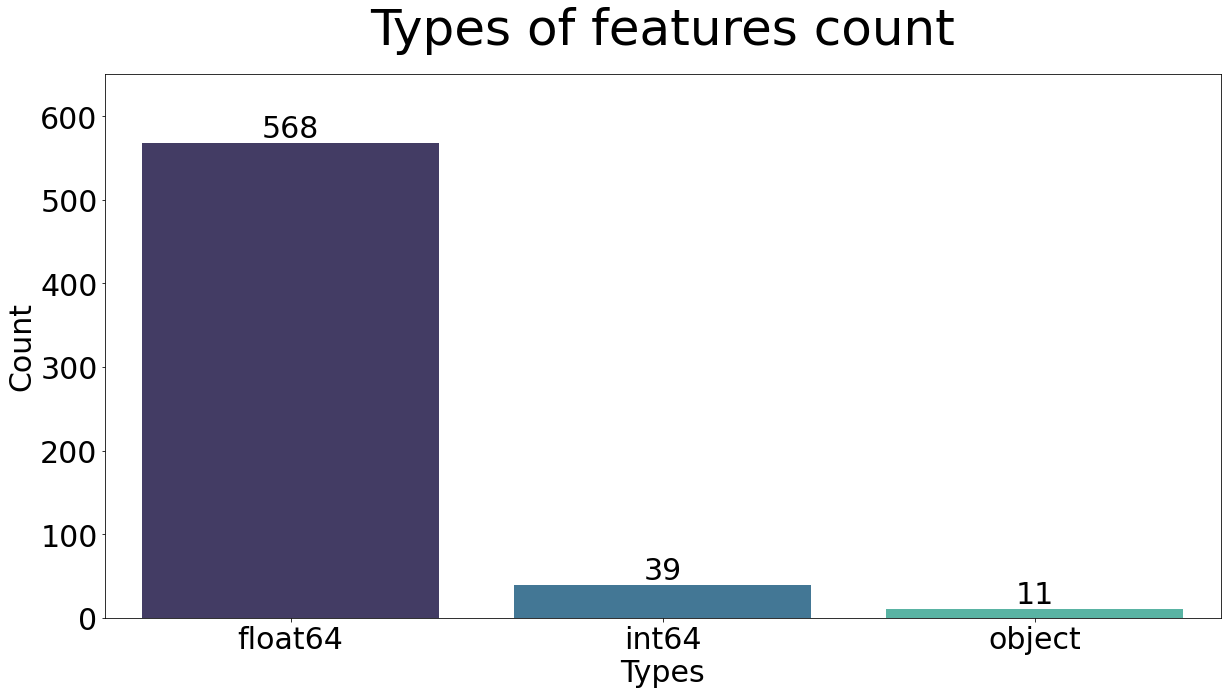

In [31]:
# Plots Value counts types of features 

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(y="Count", 
            x="Types",
            palette=sns.color_palette('mako', 3), 
            data=application_train_types_count_df,
            ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('Types', fontsize=text_size)
ax.set_ylabel('Count', fontsize=text_size)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f', fontsize=text_size)
        
ax.set_ylim(None, 650)
        
plt.title('Types of features count', pad=30, fontsize=title_size)

plt.show();

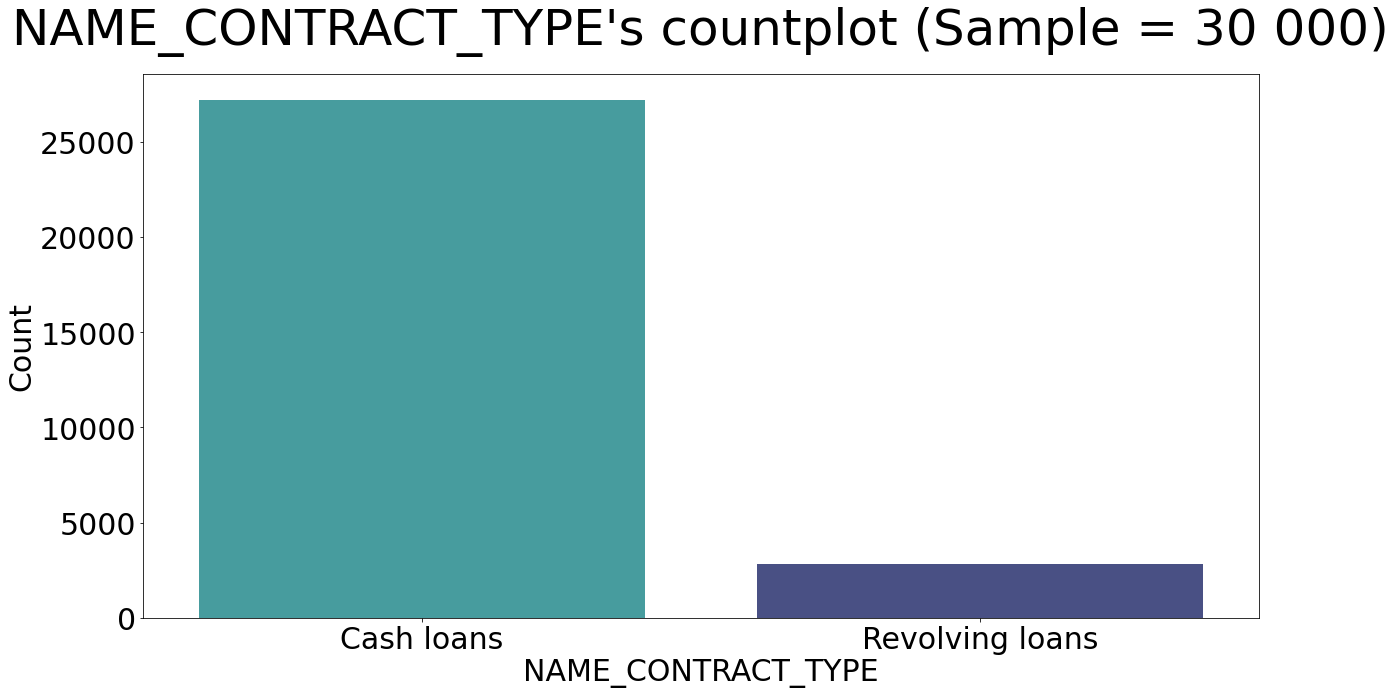

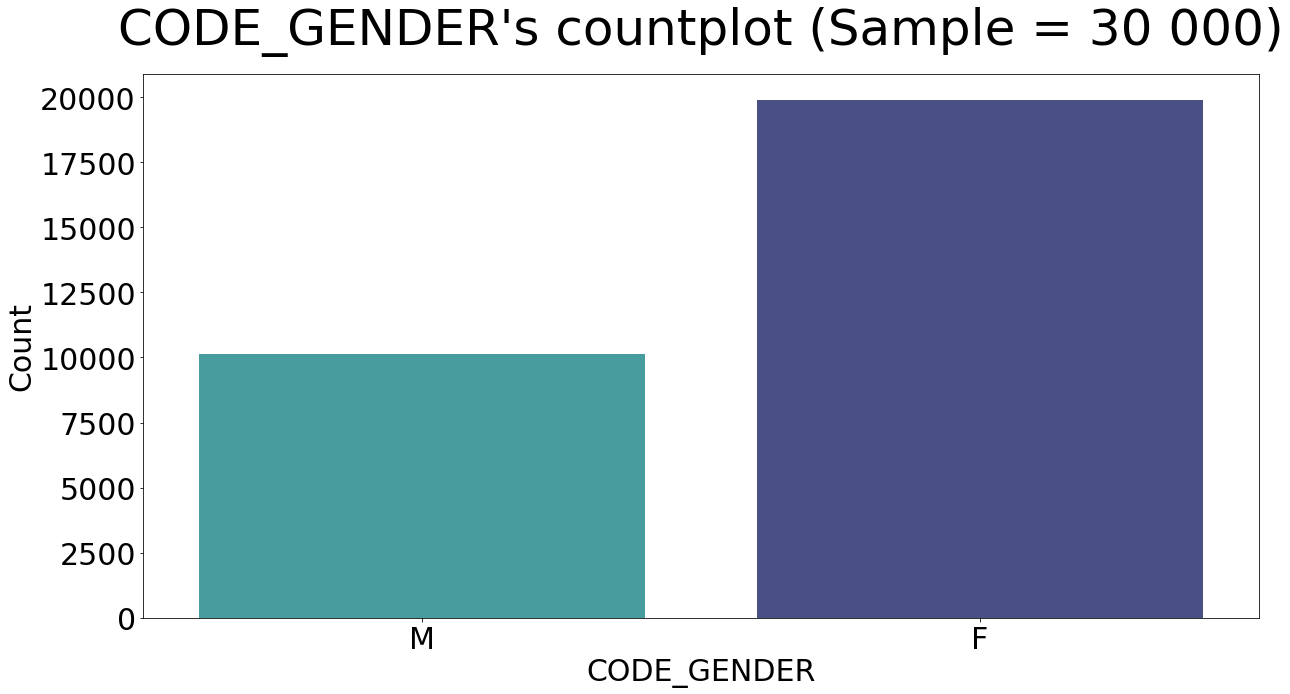

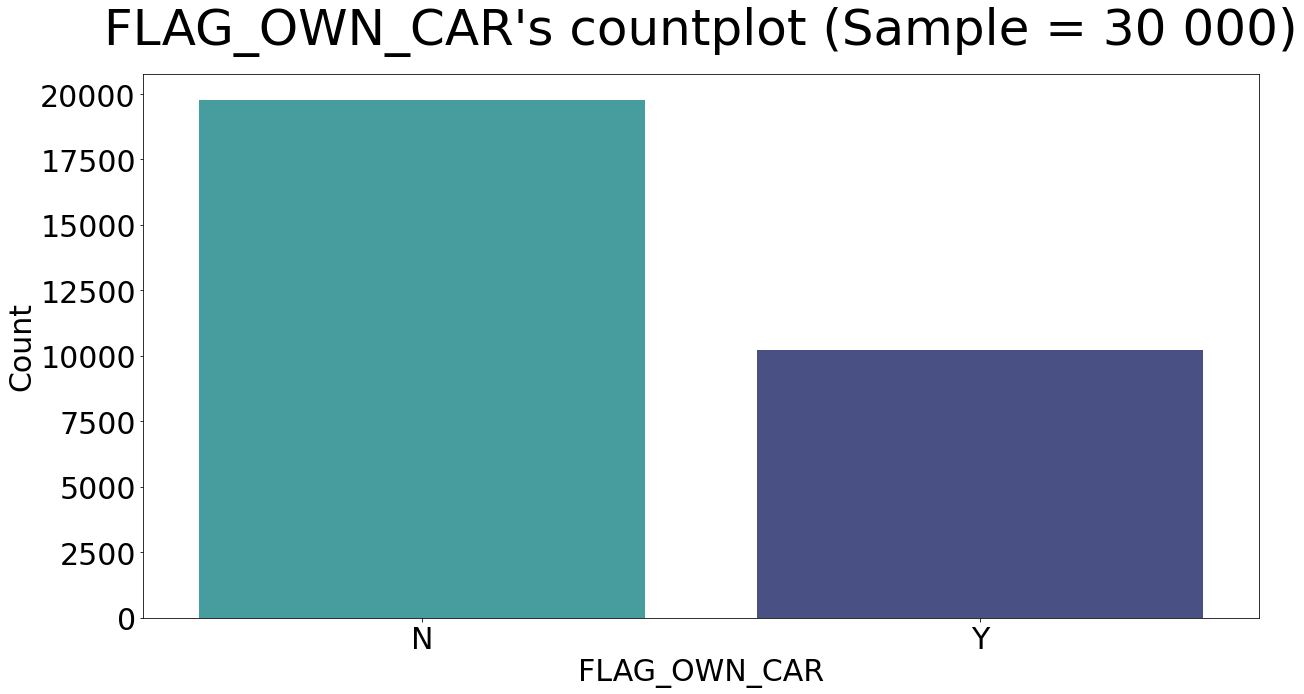

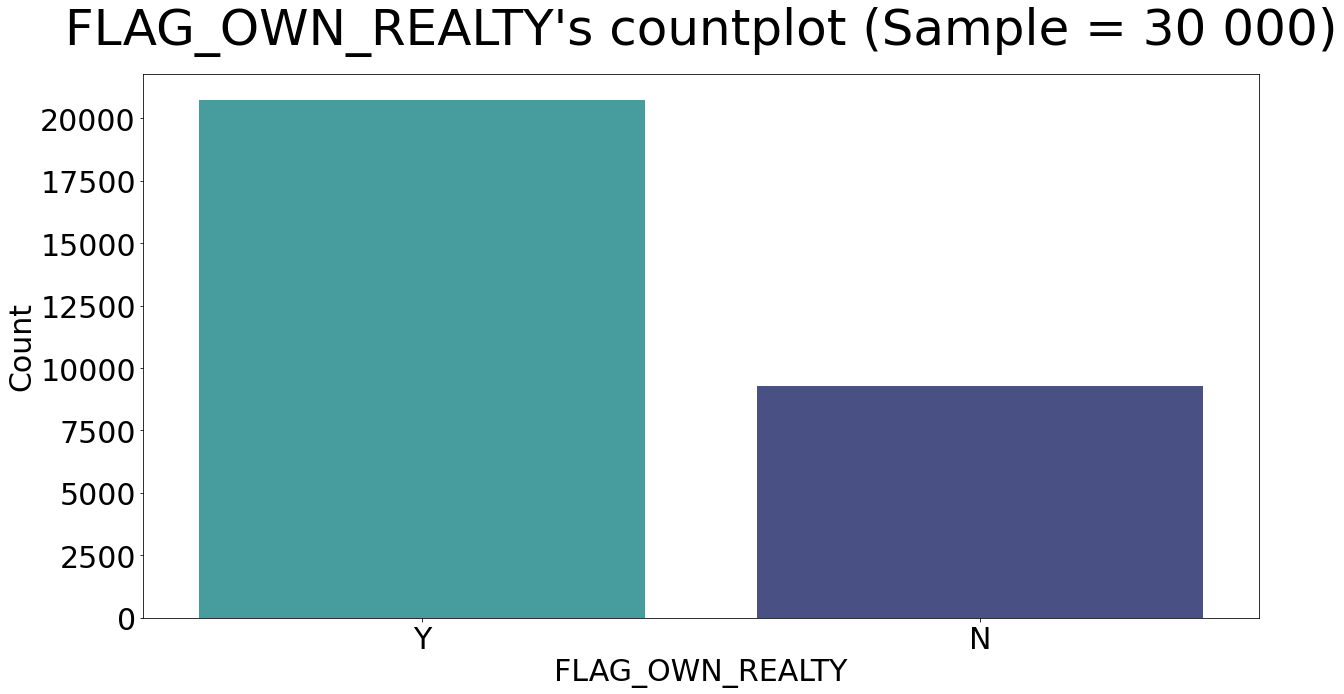

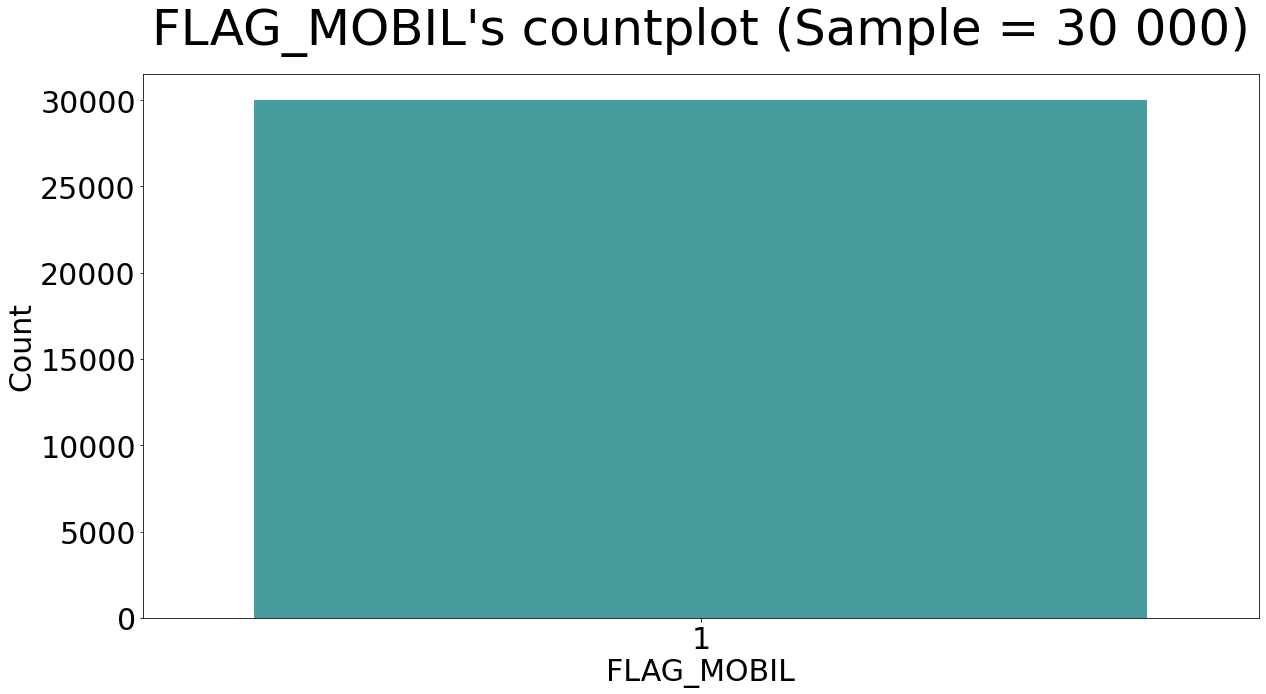

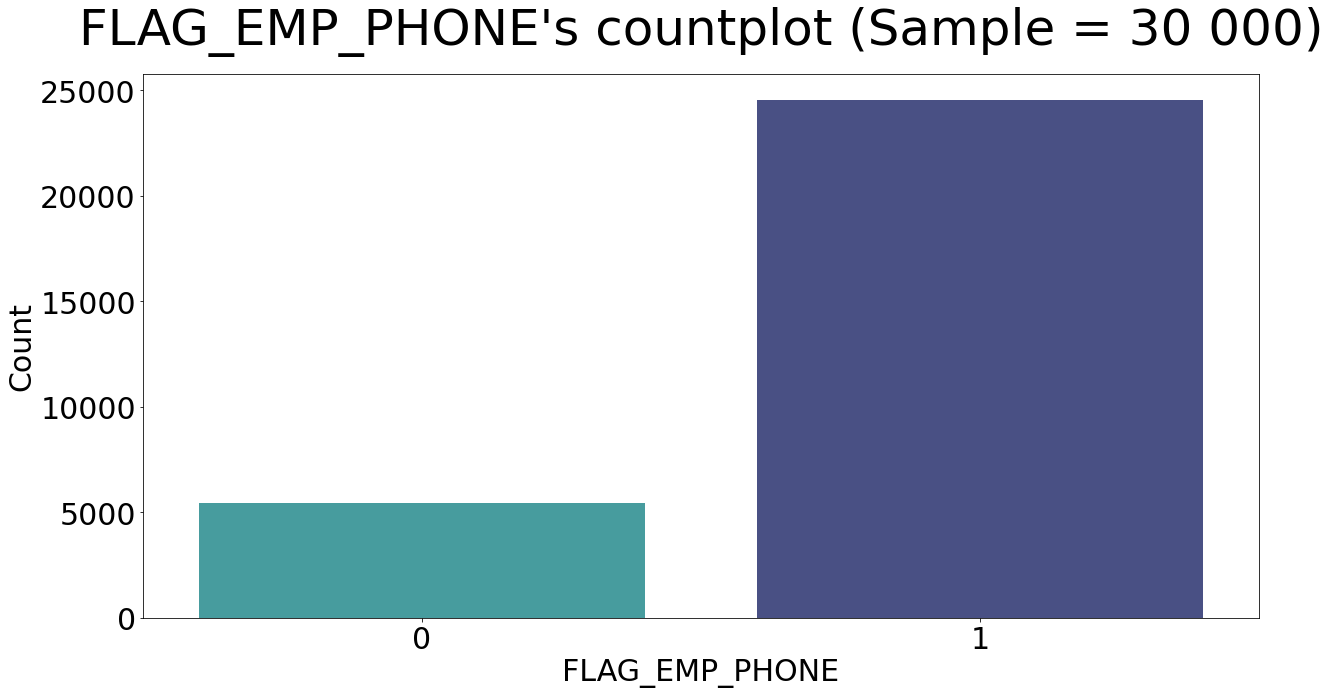

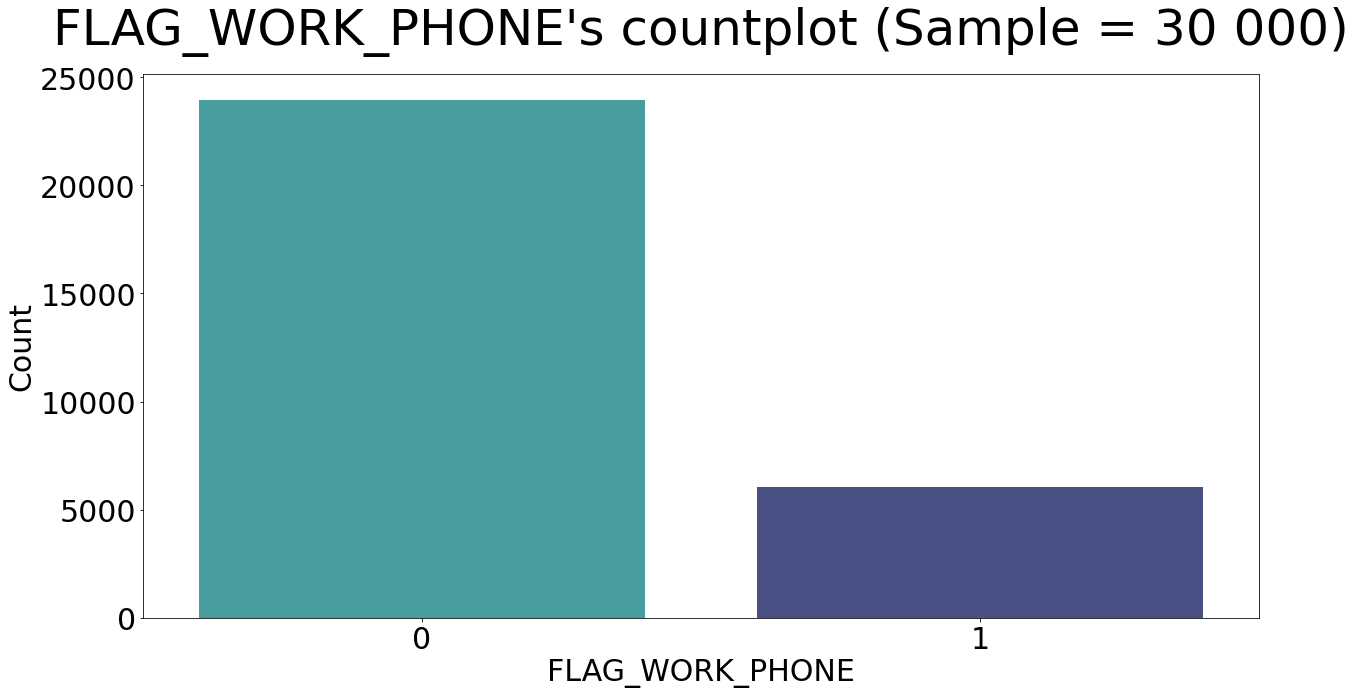

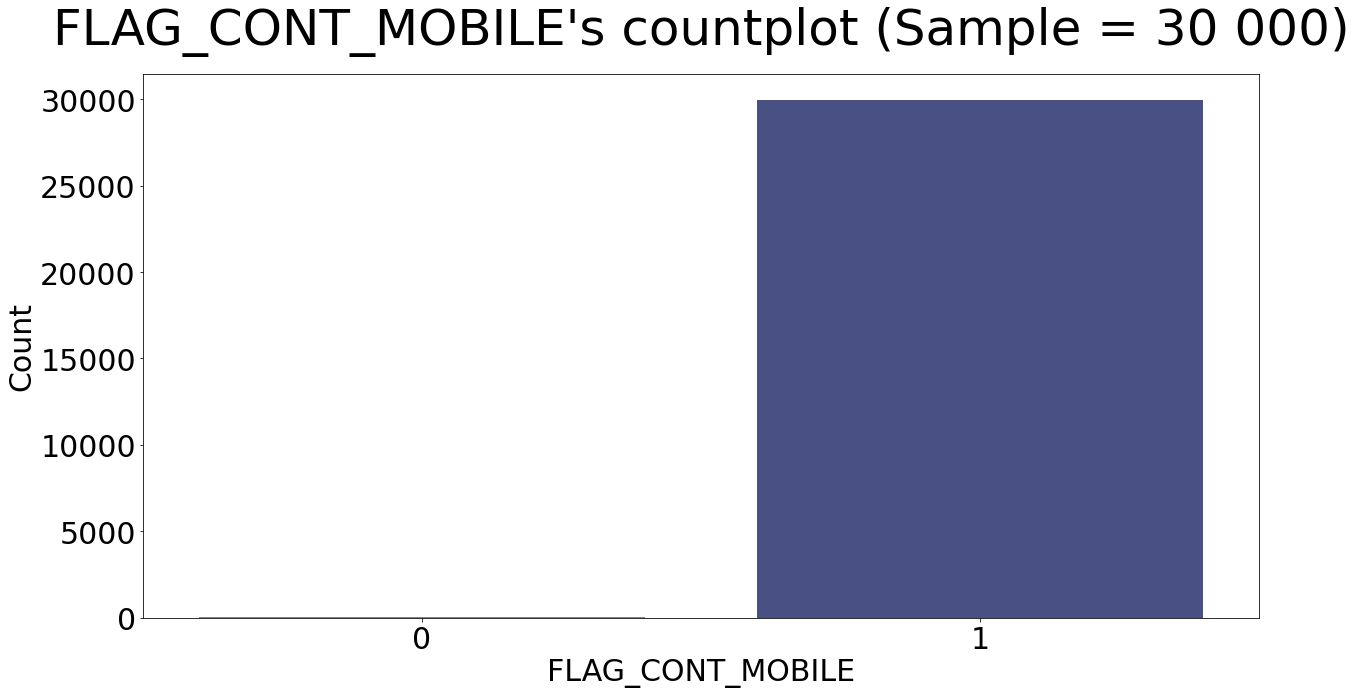

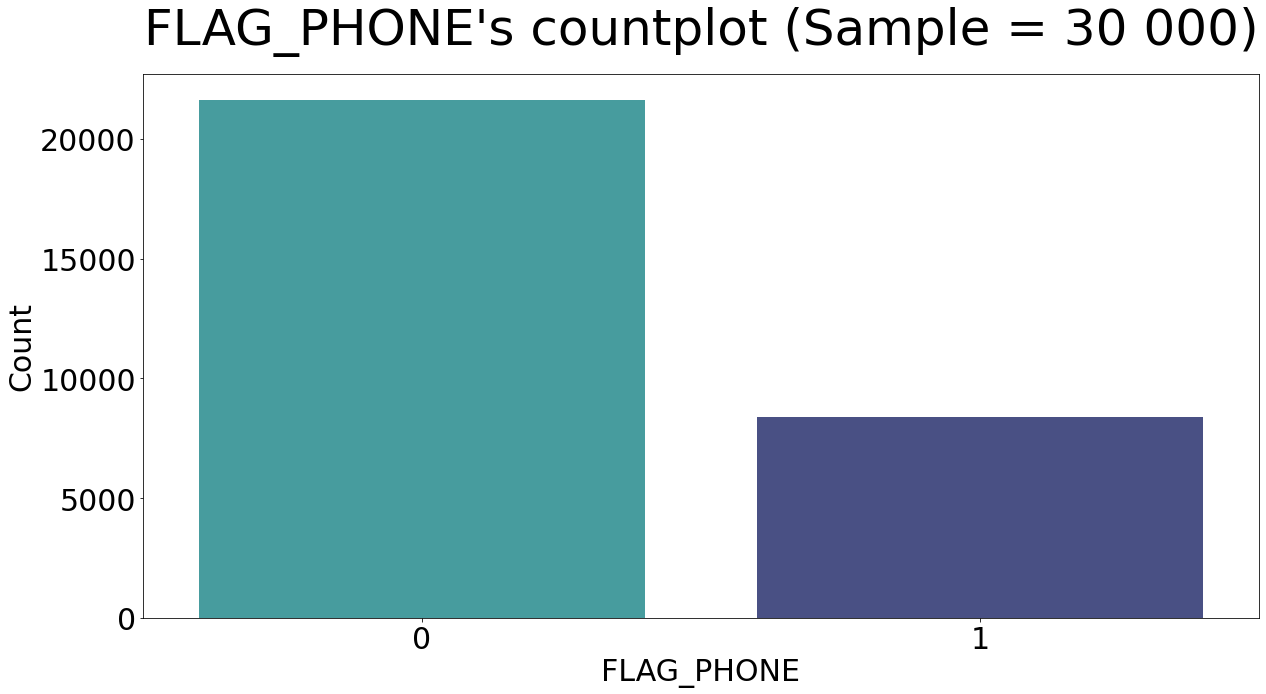

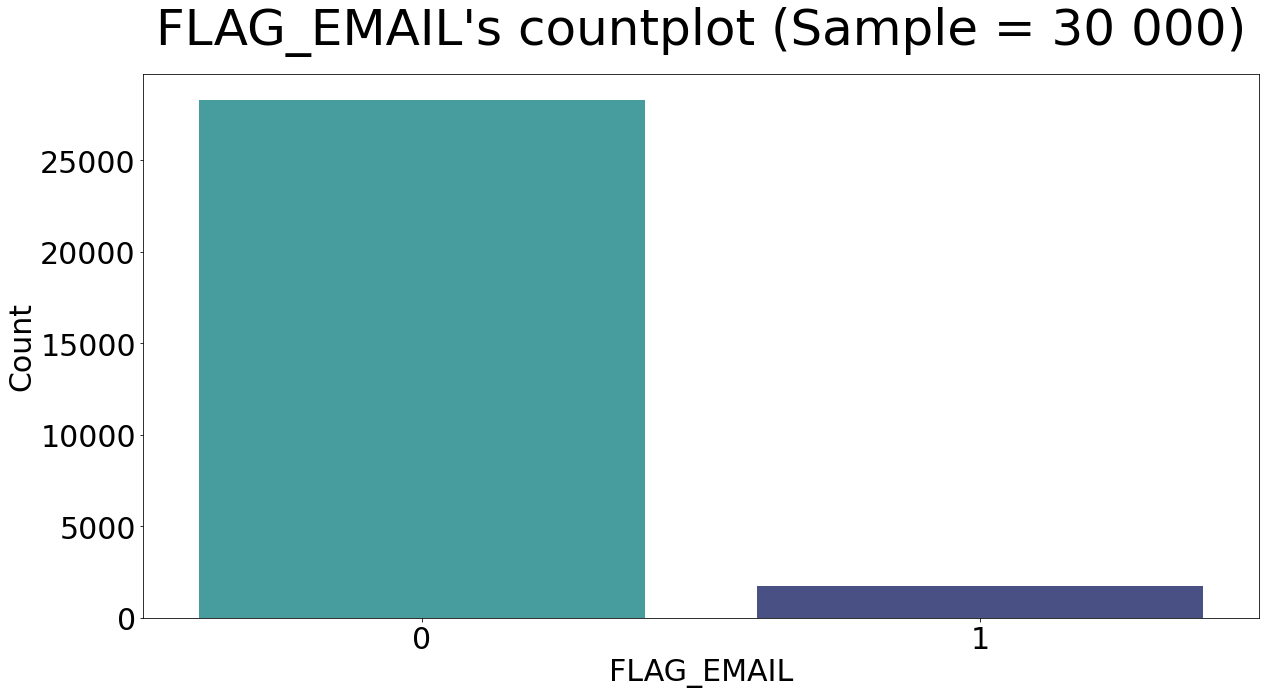

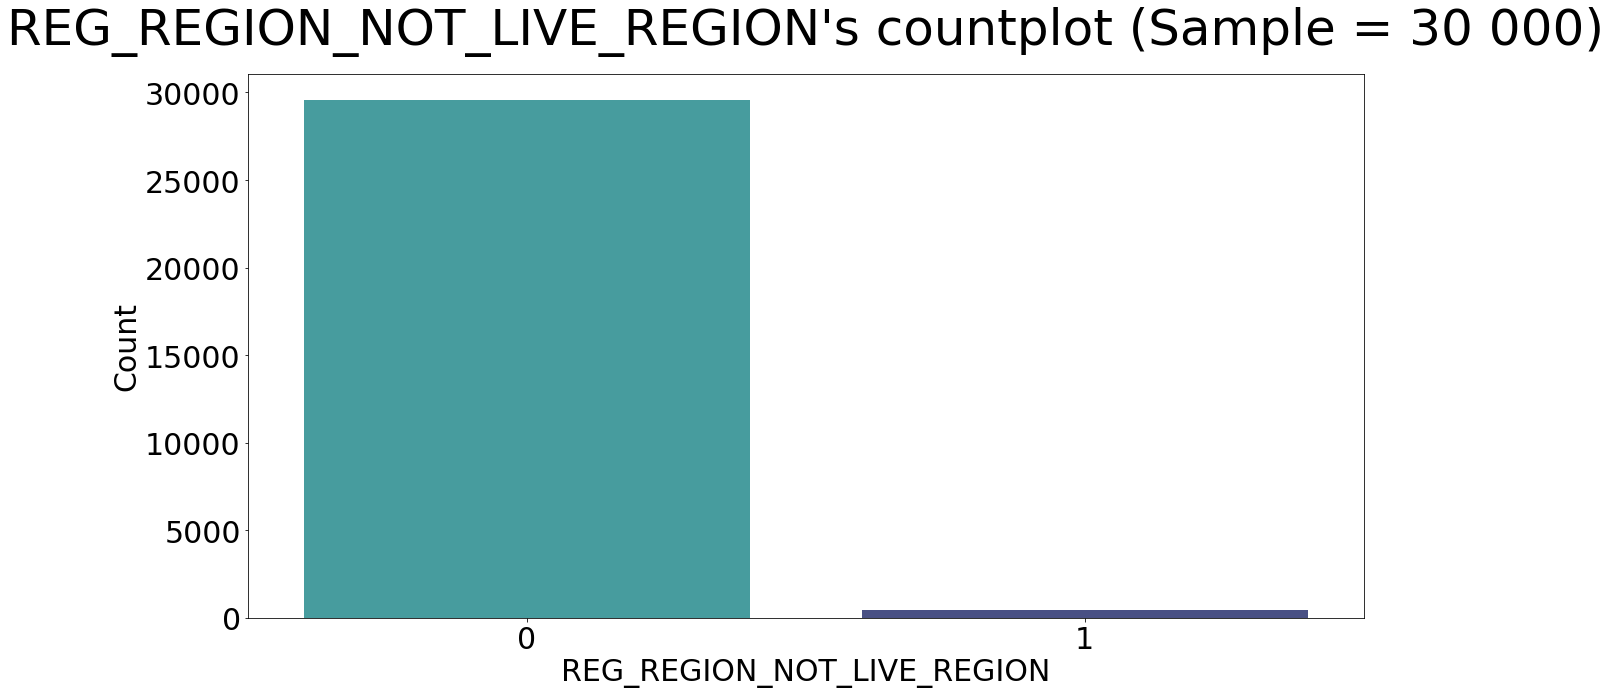

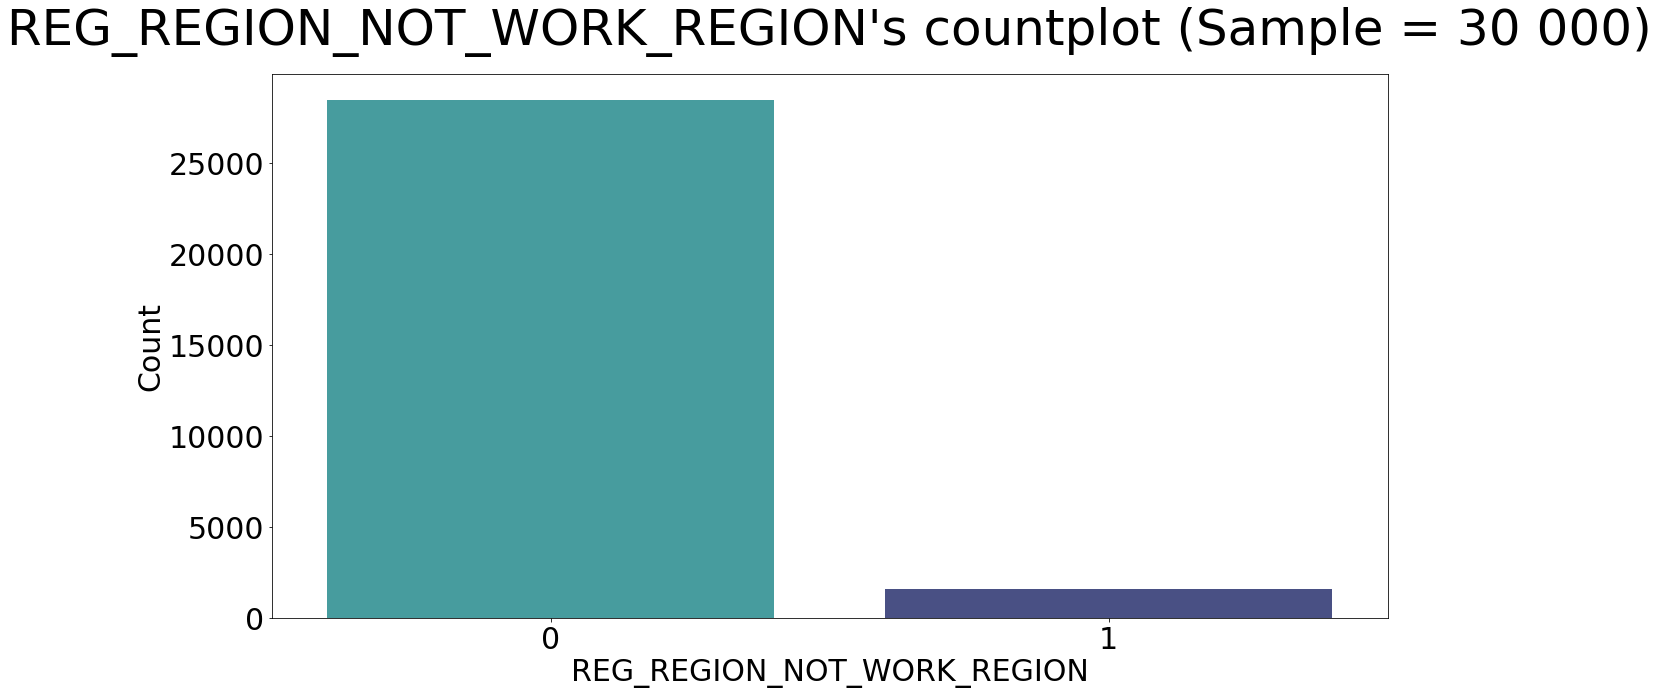

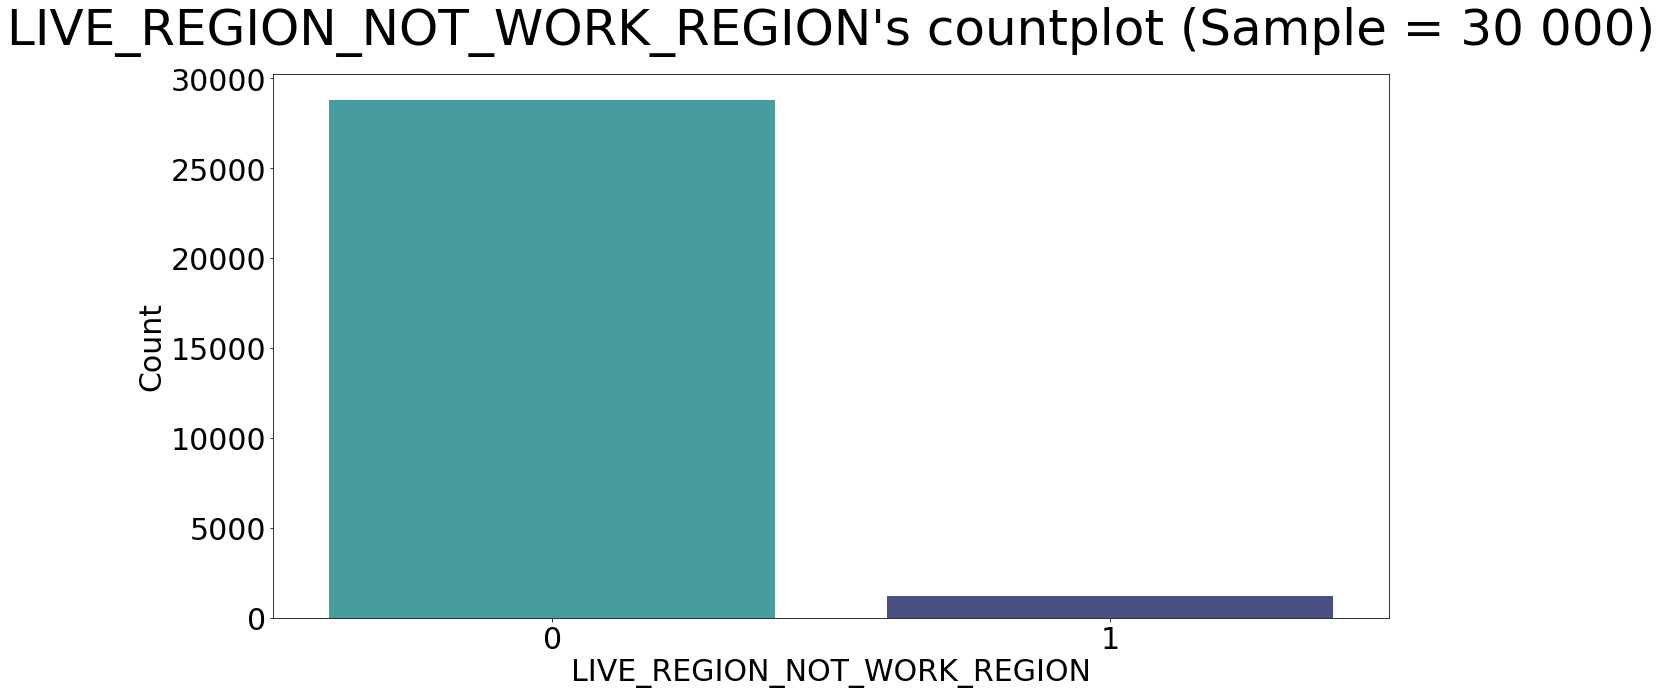

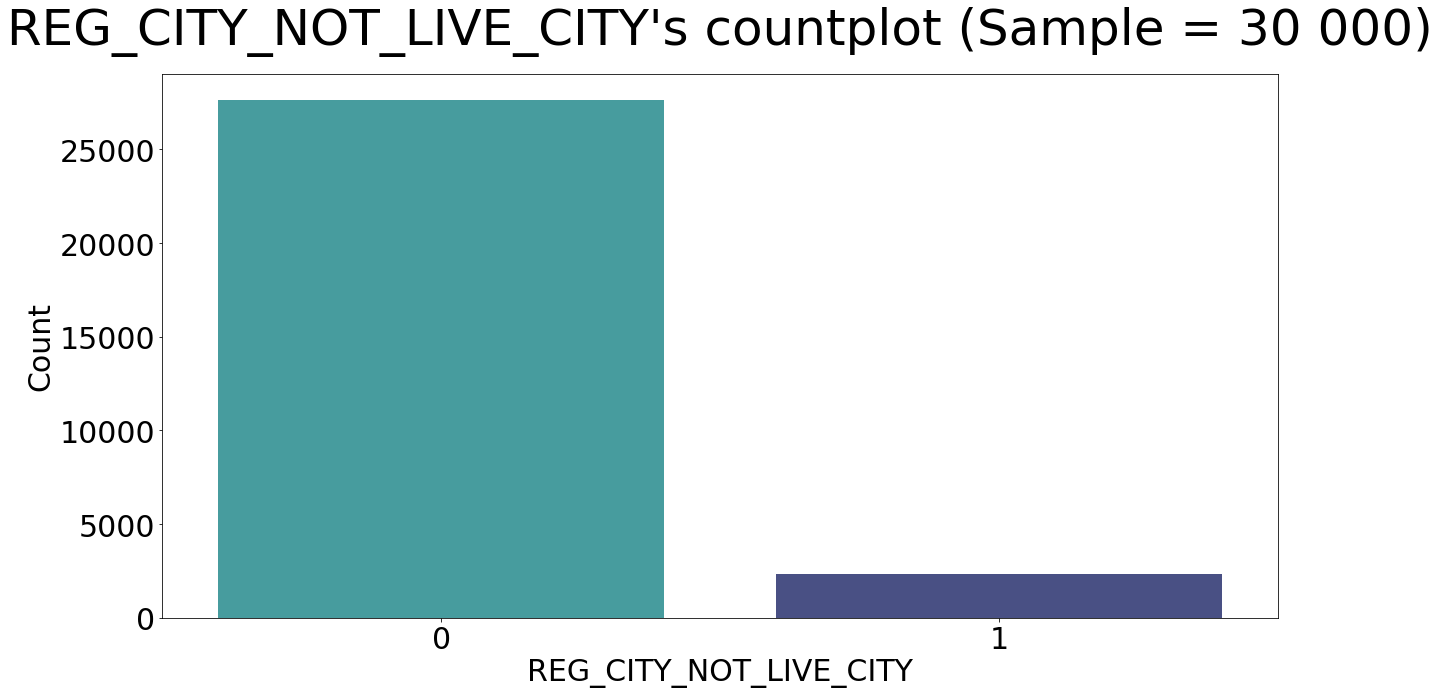

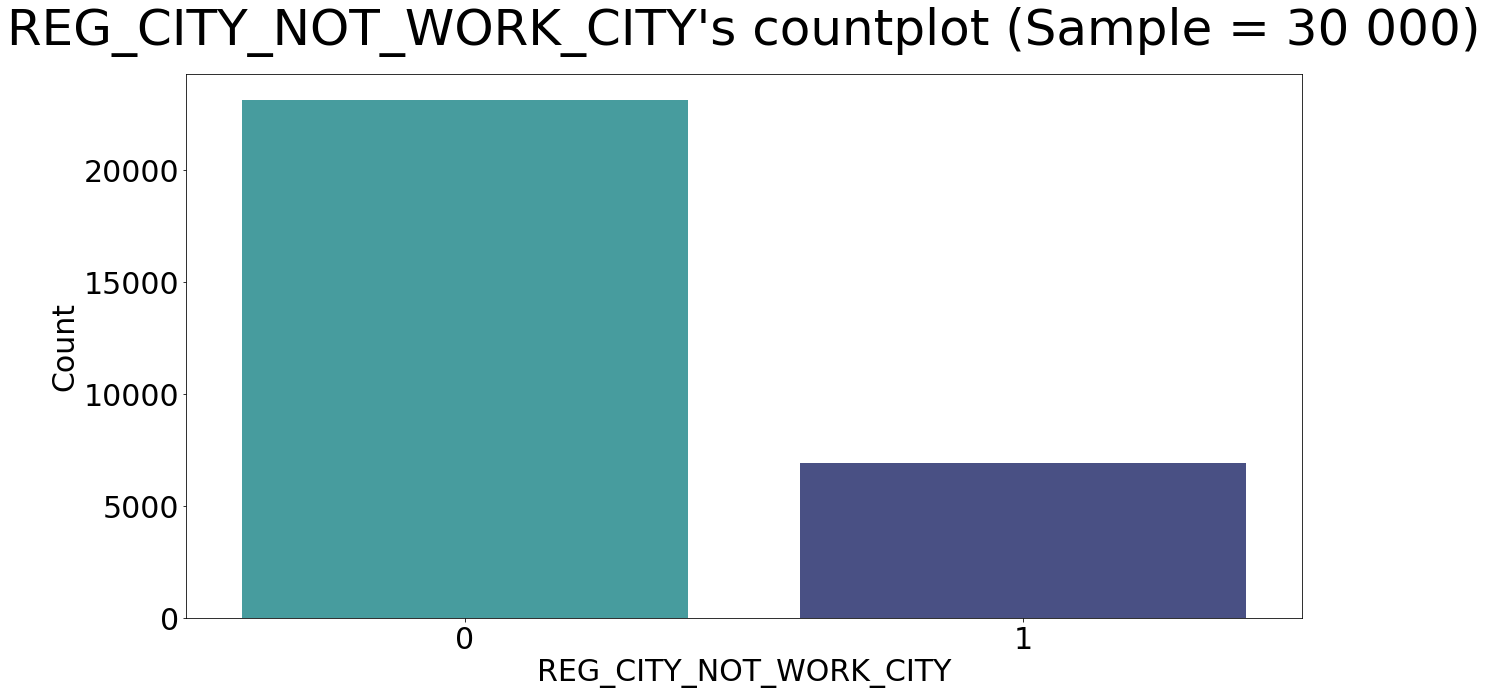

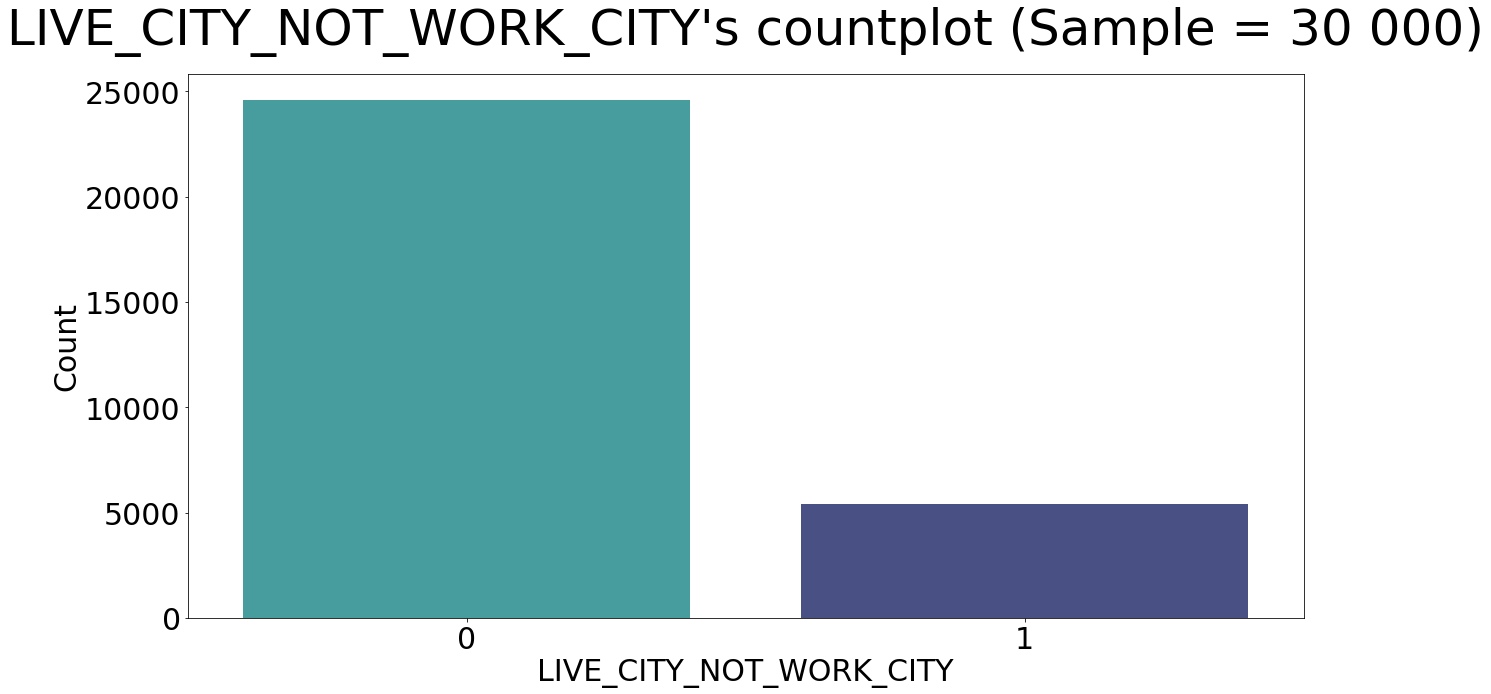

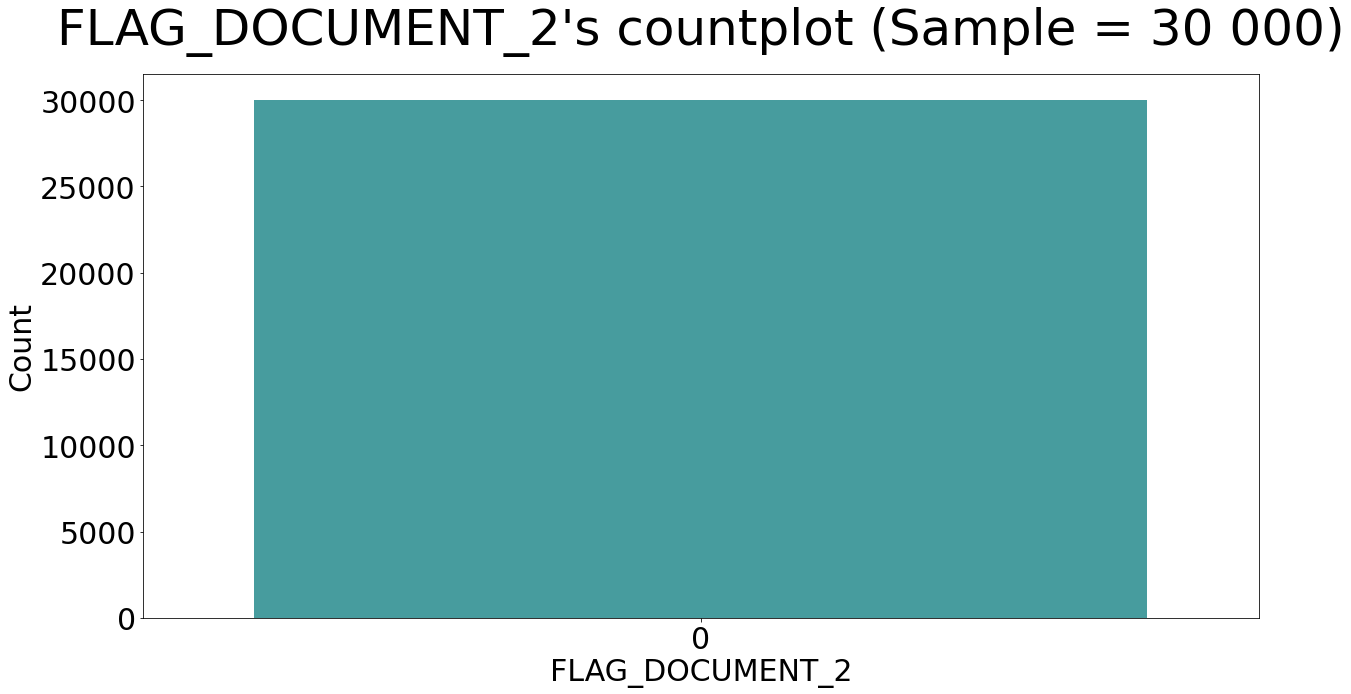

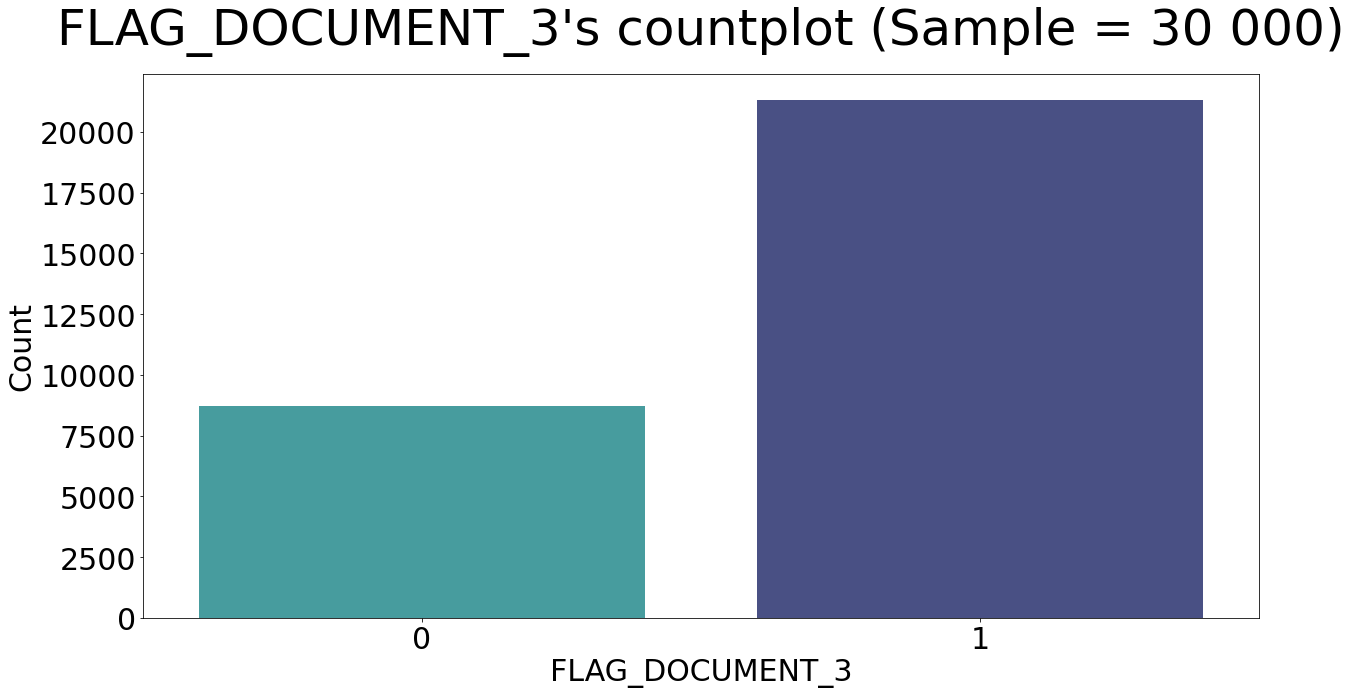

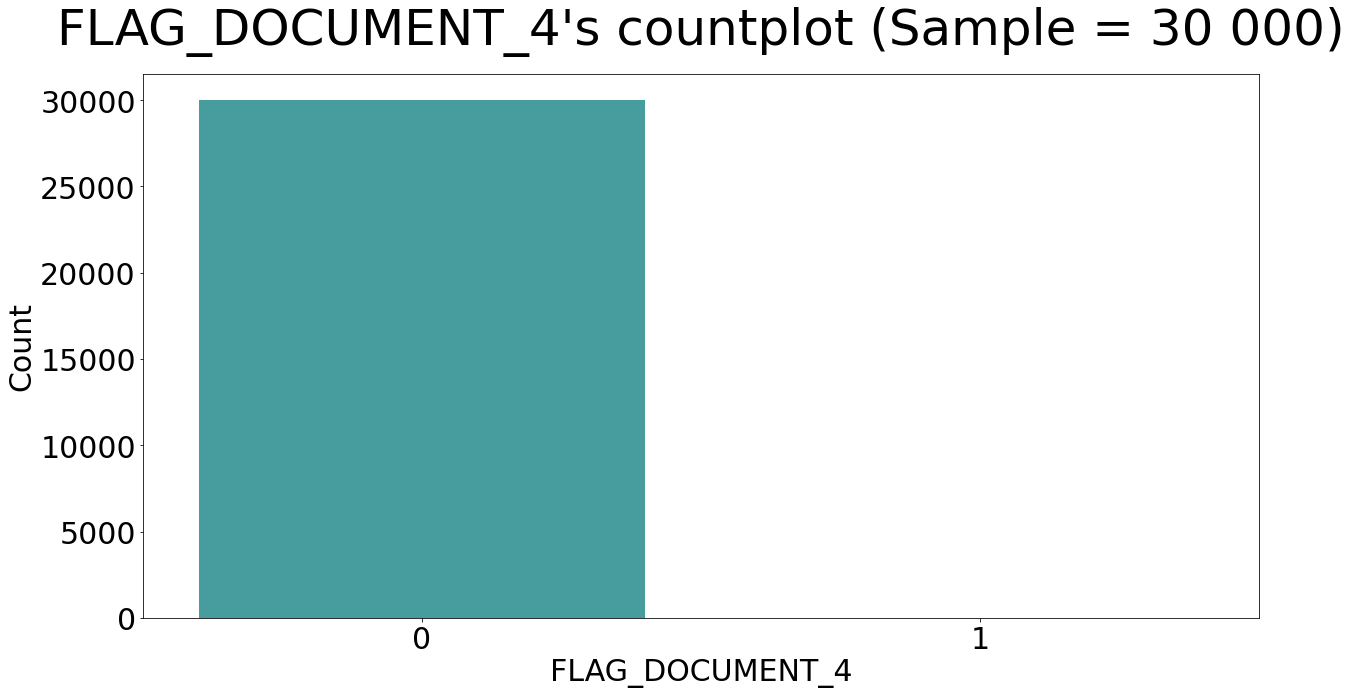

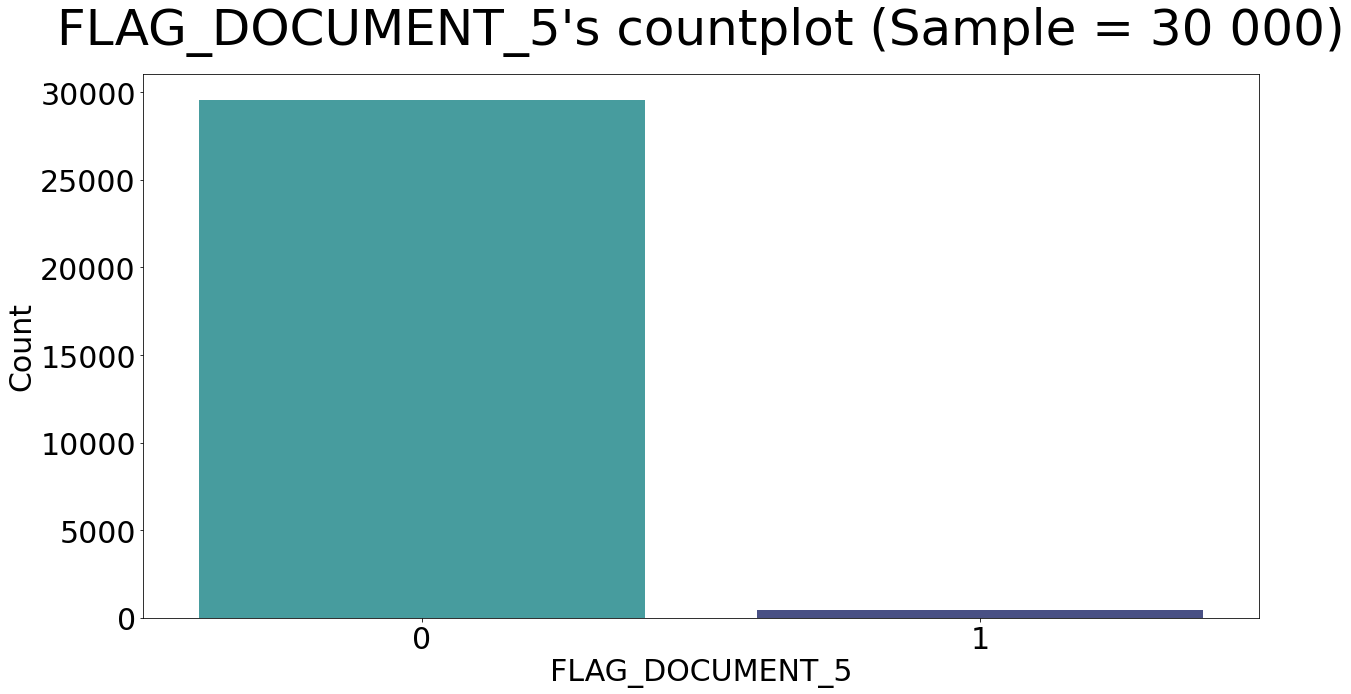

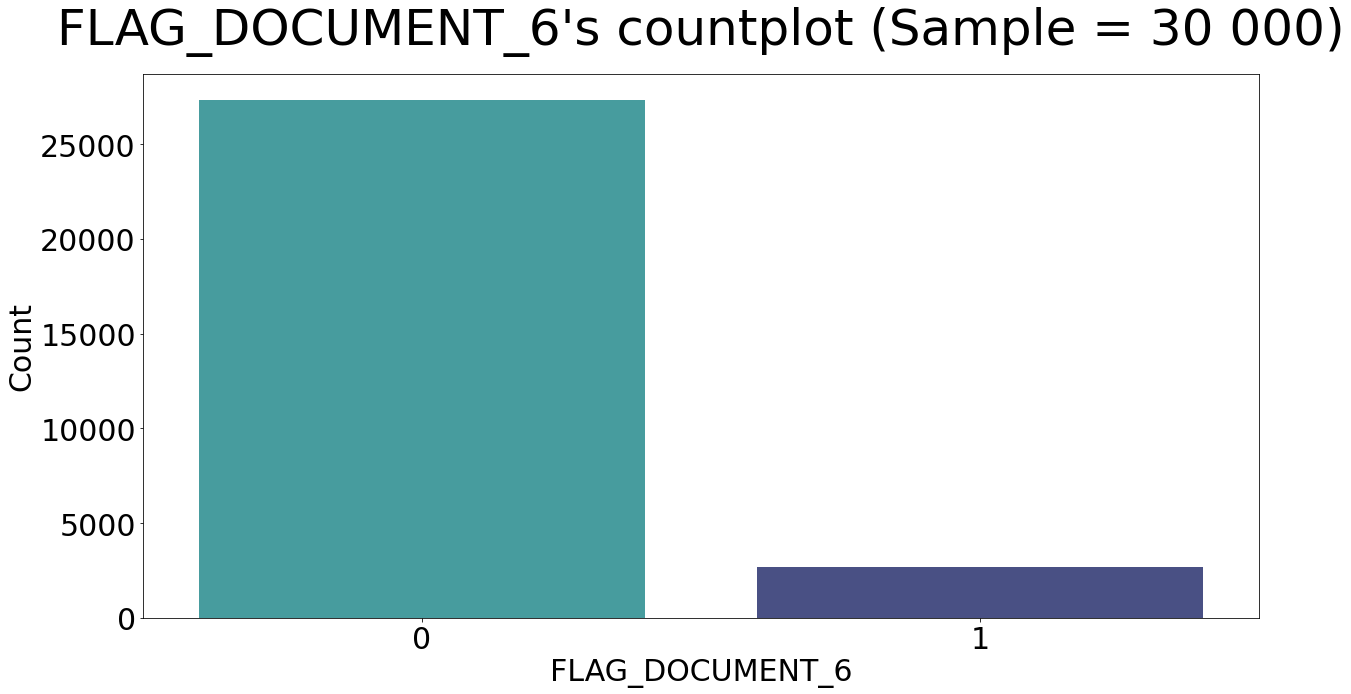

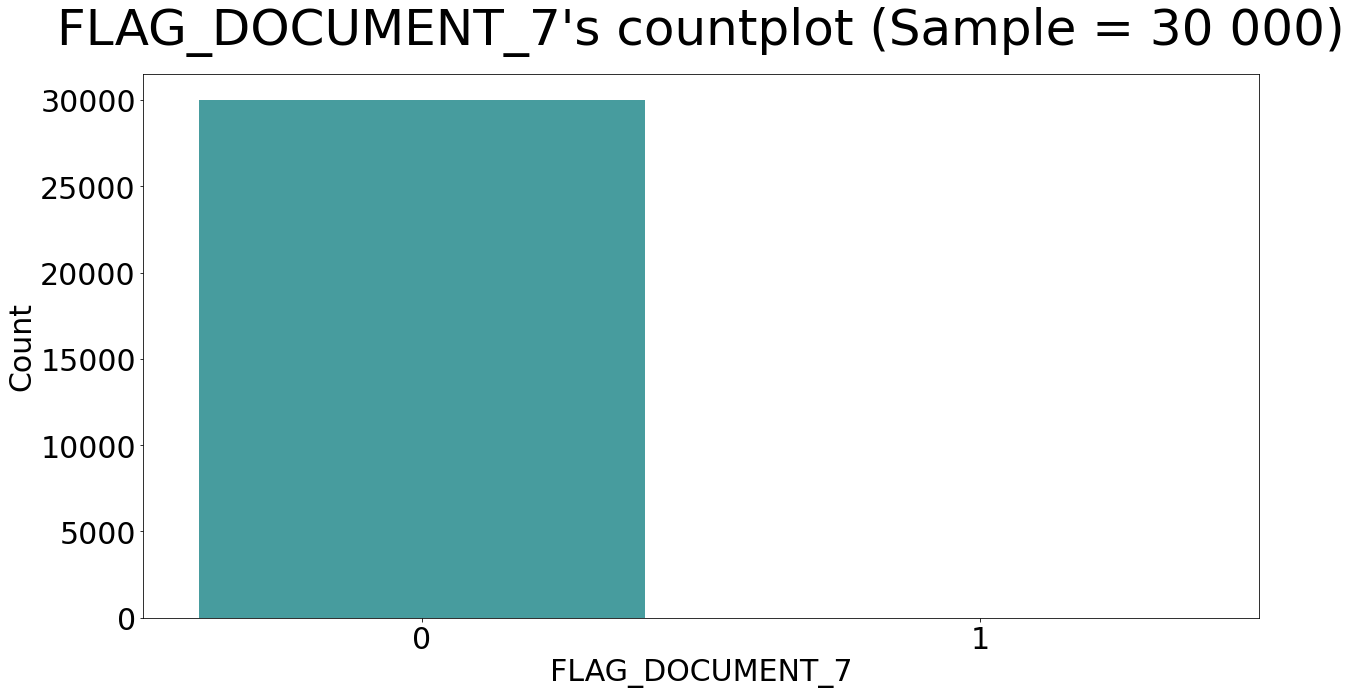

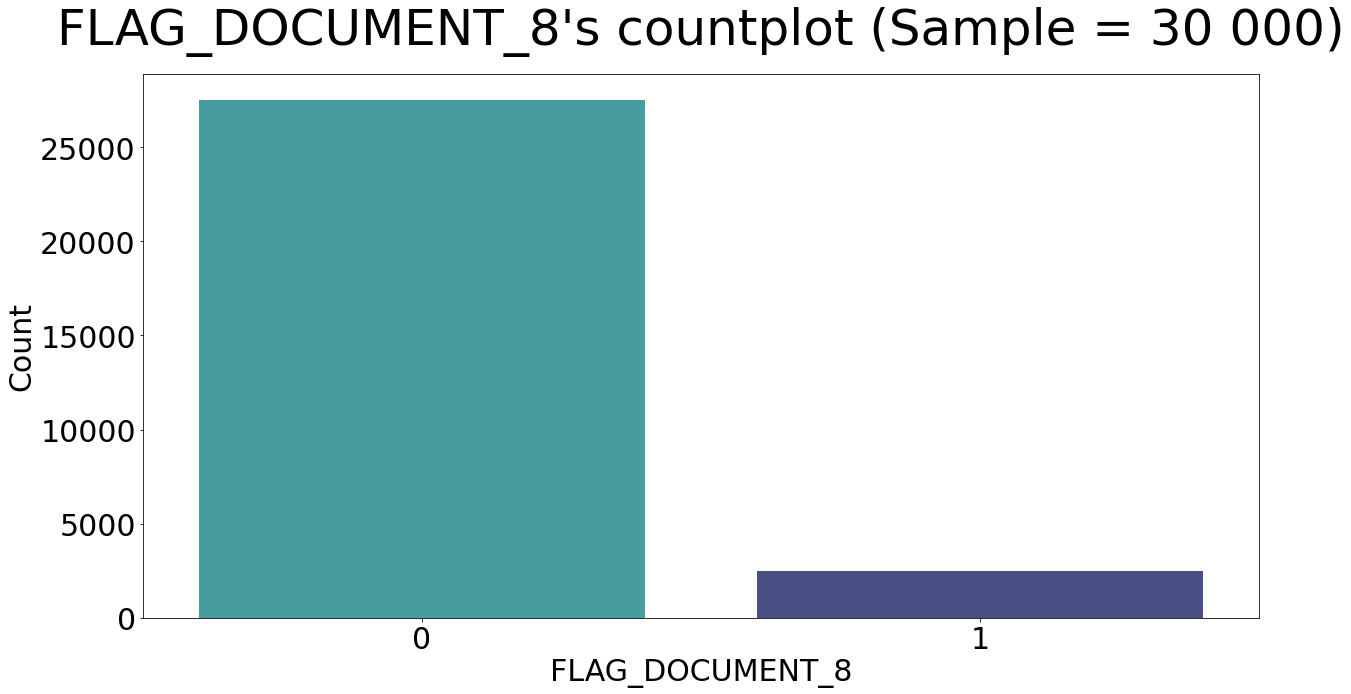

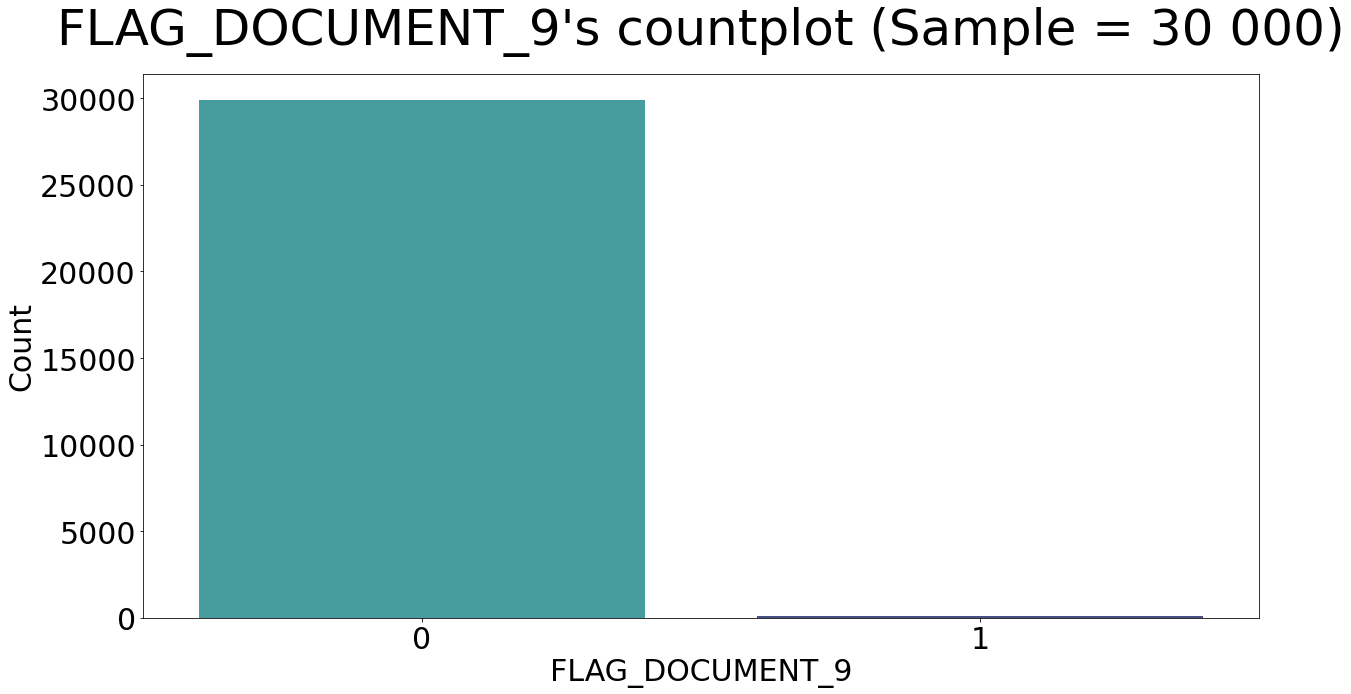

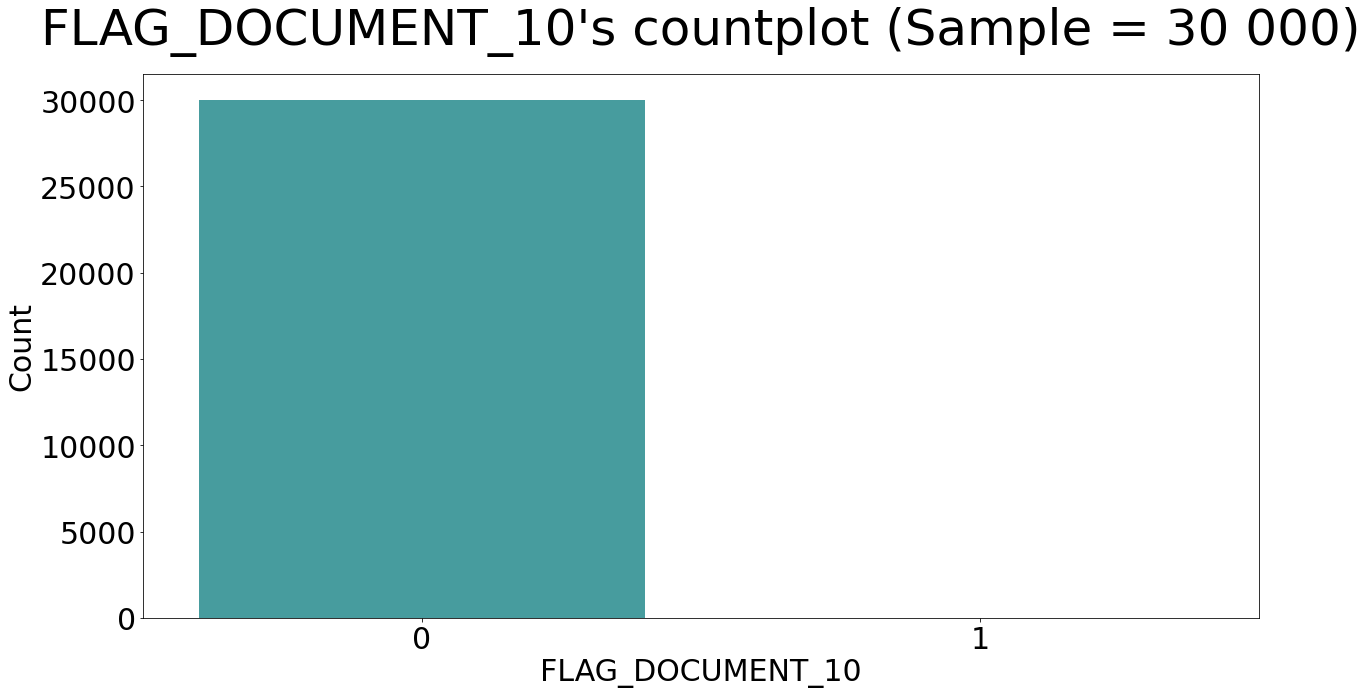

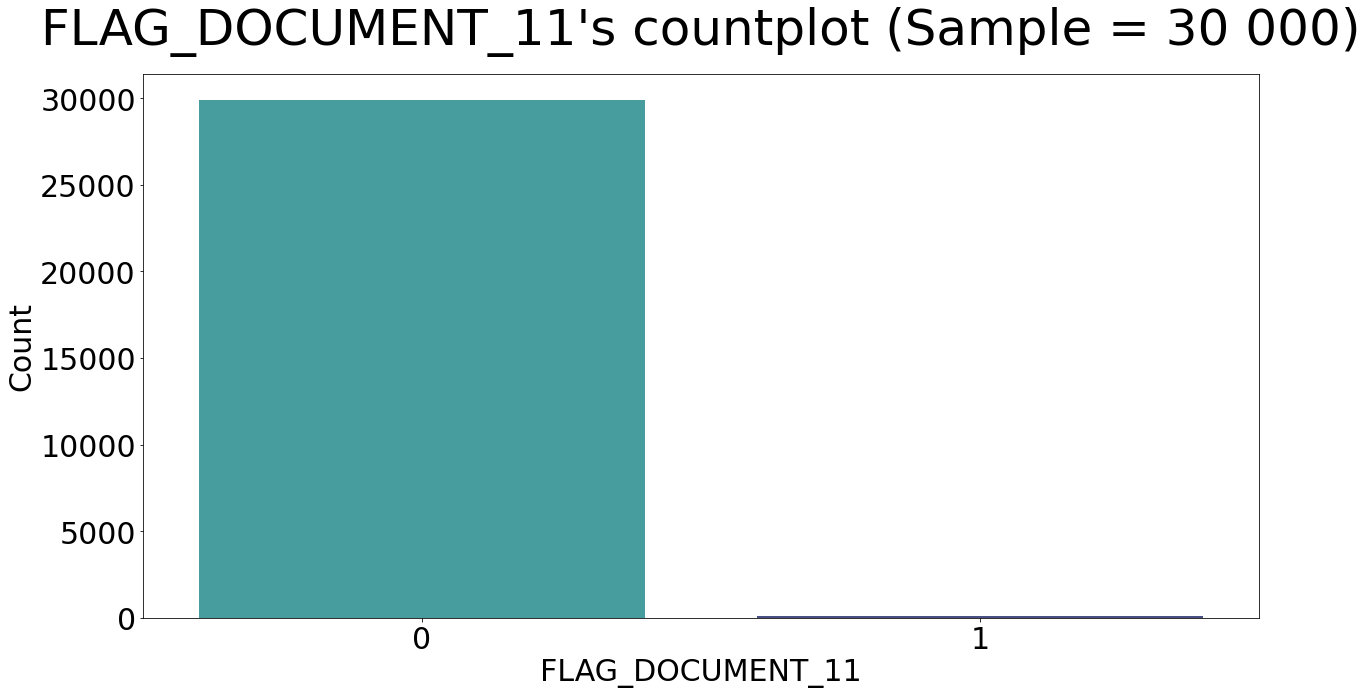

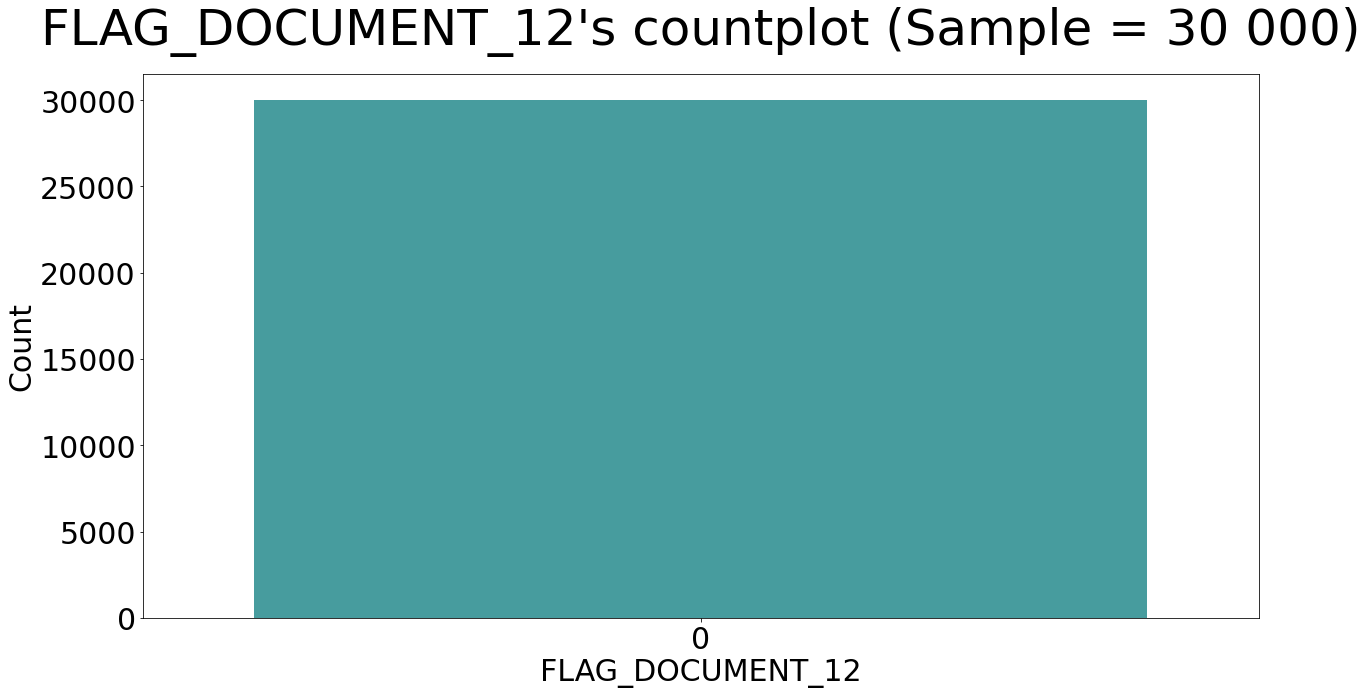

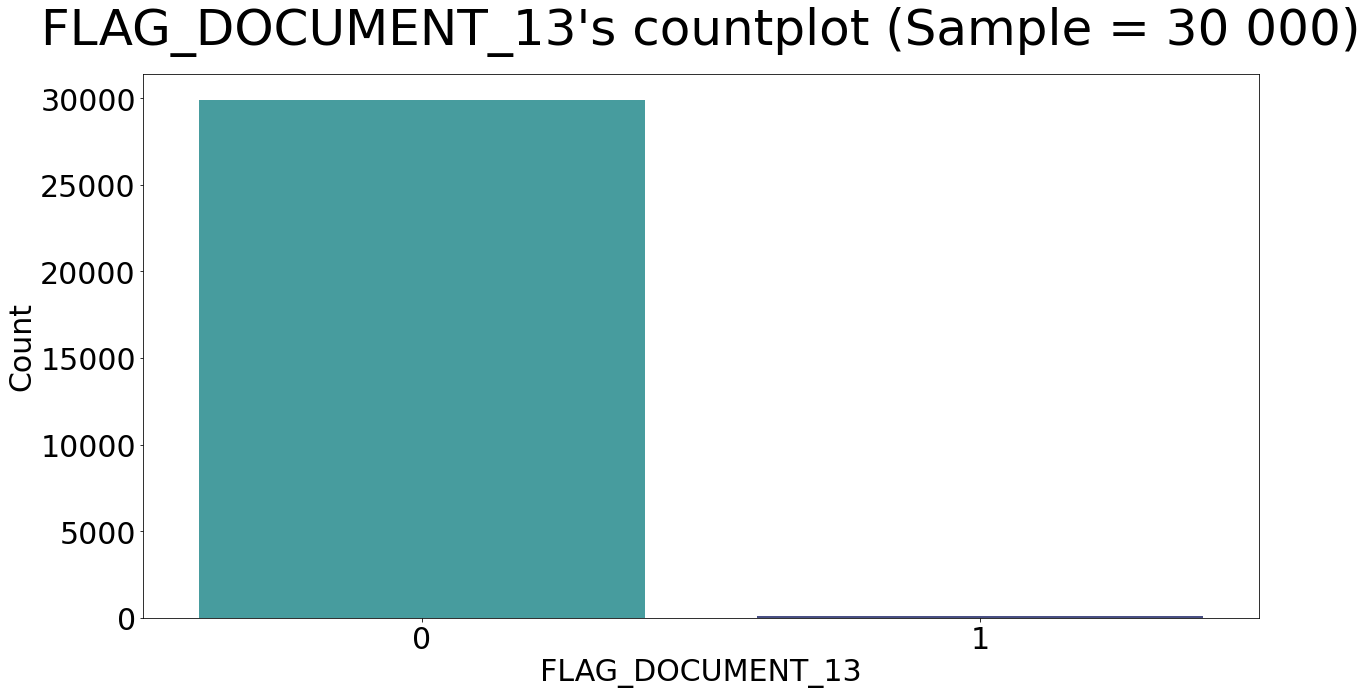

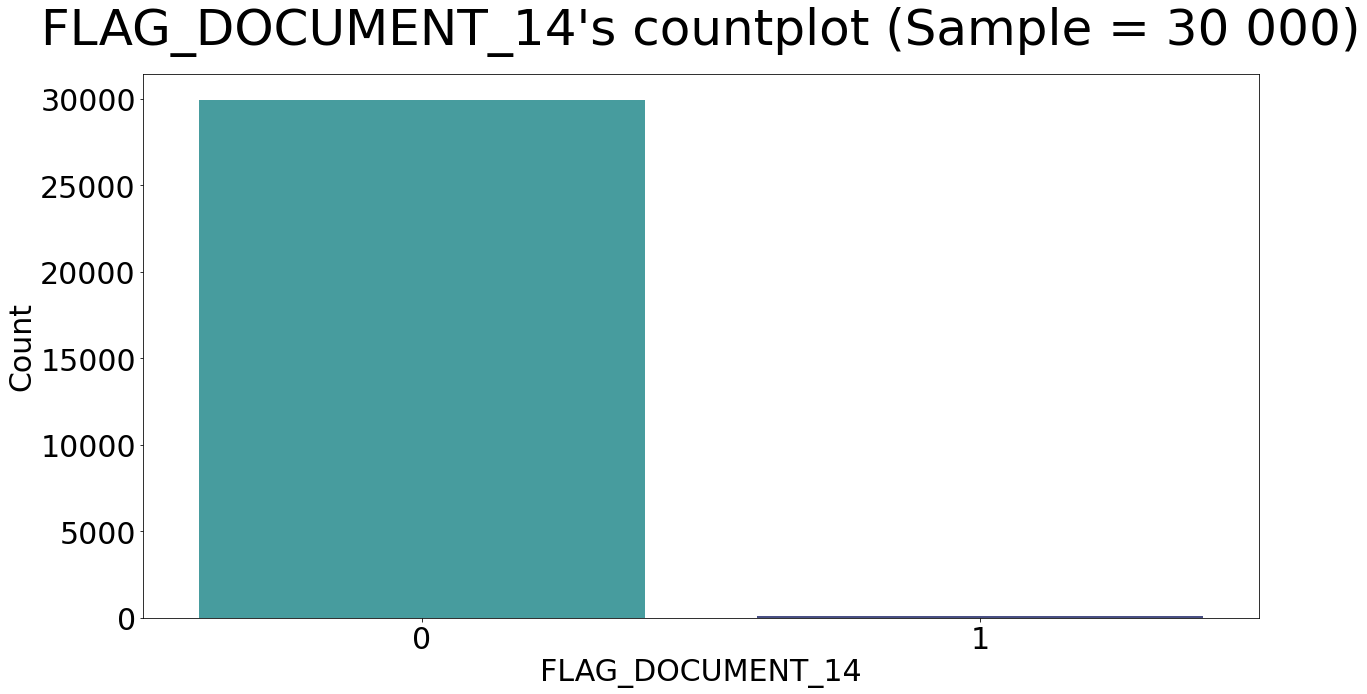

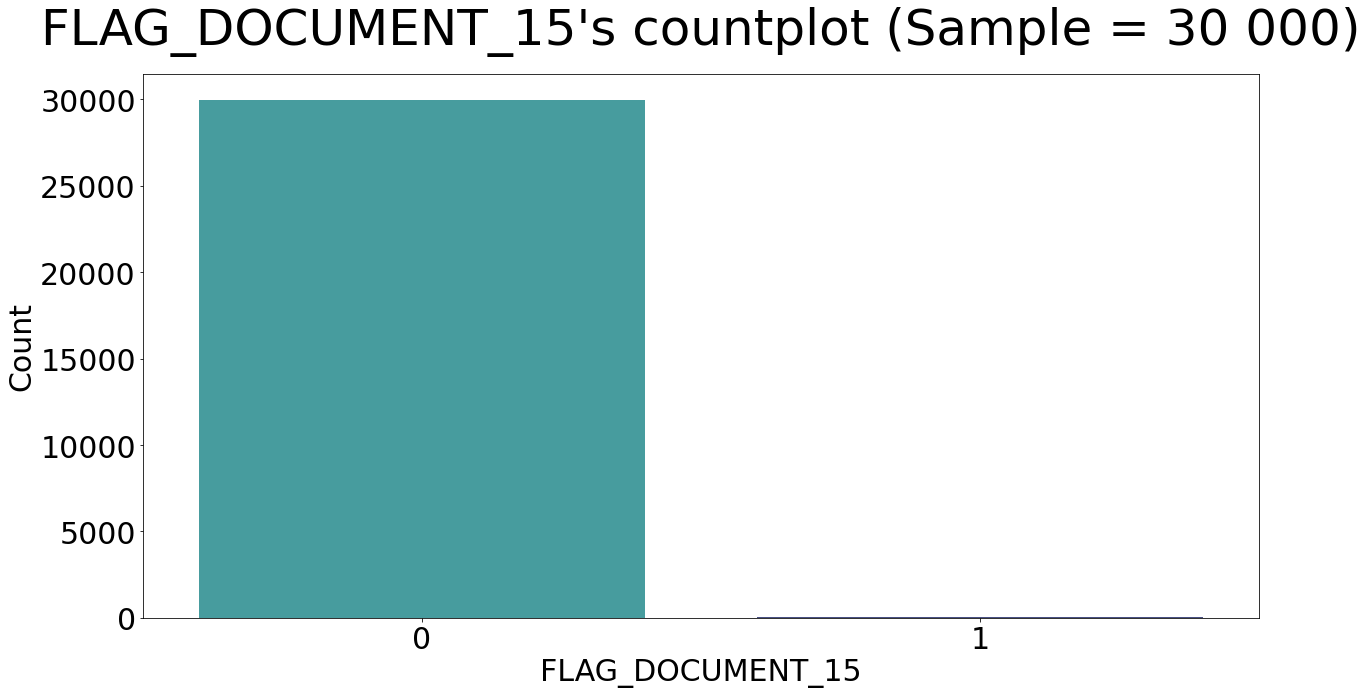

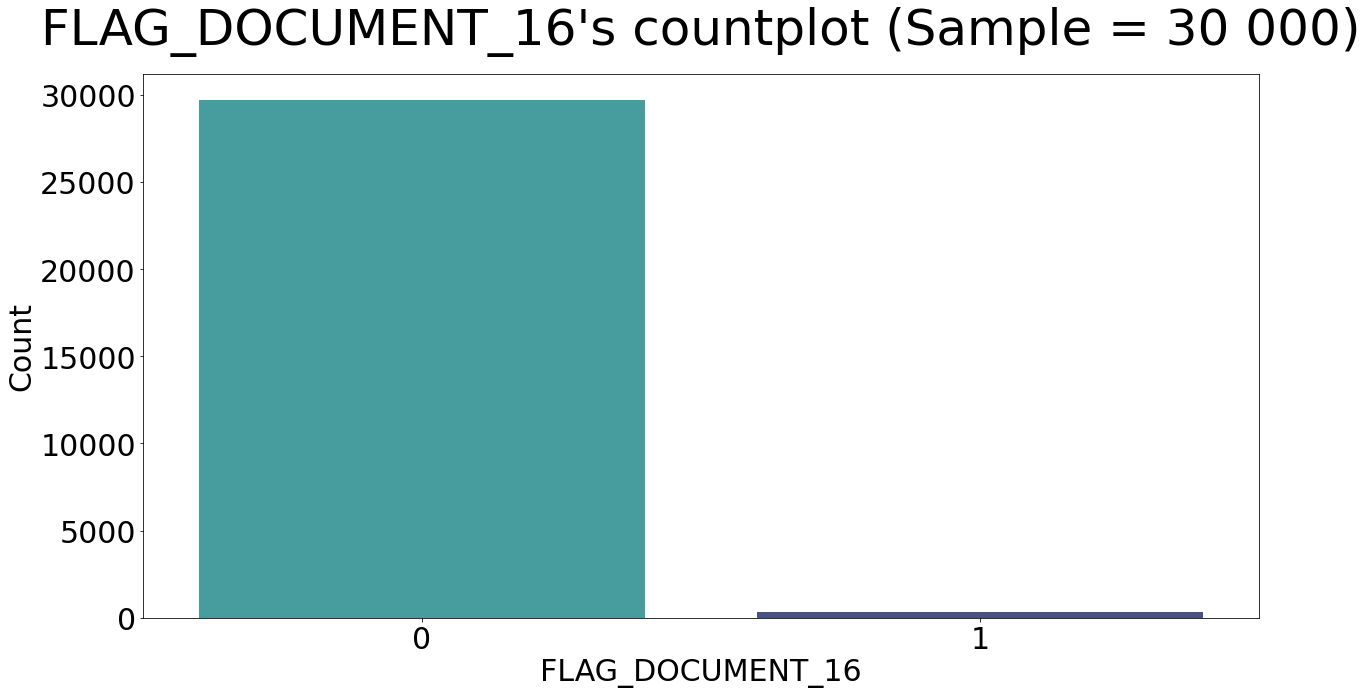

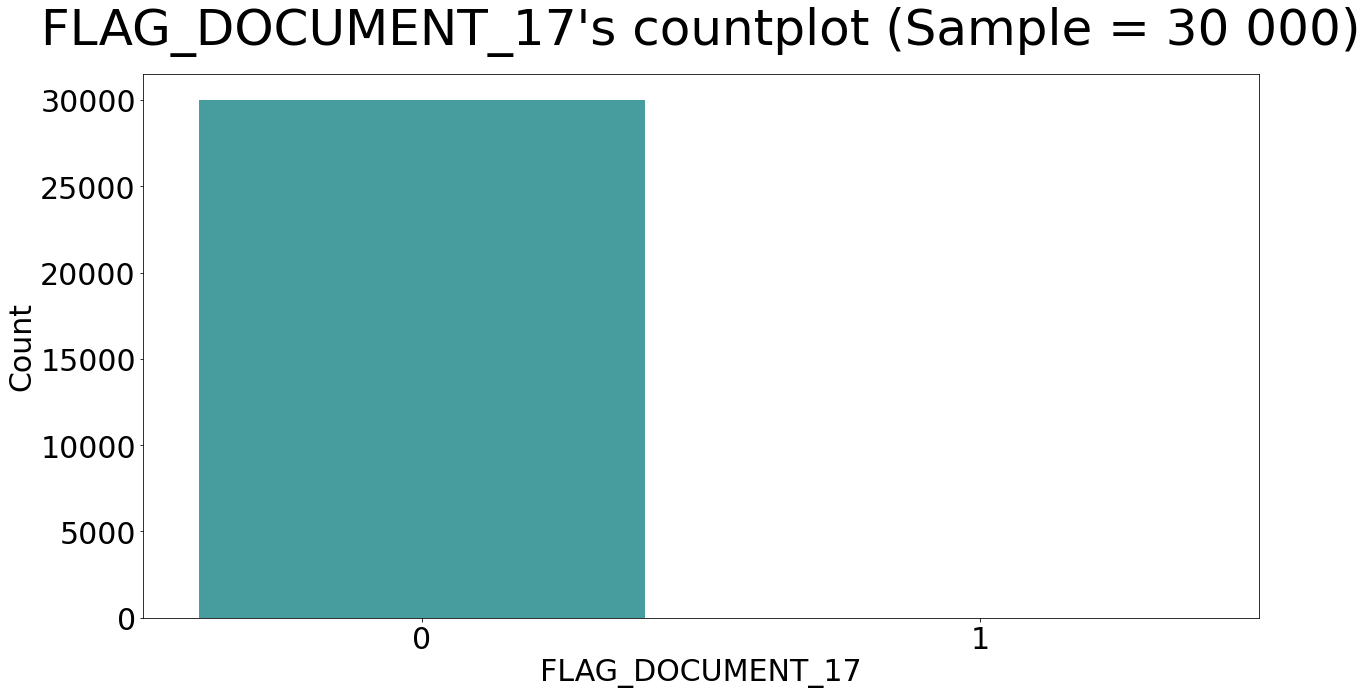

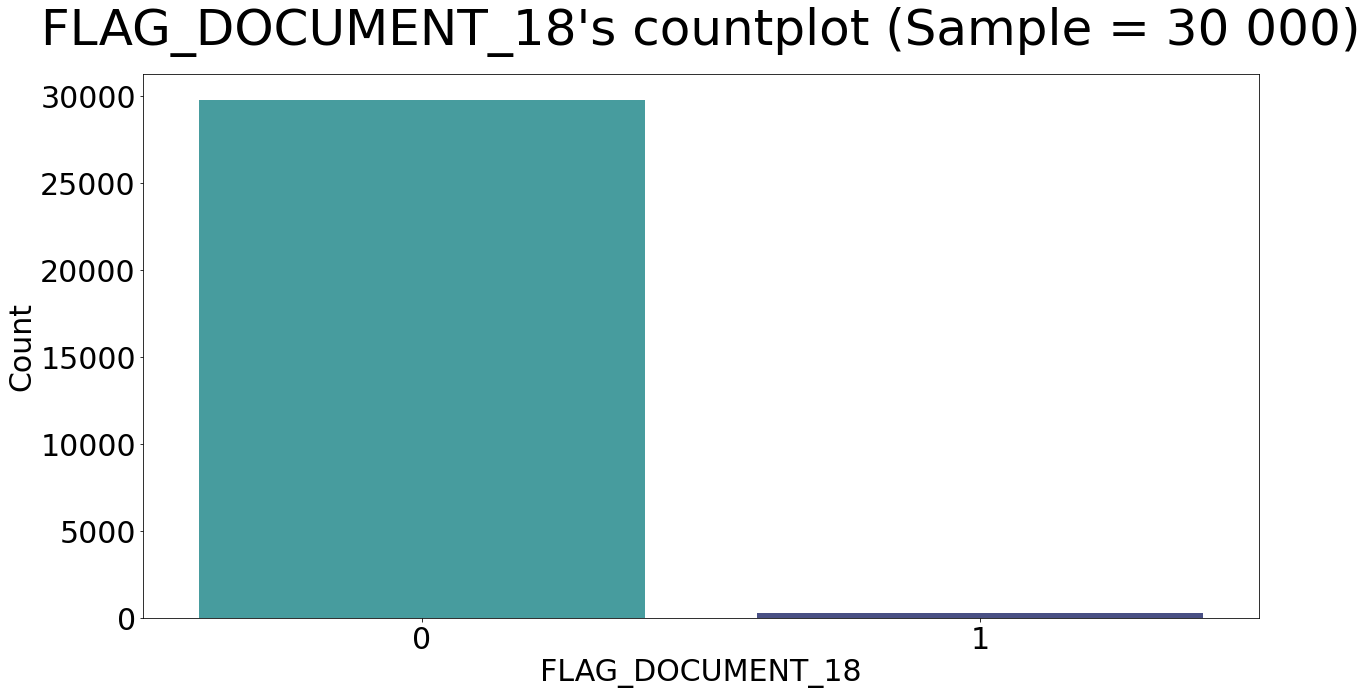

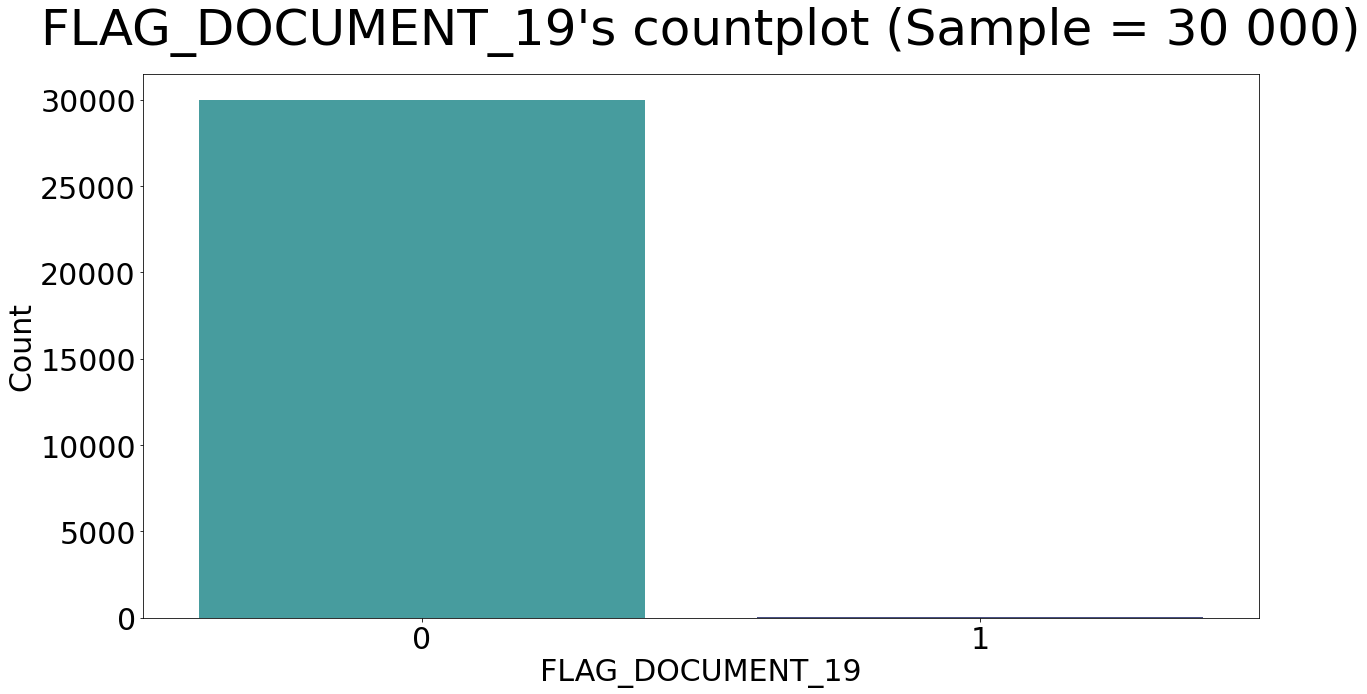

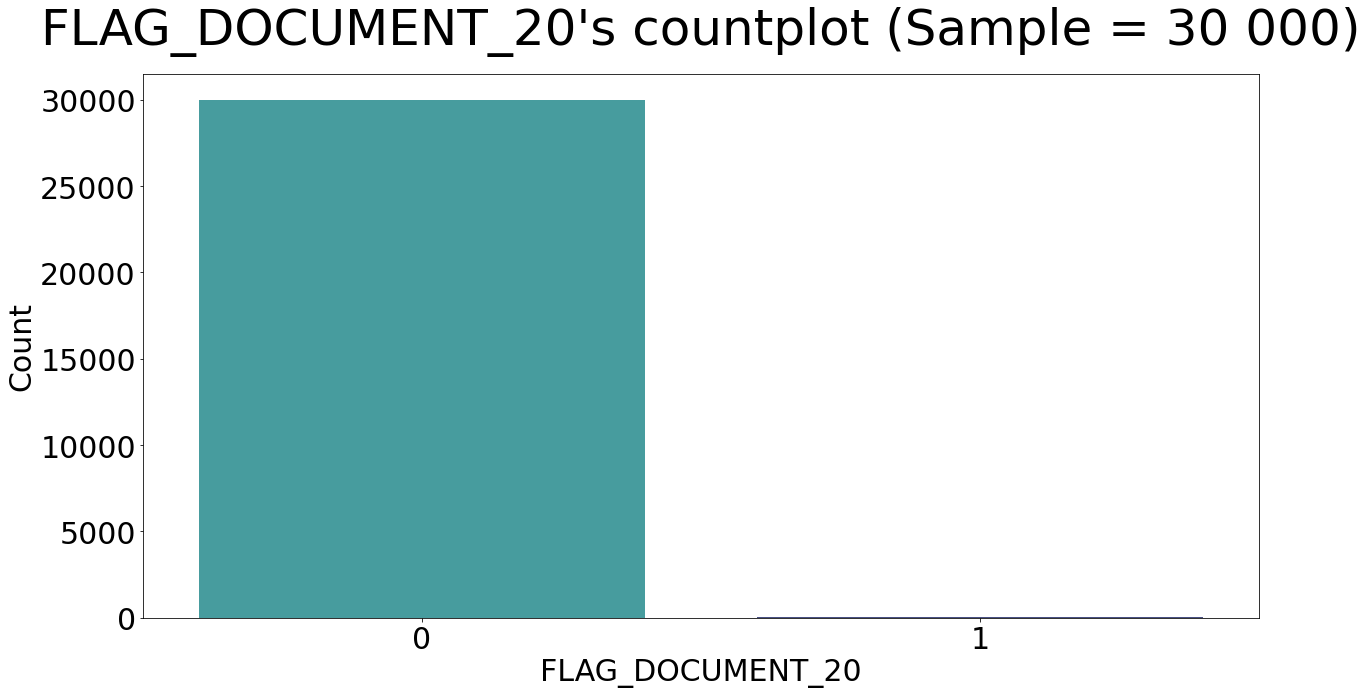

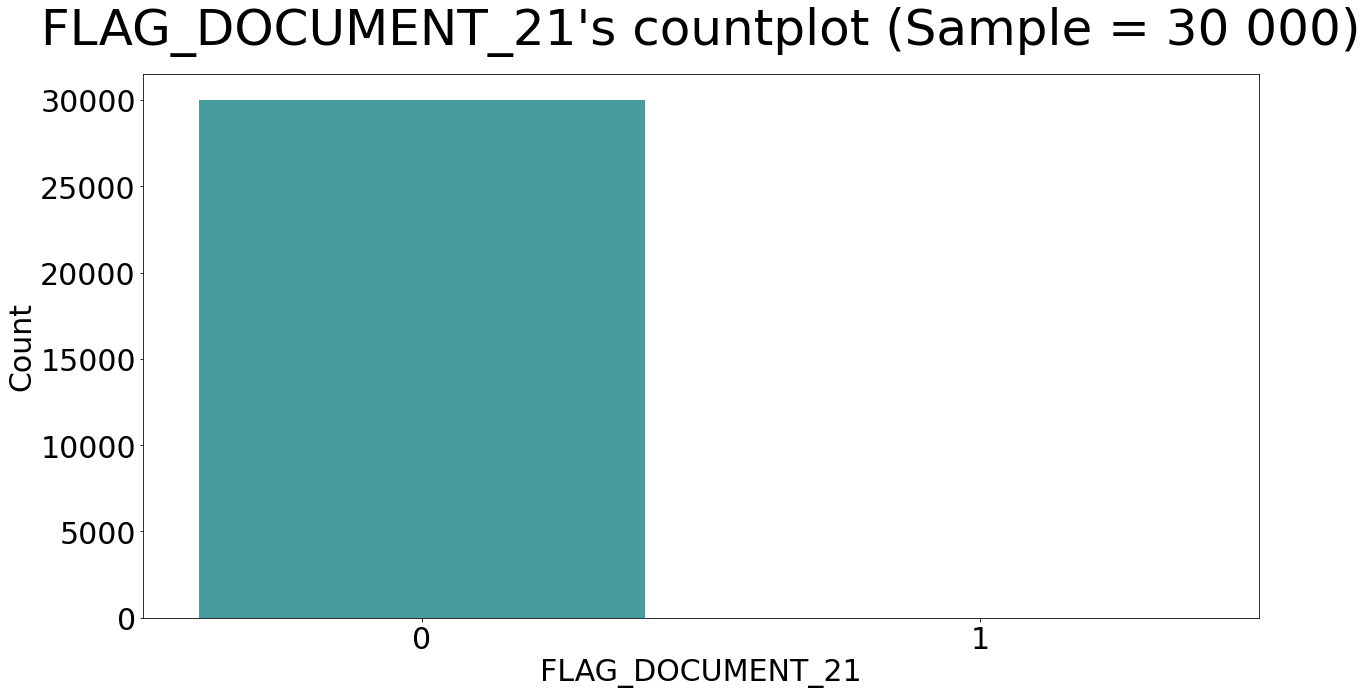

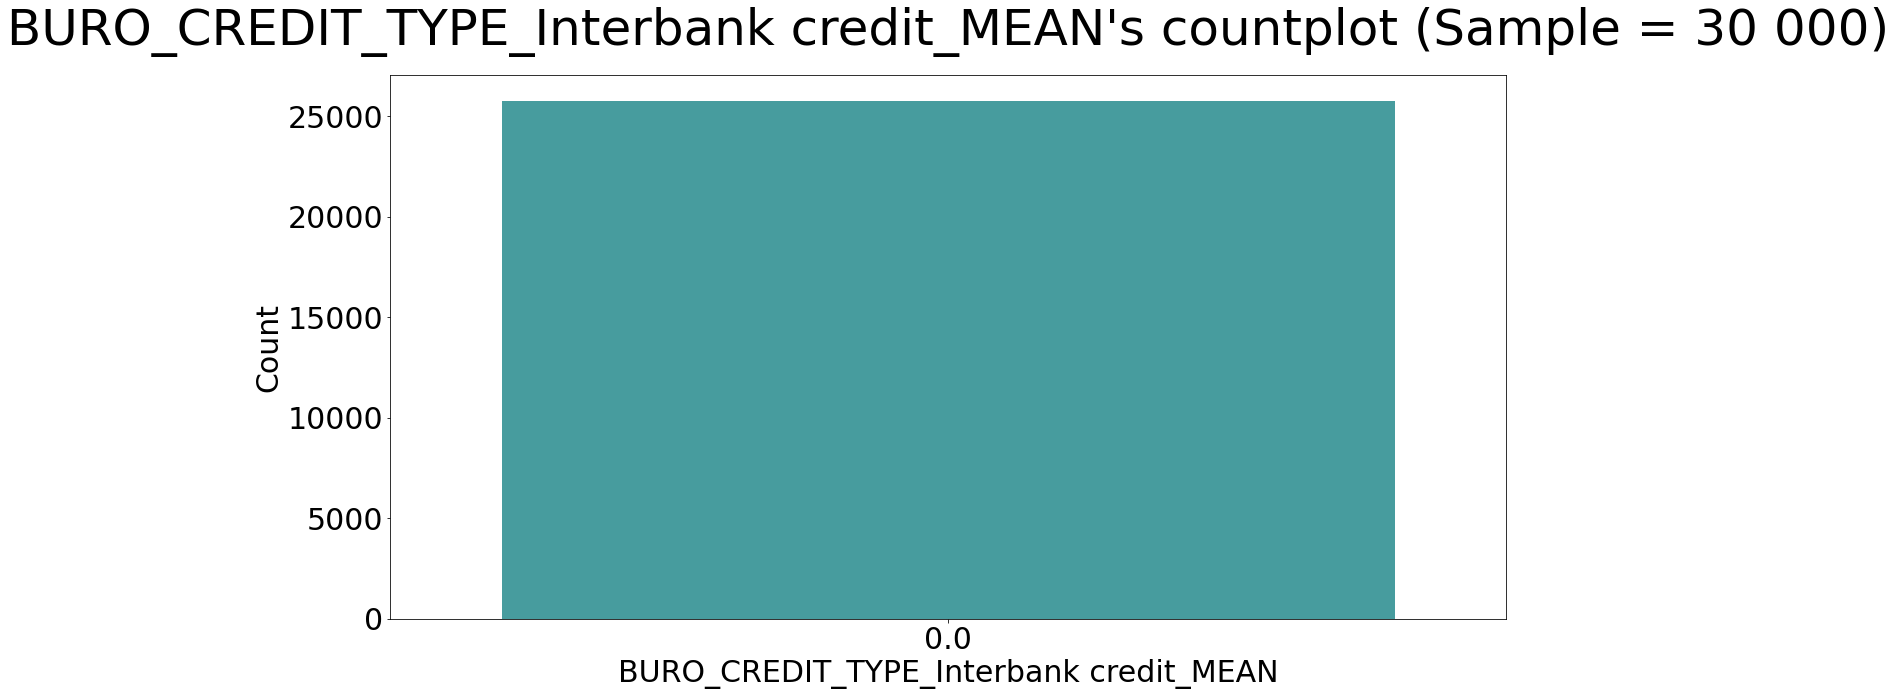

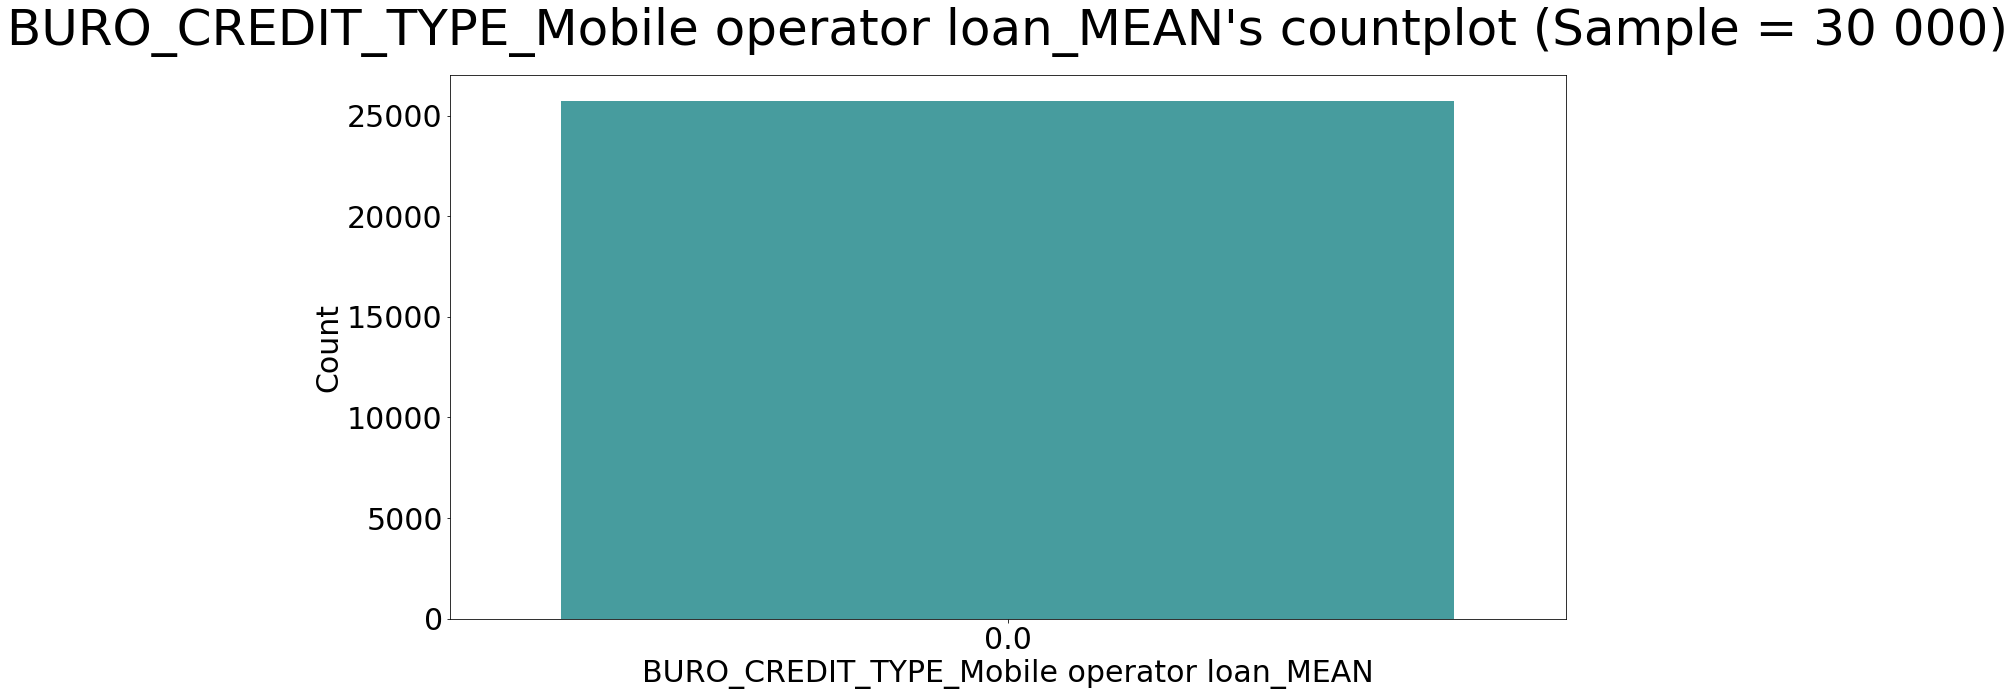

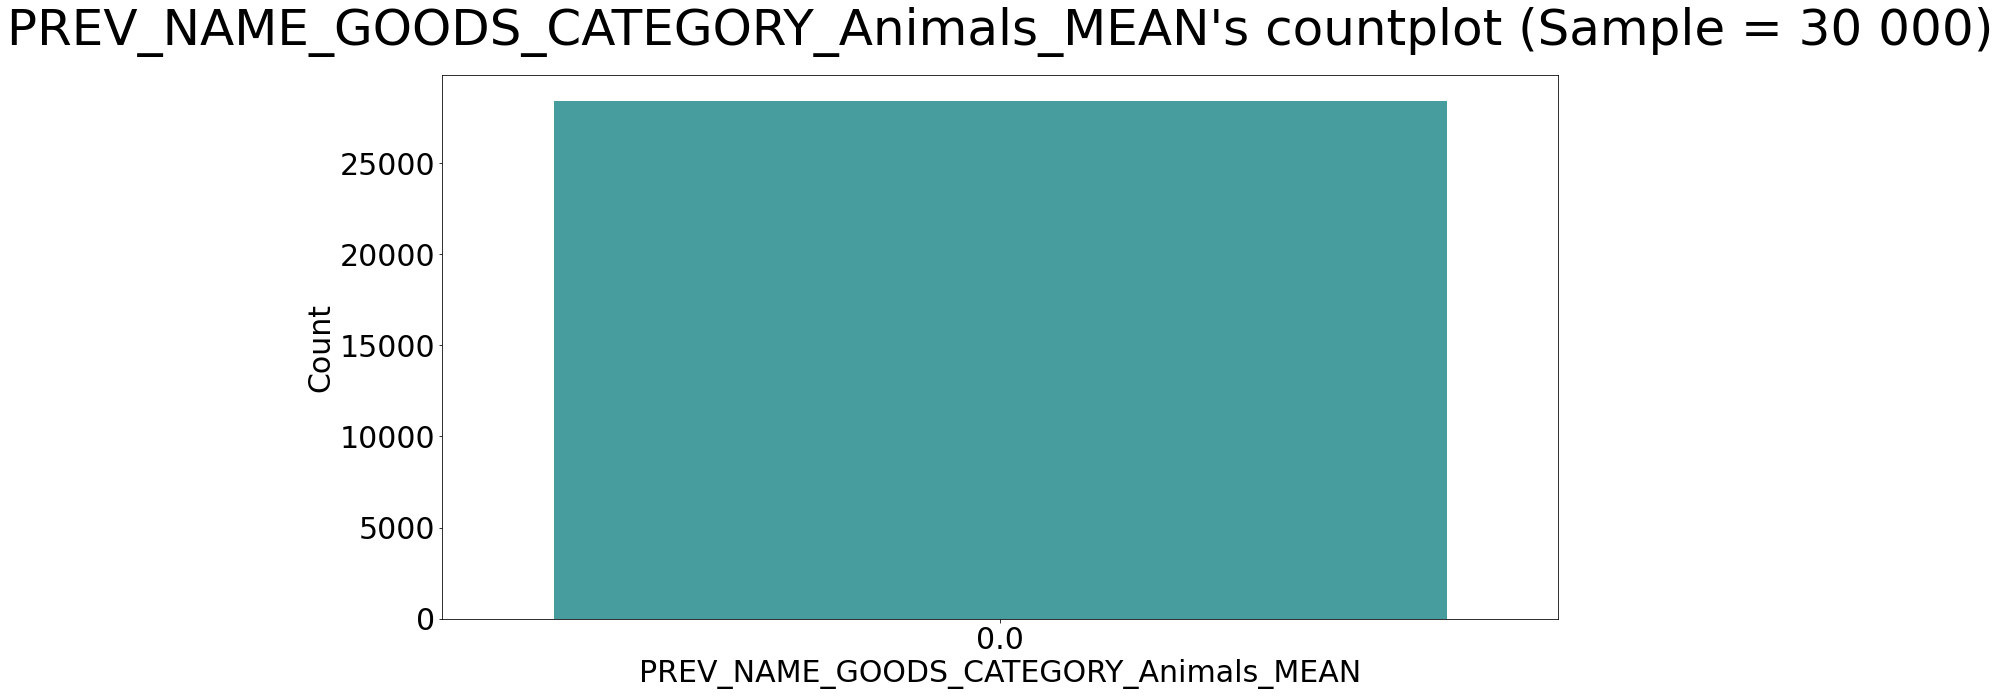

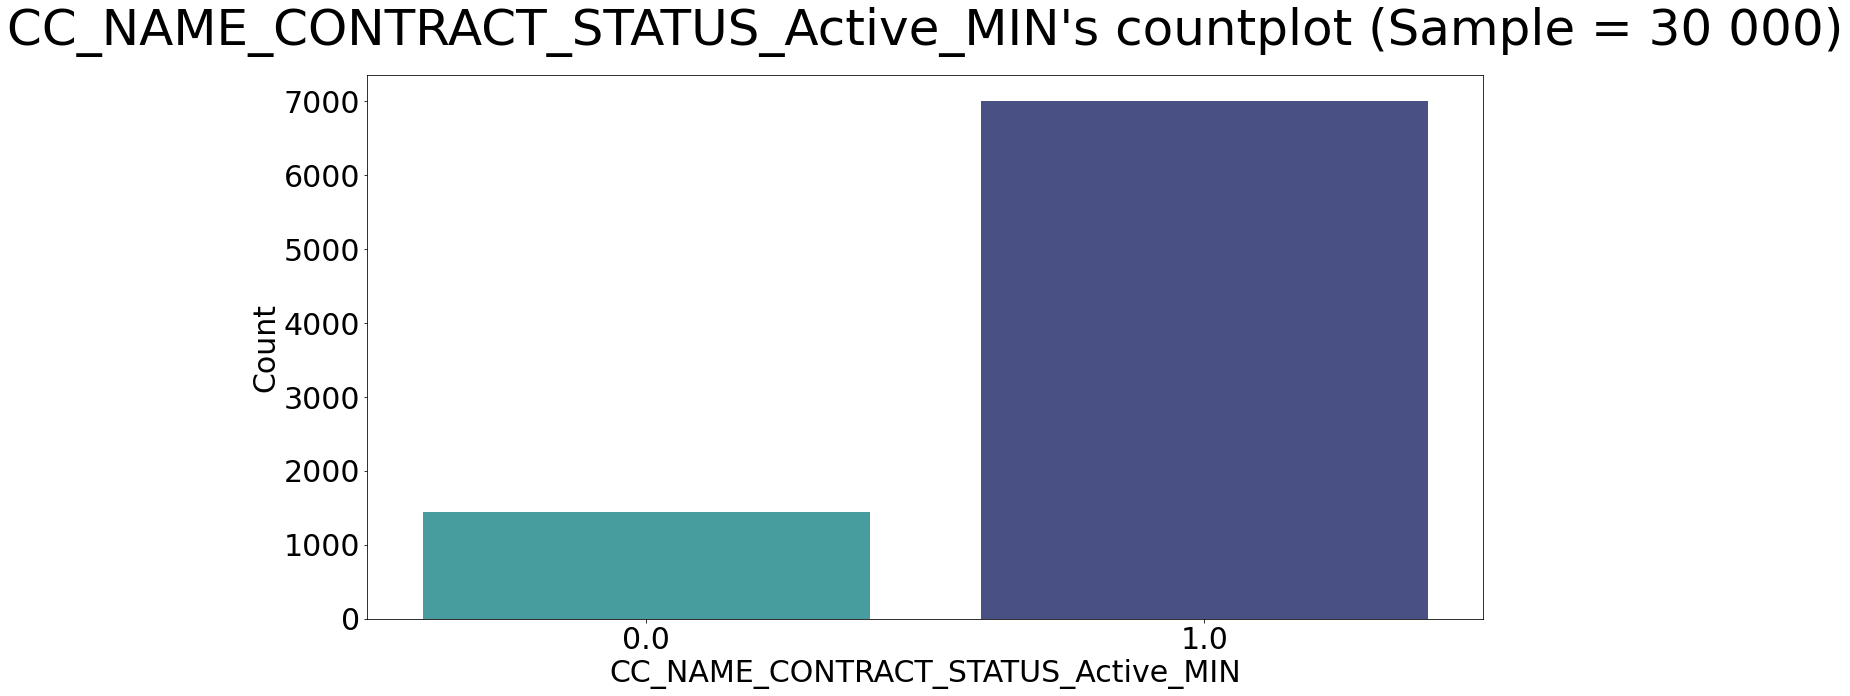

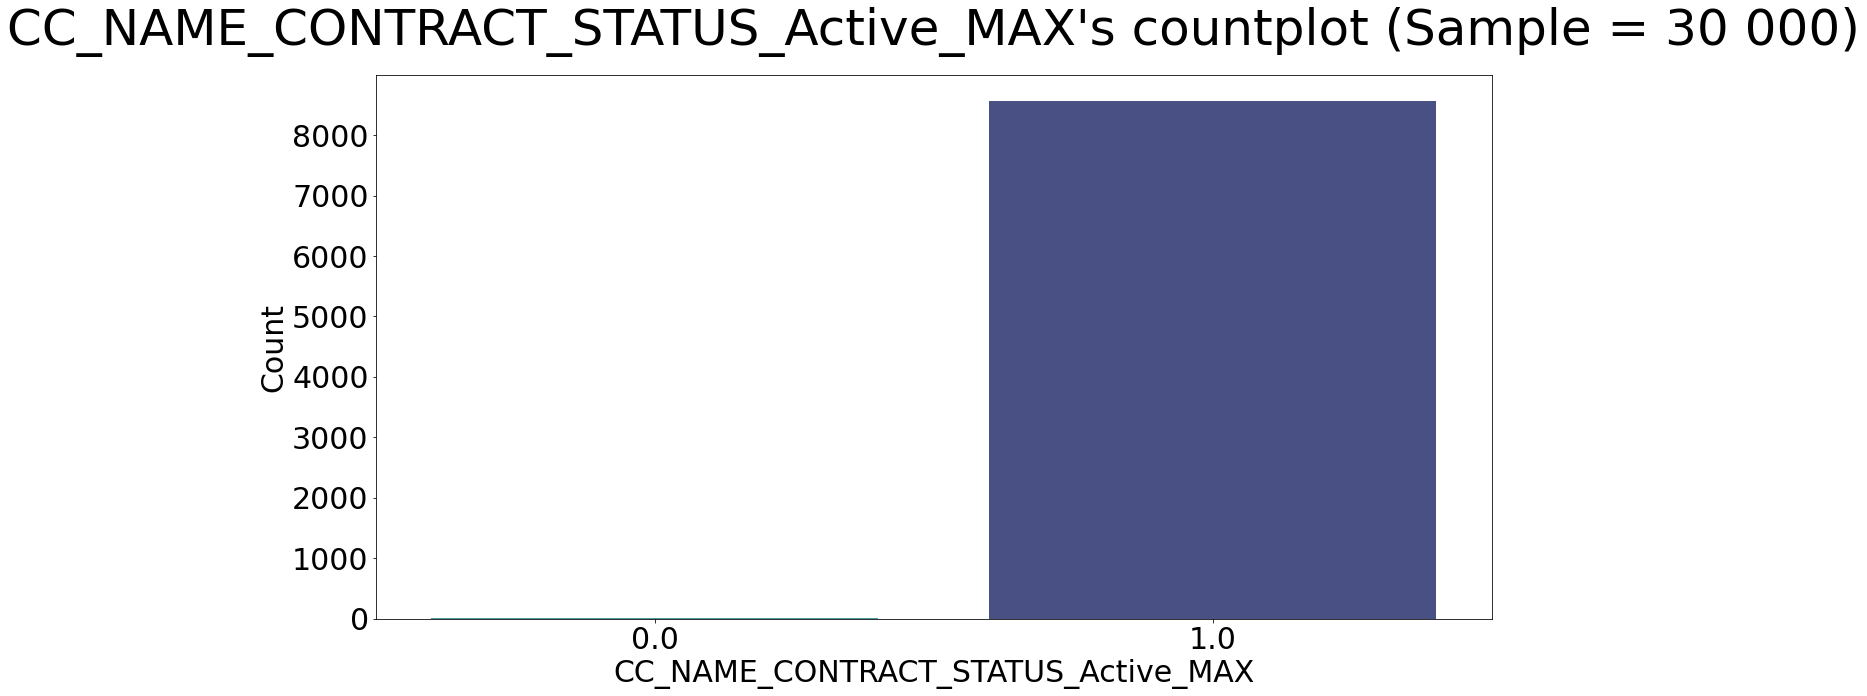

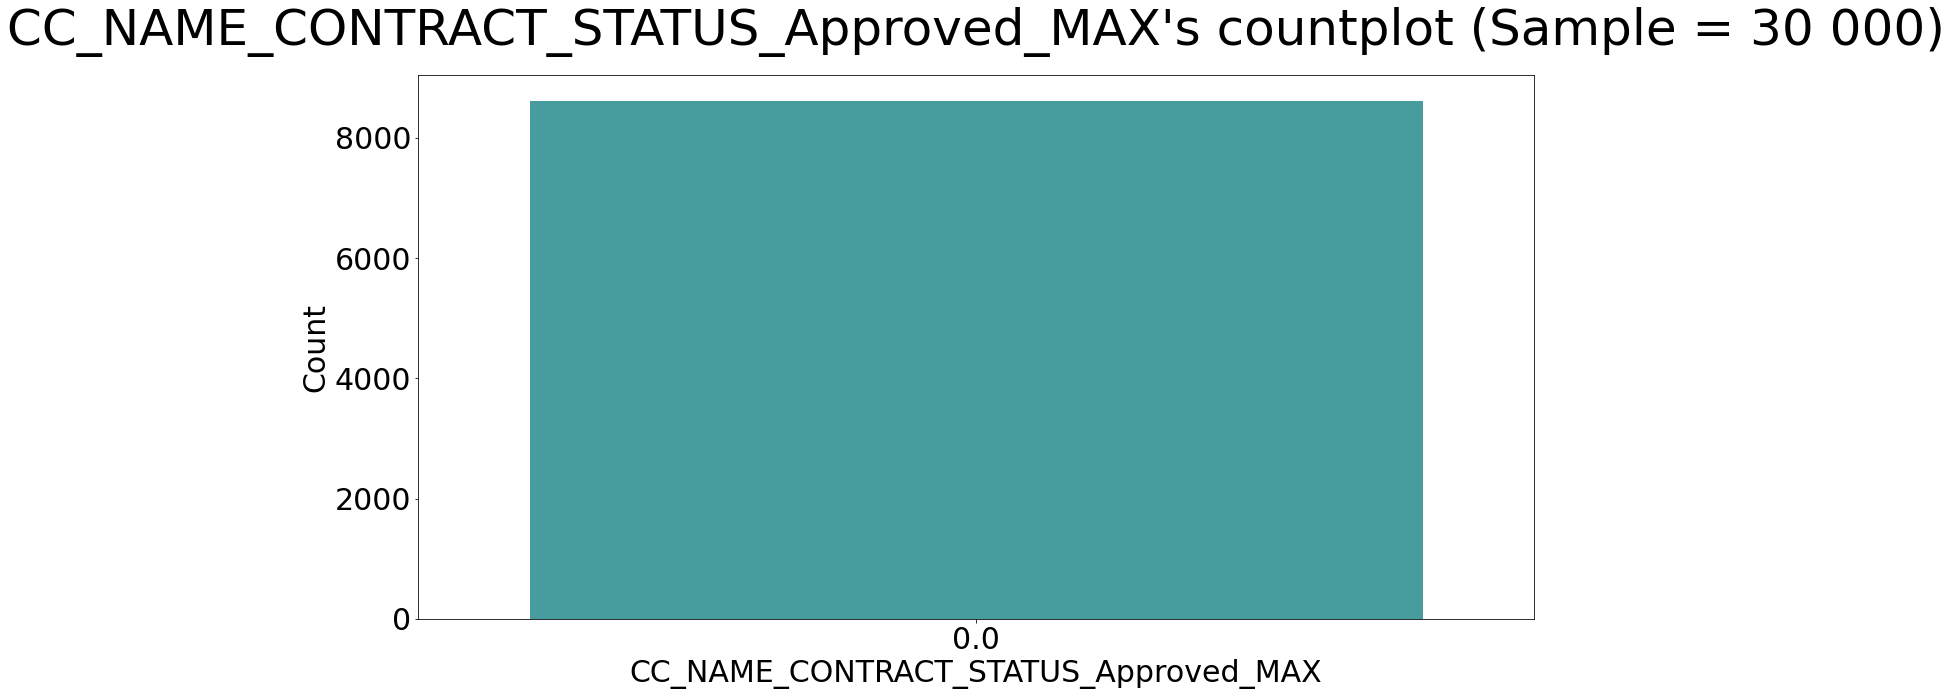

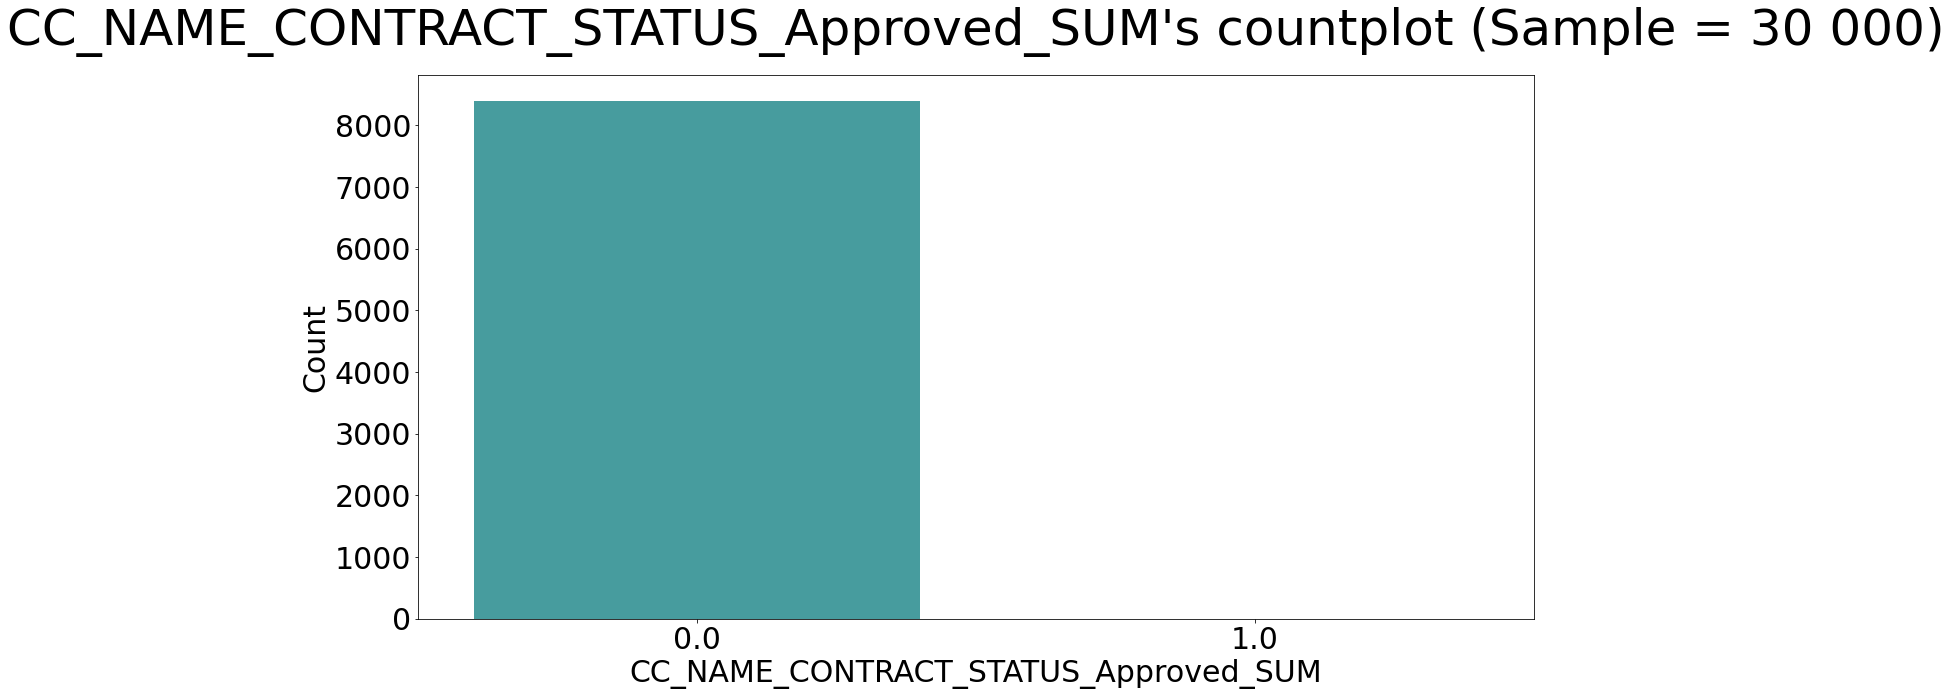

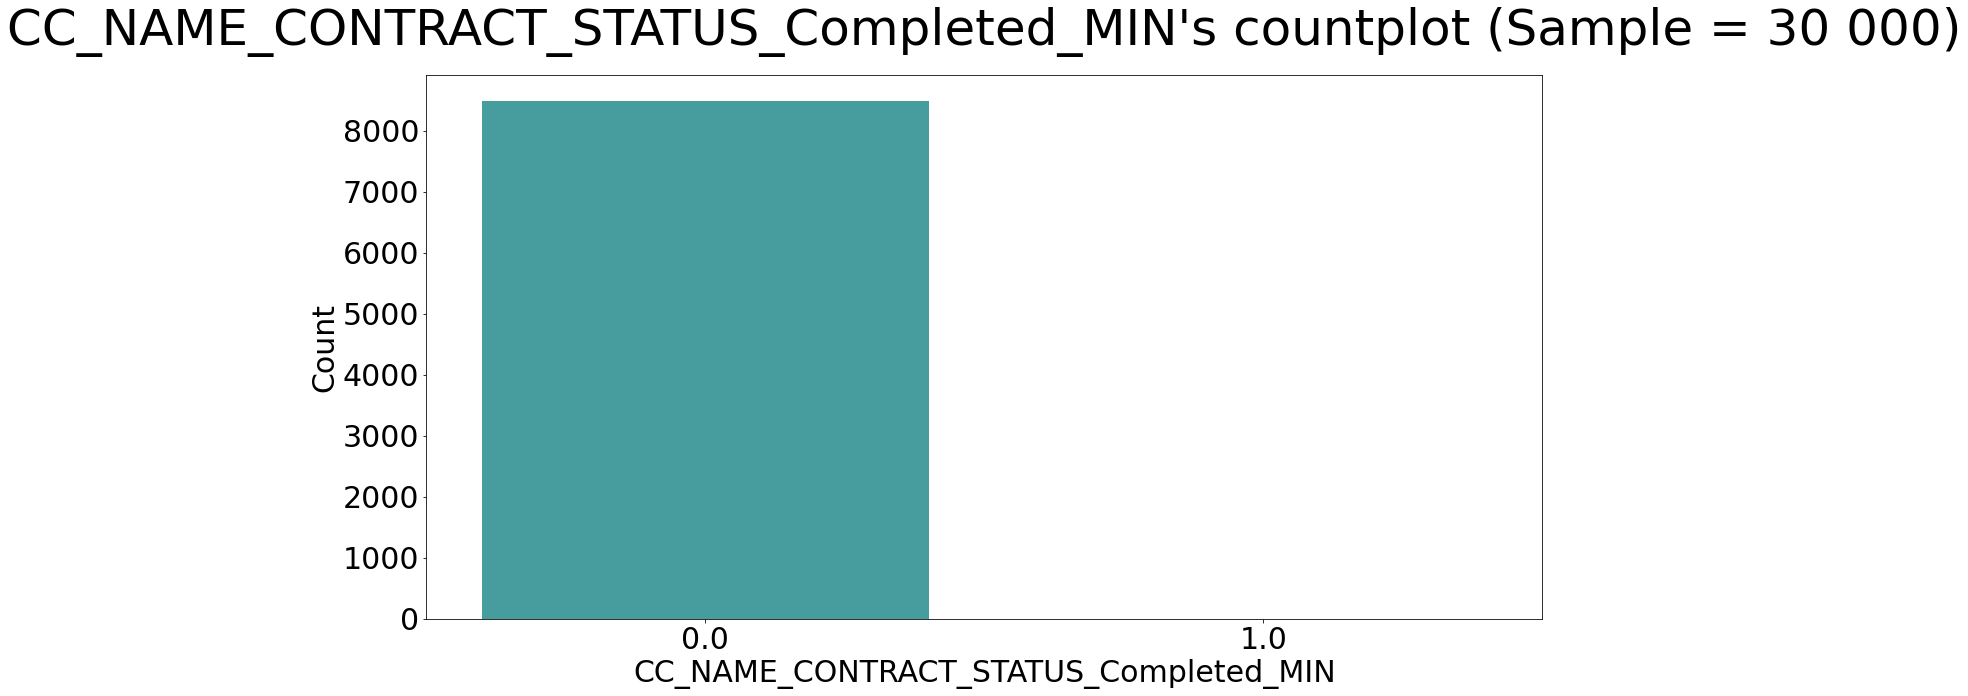

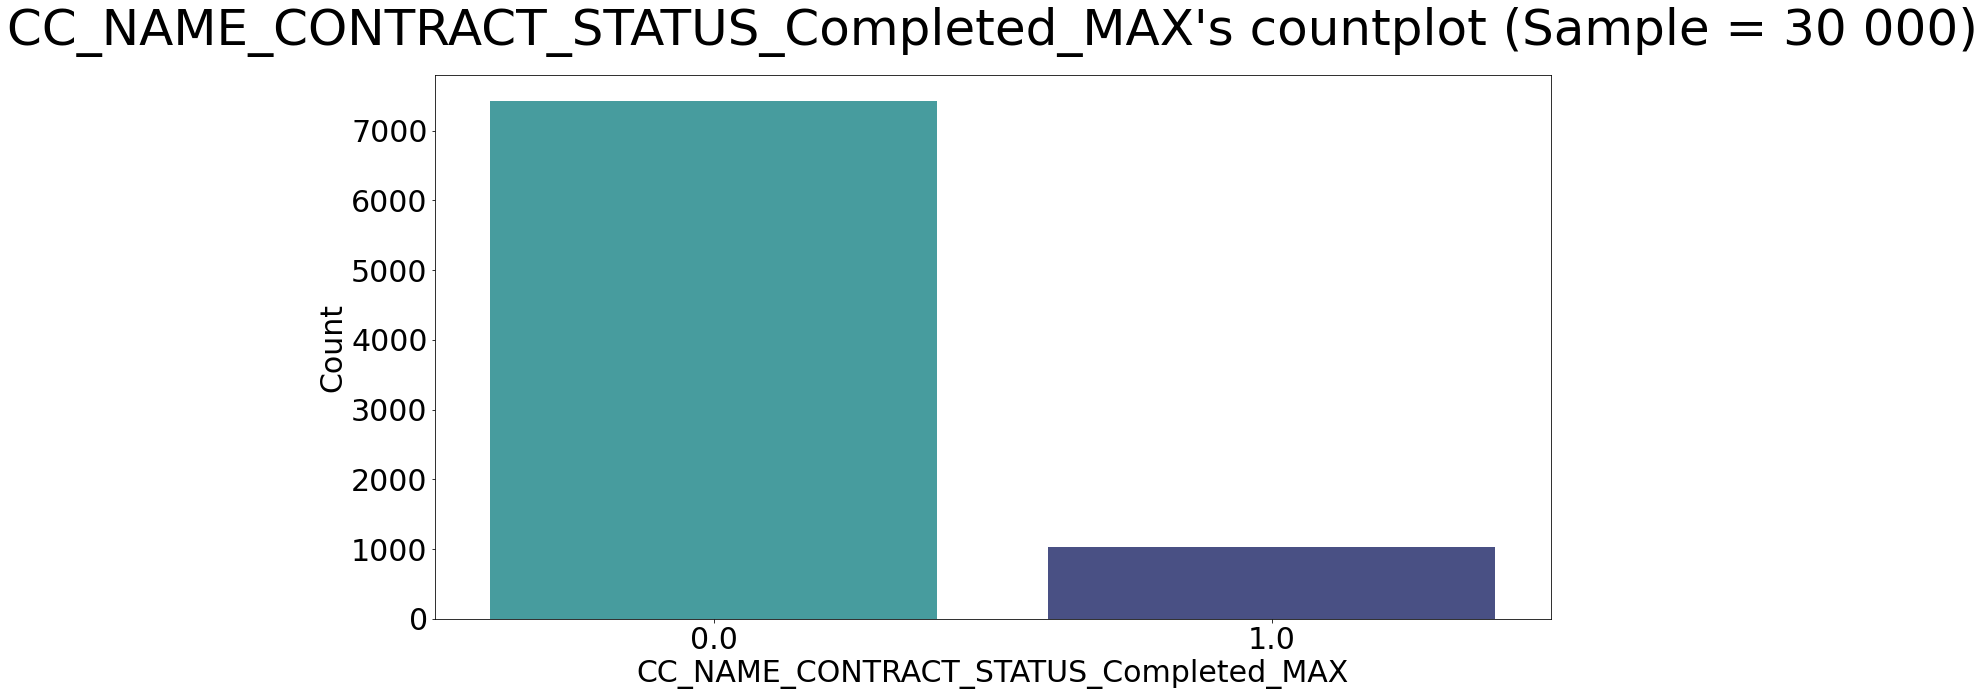

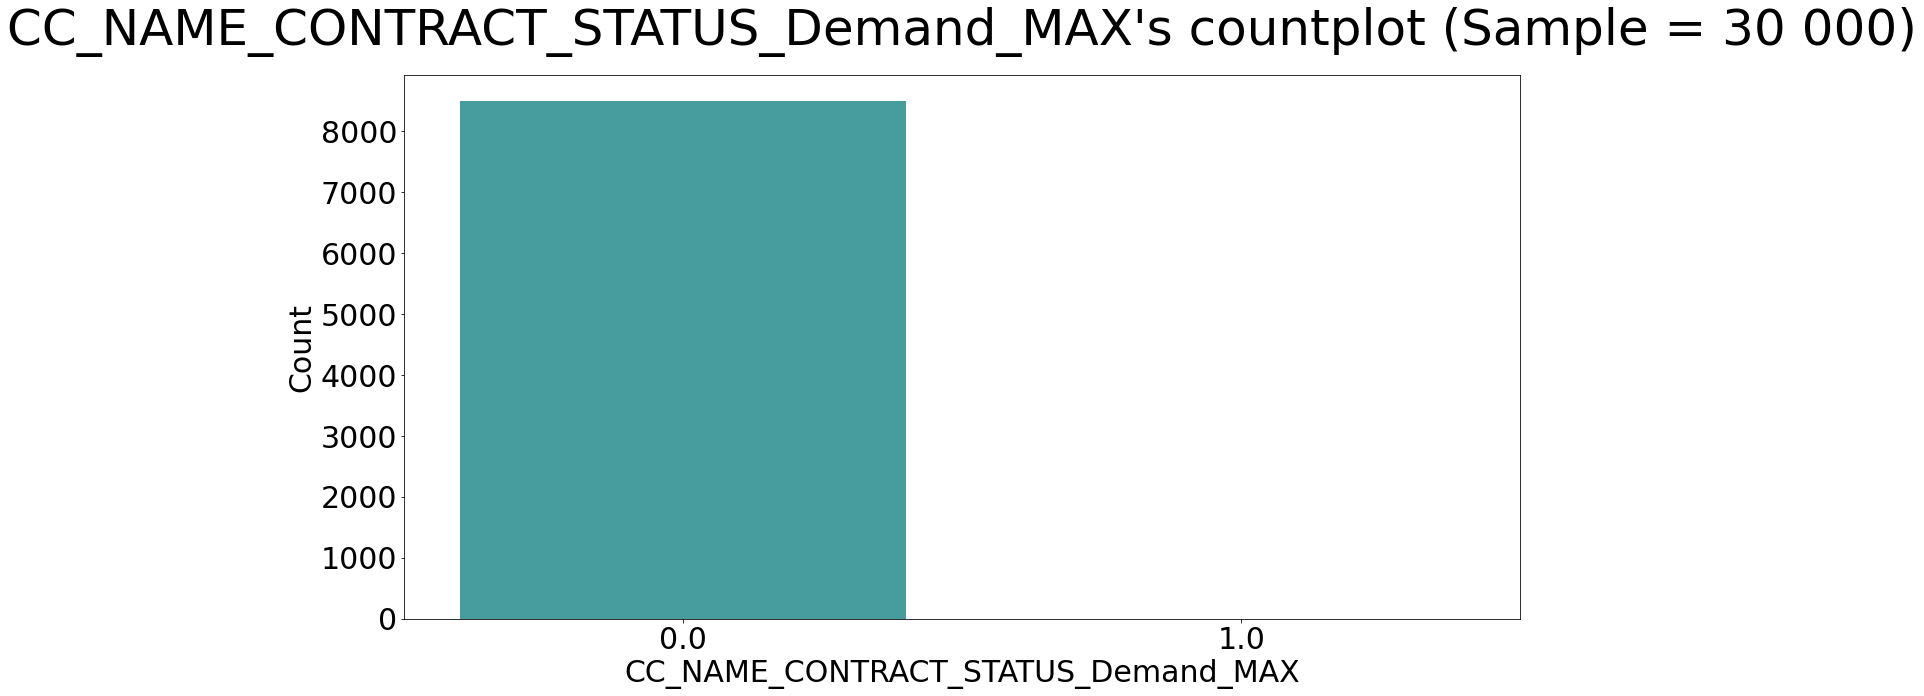

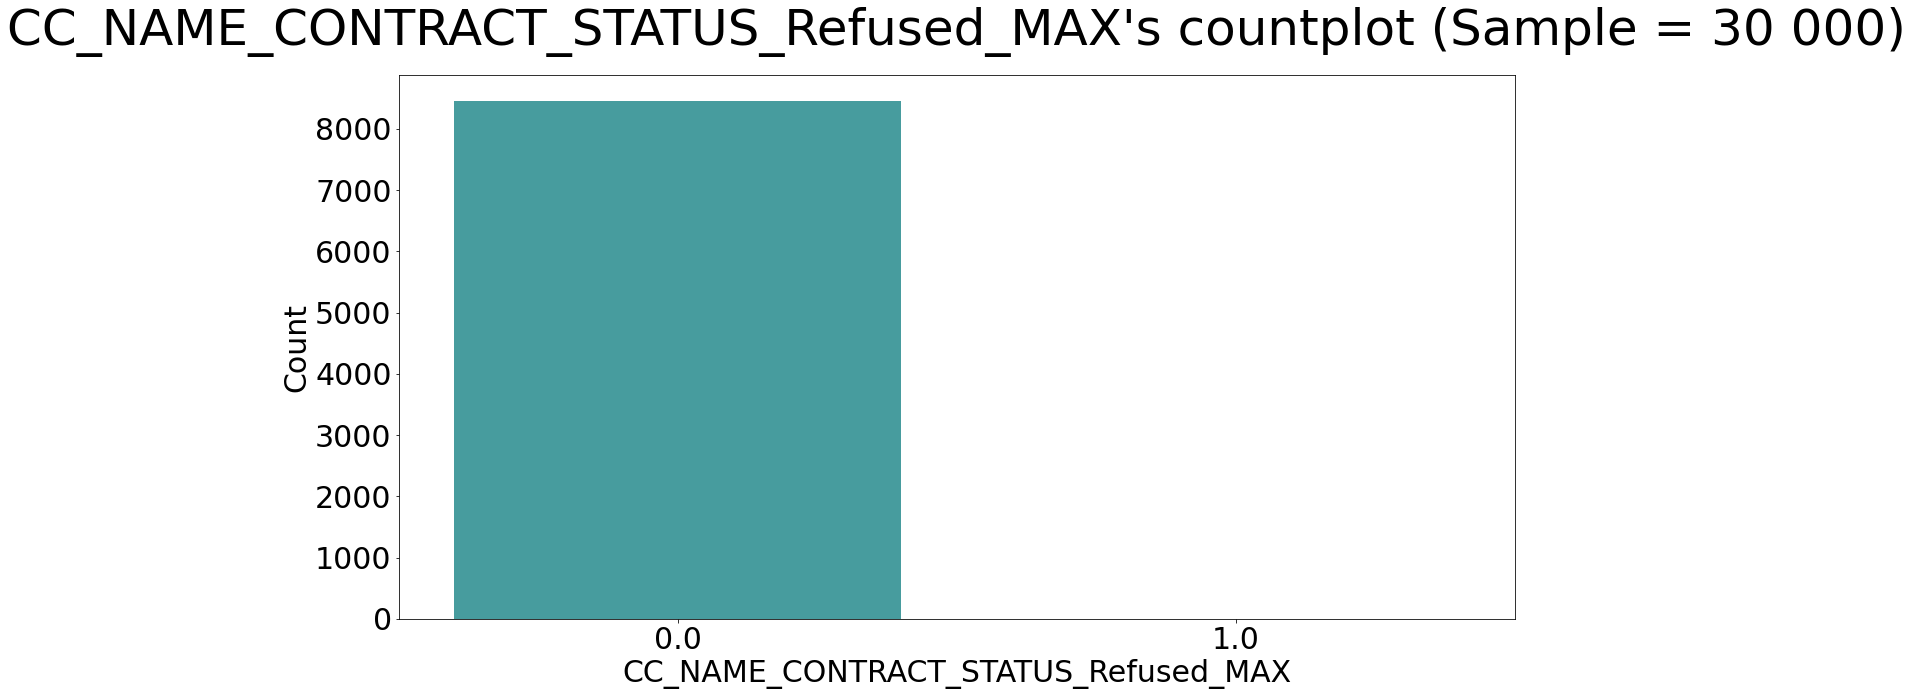

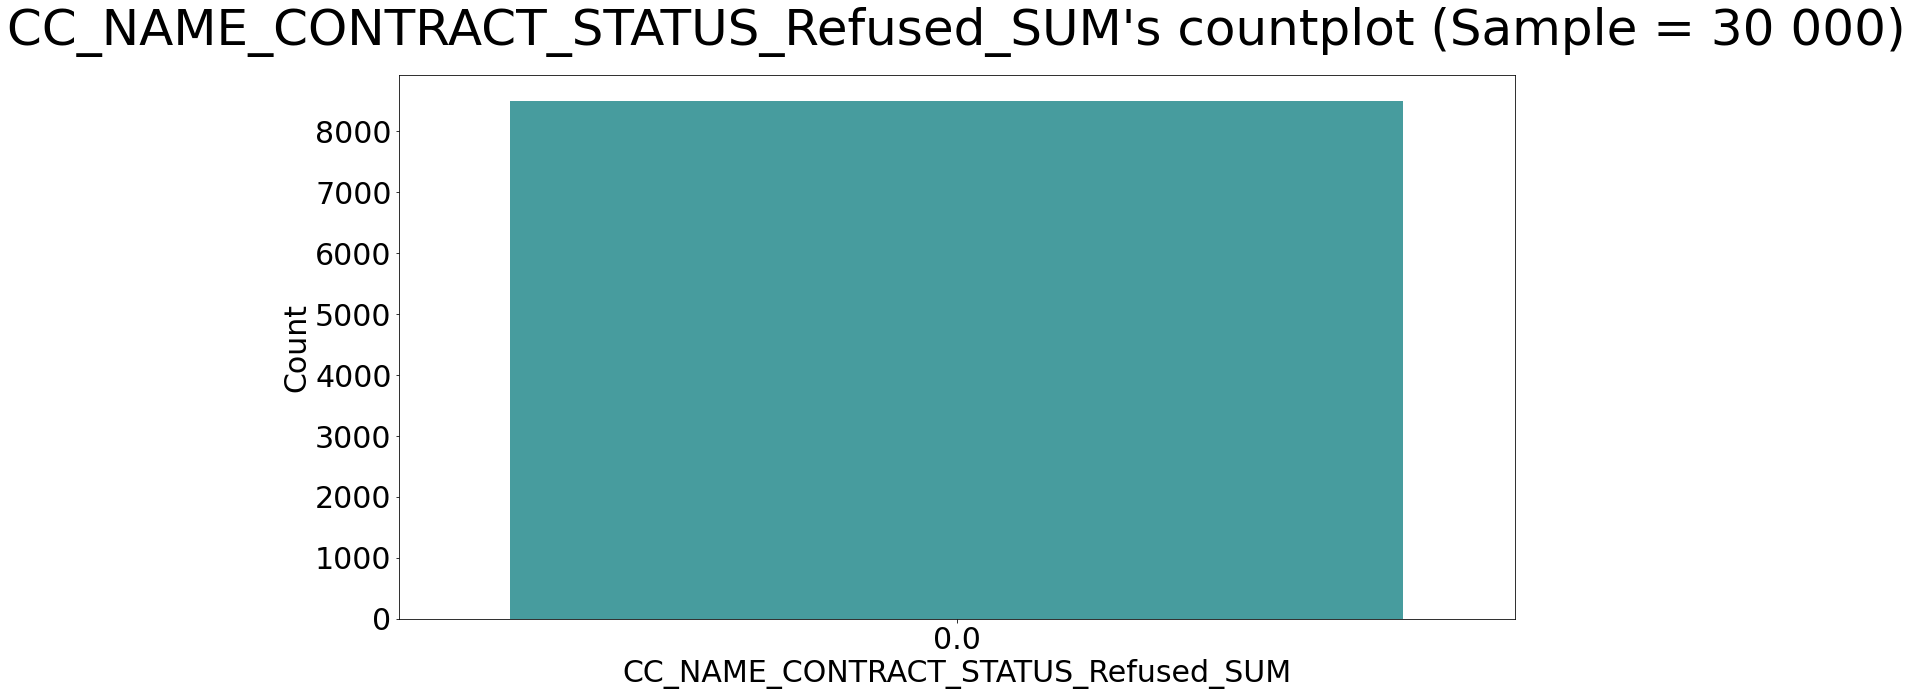

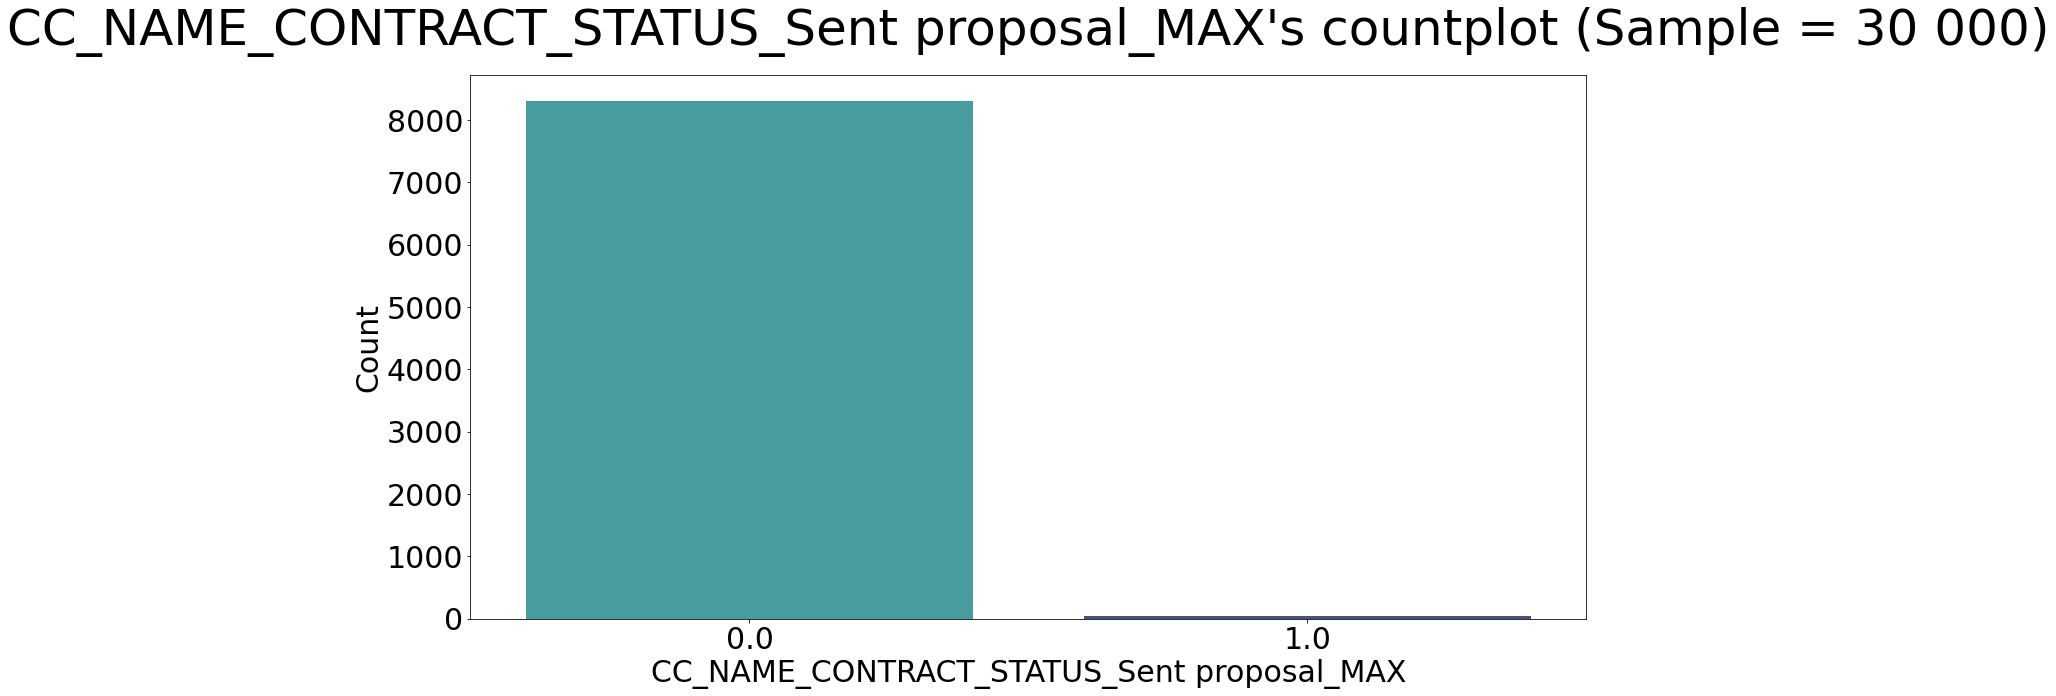

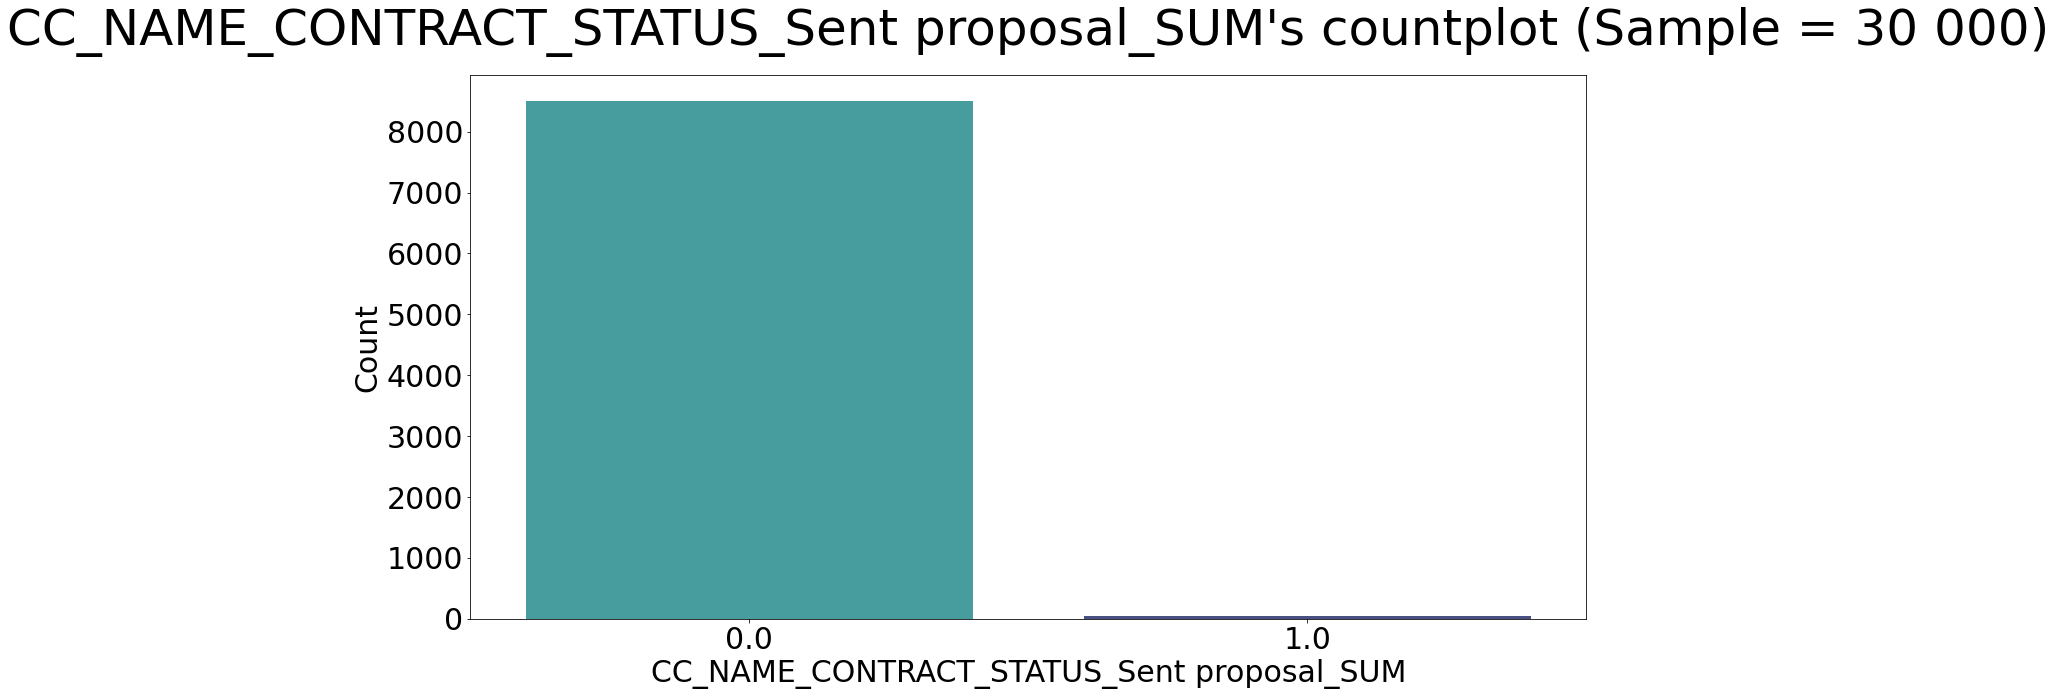

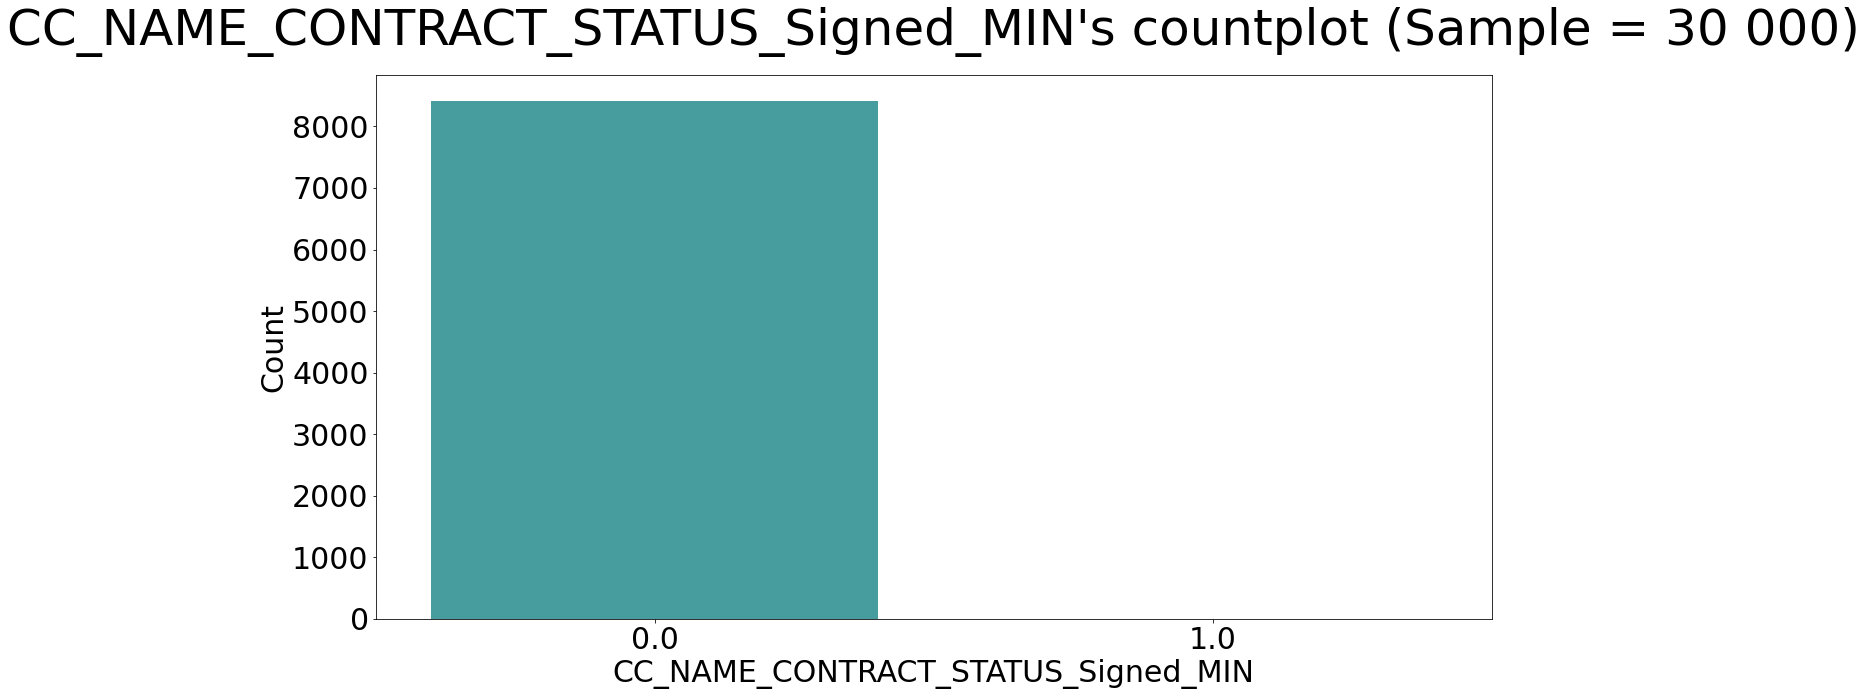

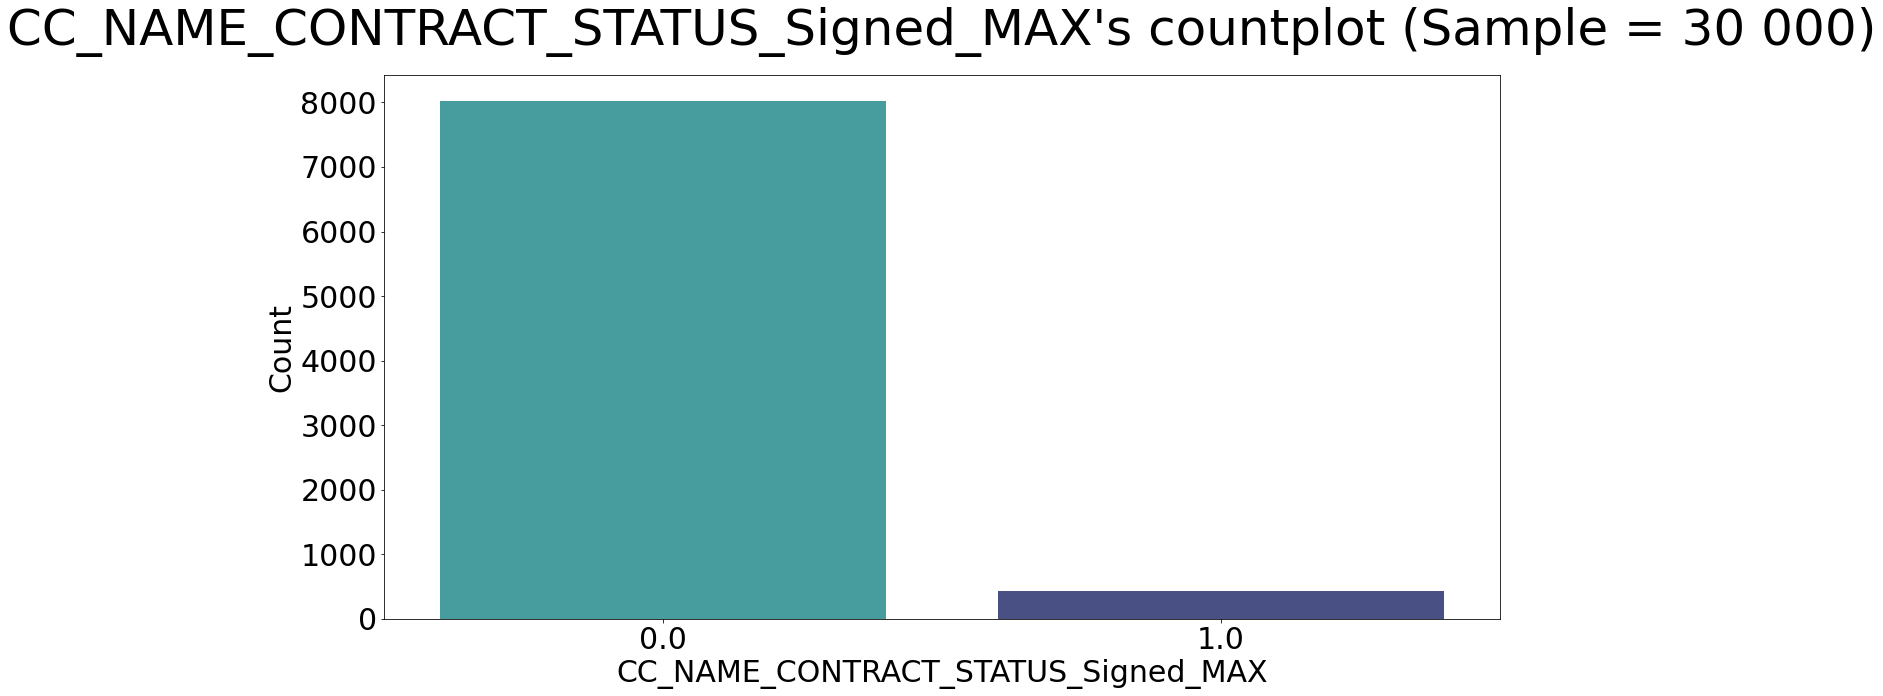

In [32]:
# Plots binomial features

for column_name in binary_types_columns:

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.countplot(data=application_train_untargeted.sample(30000),
                  x=column_name,
                  palette=sns.color_palette('mako_r', 2),
                  ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel(column_name, fontsize=text_size)
    ax.set_ylabel('Count', fontsize=text_size)

    plt.title('{}\'s countplot (Sample = 30 000)'.format(column_name),
              fontsize=title_size,
              pad=30)
        
    plt.show();
        
plt.show();

# Plots numrical (non binomial) features 

for column_name in numerical_not_binary_columns:

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.histplot(data=application_train_untargeted.sample(1000),
                     x=column_name,
                     kde=True,
                     color=sns.color_palette('mako_r')[3],
                     ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel(column_name, fontsize=text_size)
    ax.set_ylabel('Count', fontsize=text_size)

    plt.title('{}\'s countplot (Sample = 1000)'.format(column_name),
              fontsize=title_size,
              pad=30)
        
    plt.show();
        
plt.show();

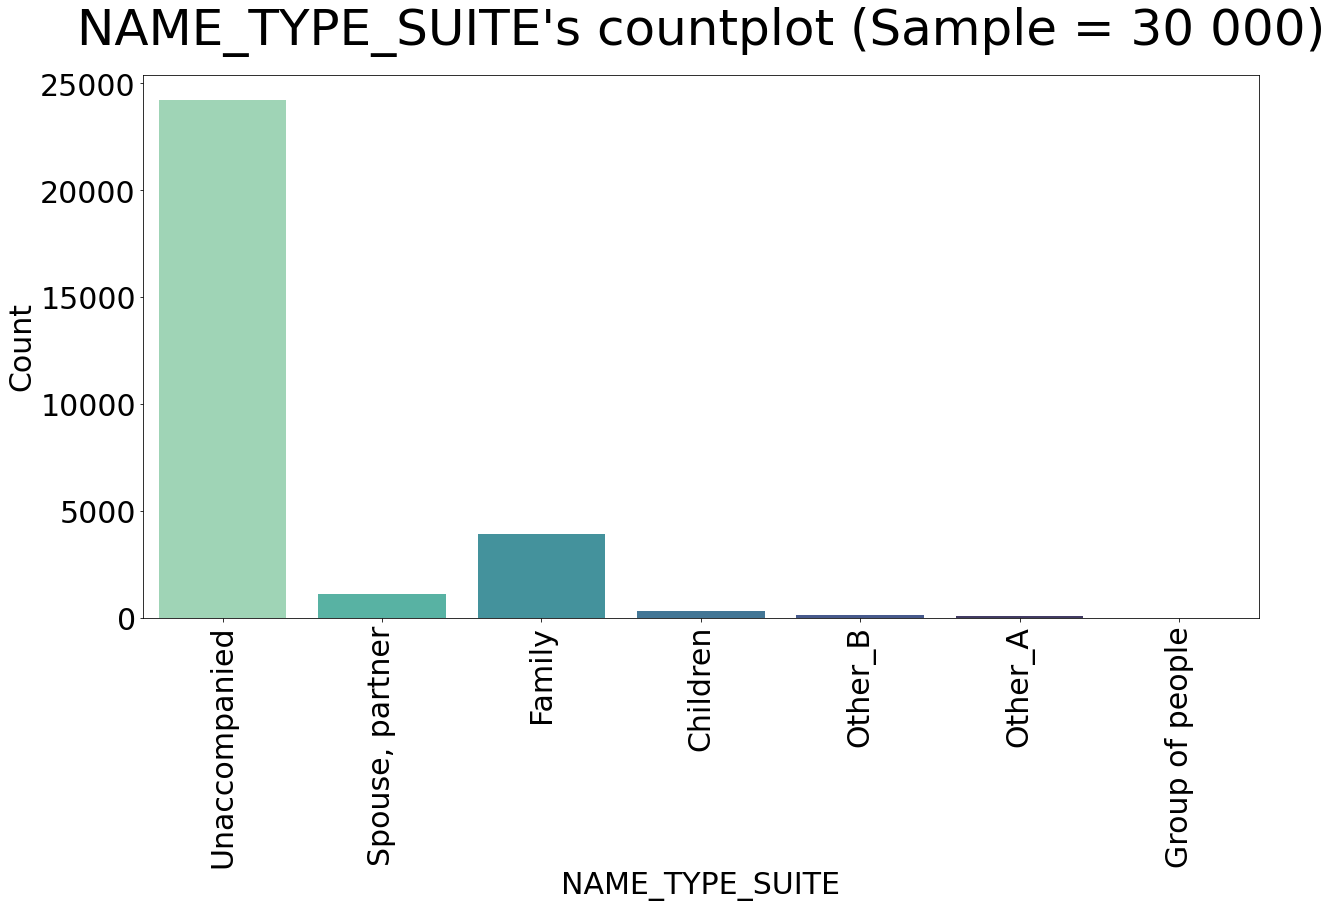

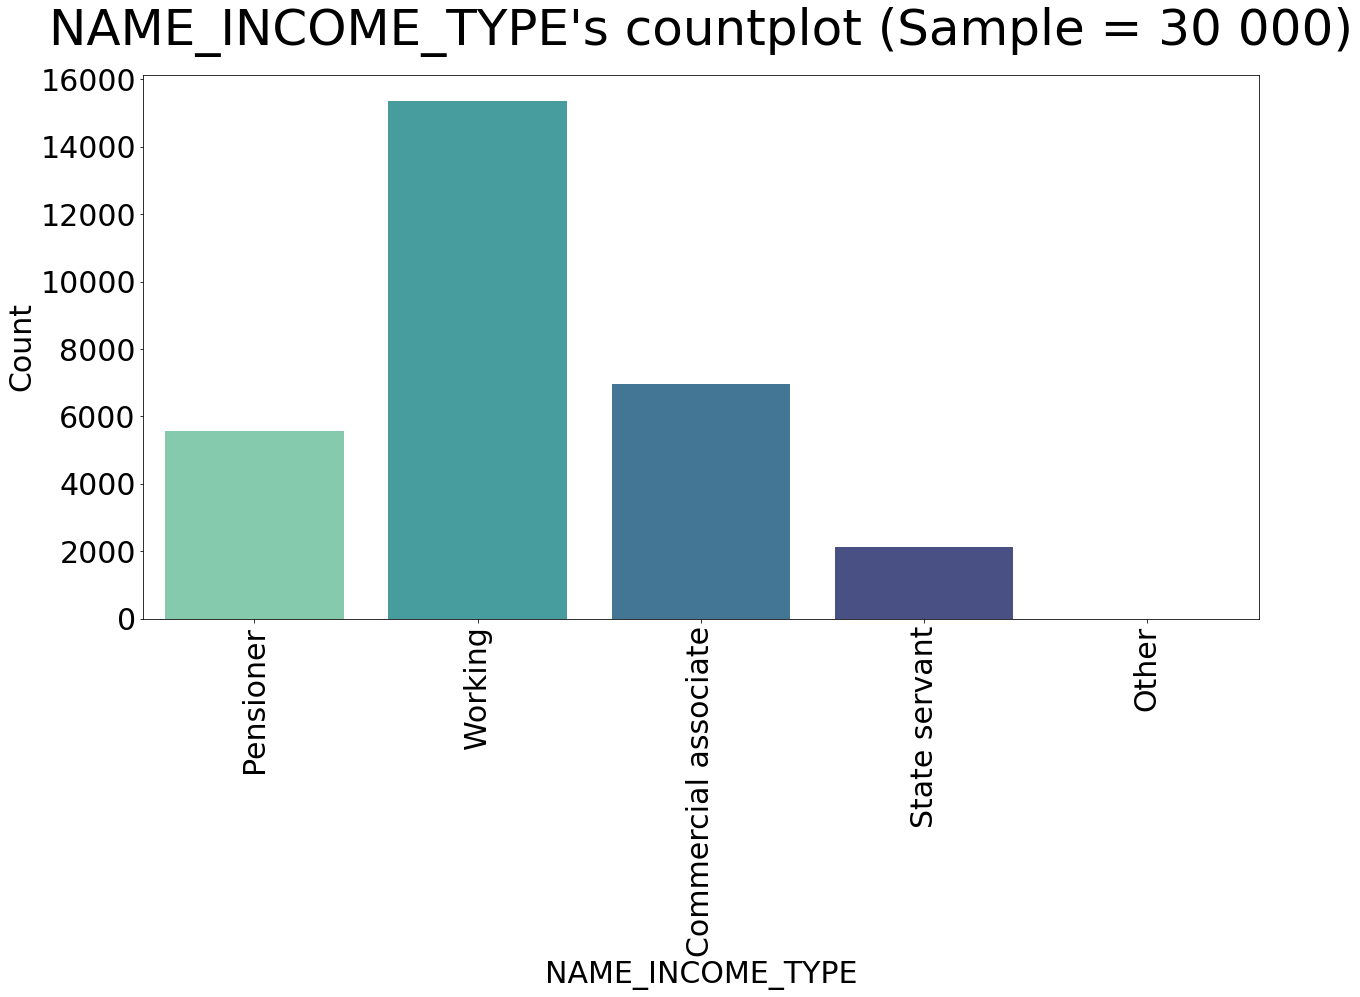

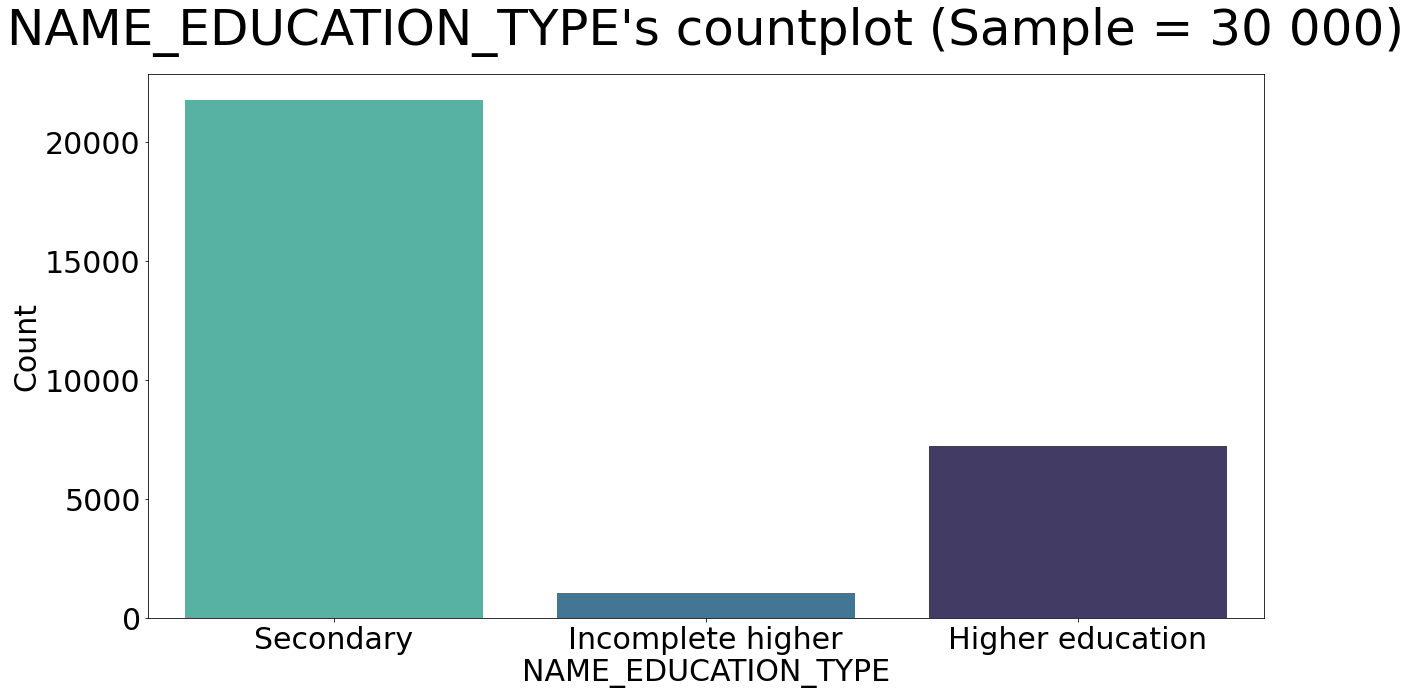

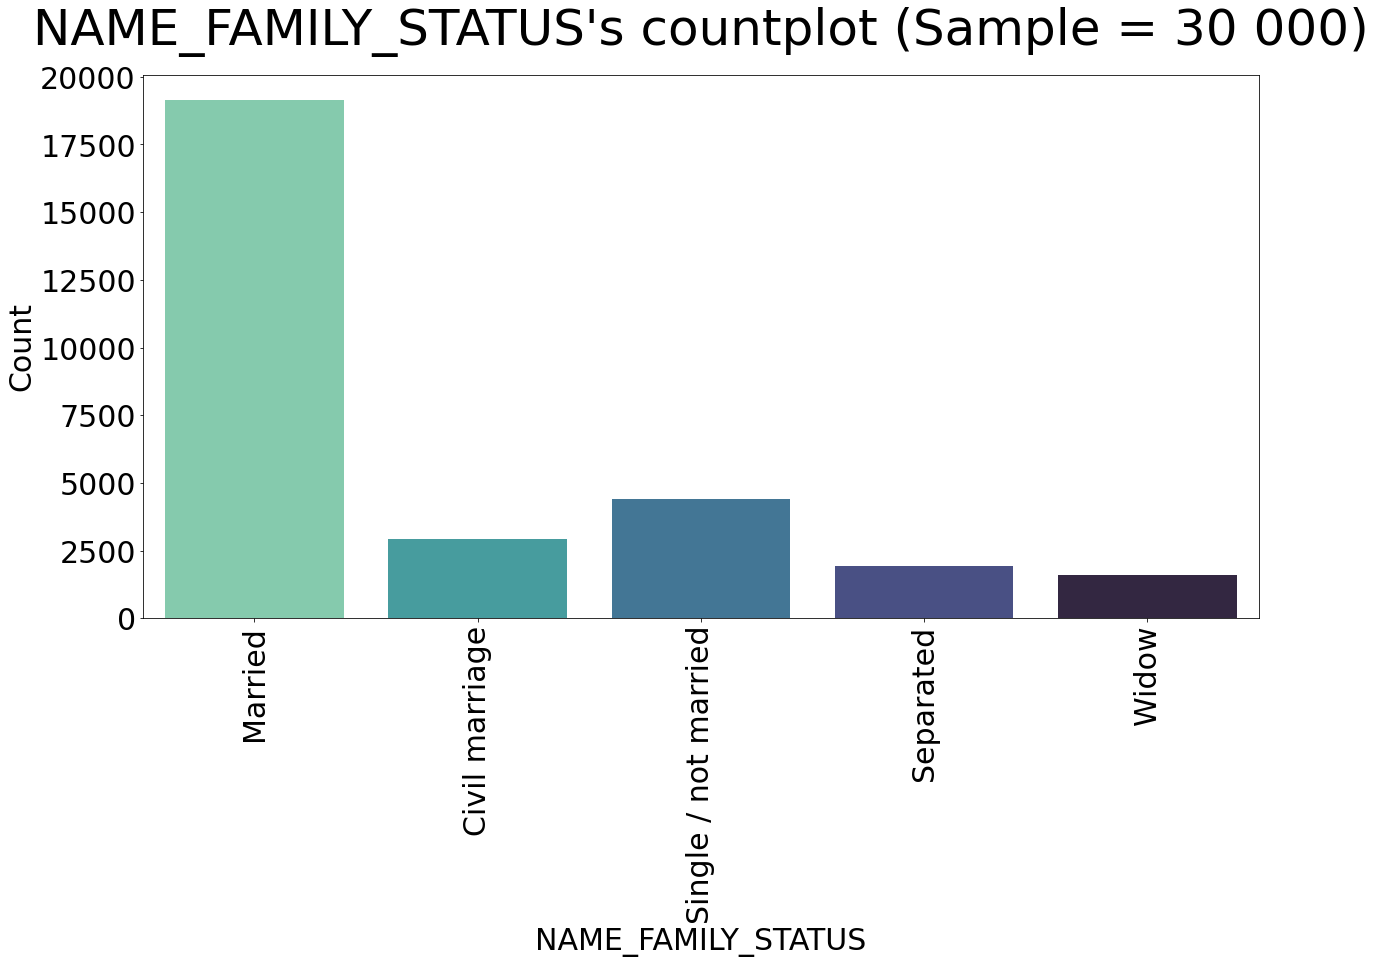

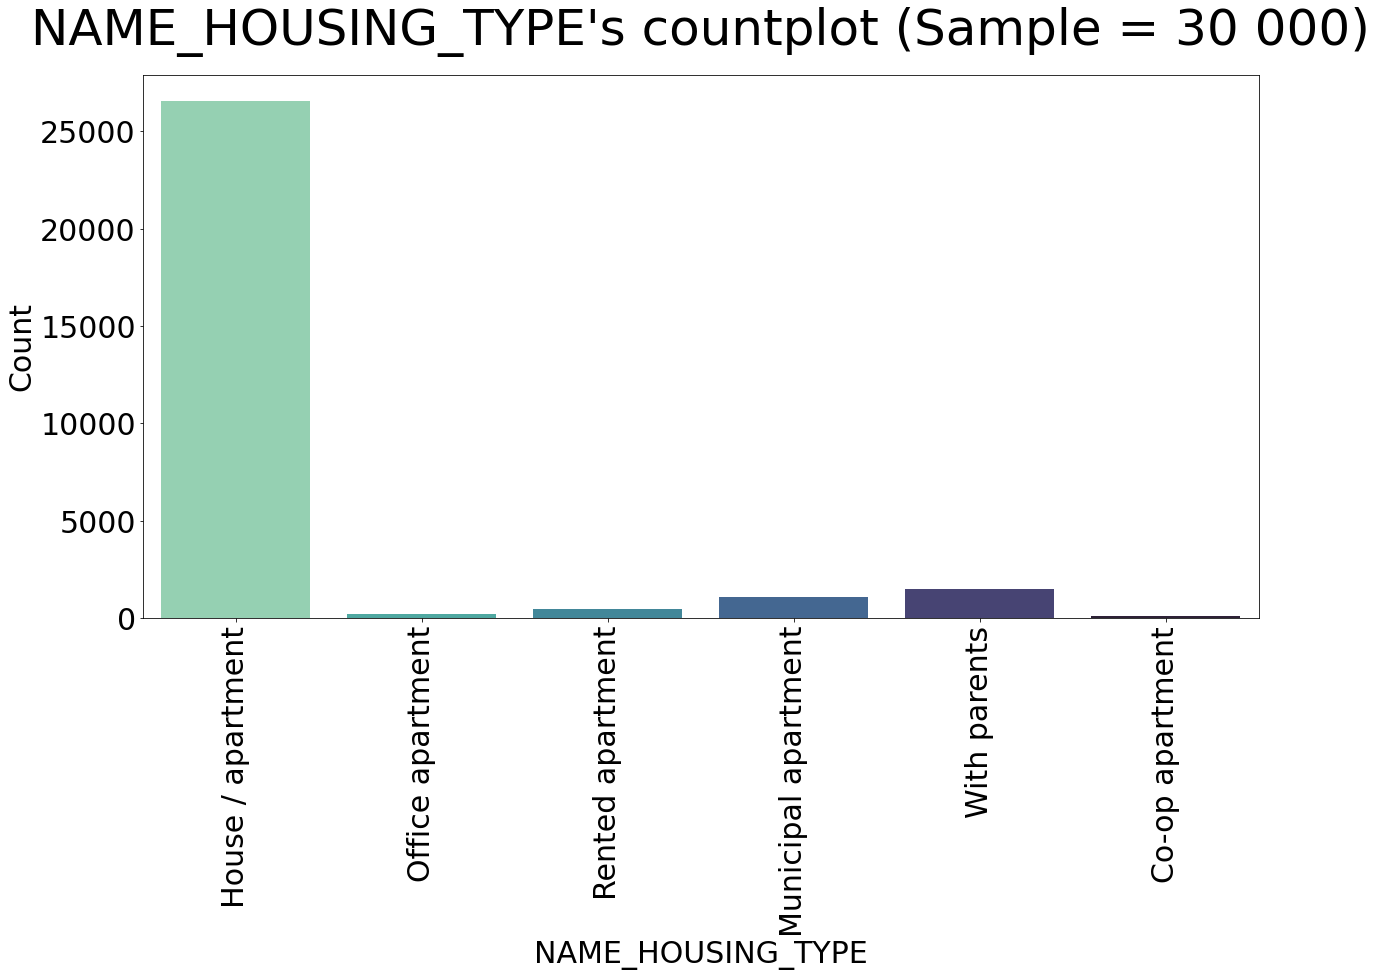

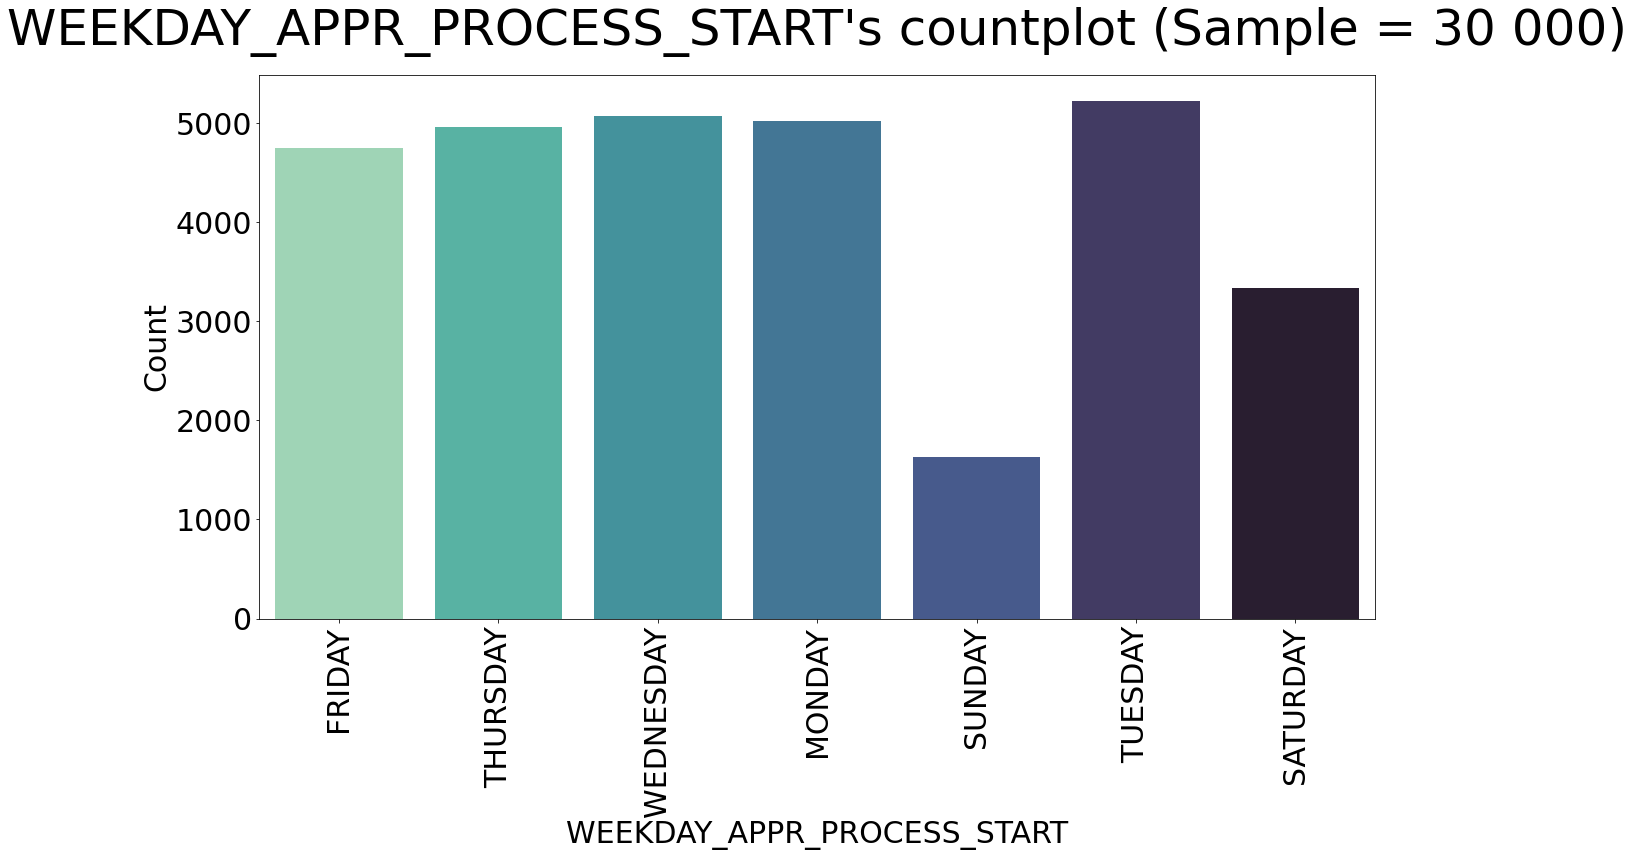

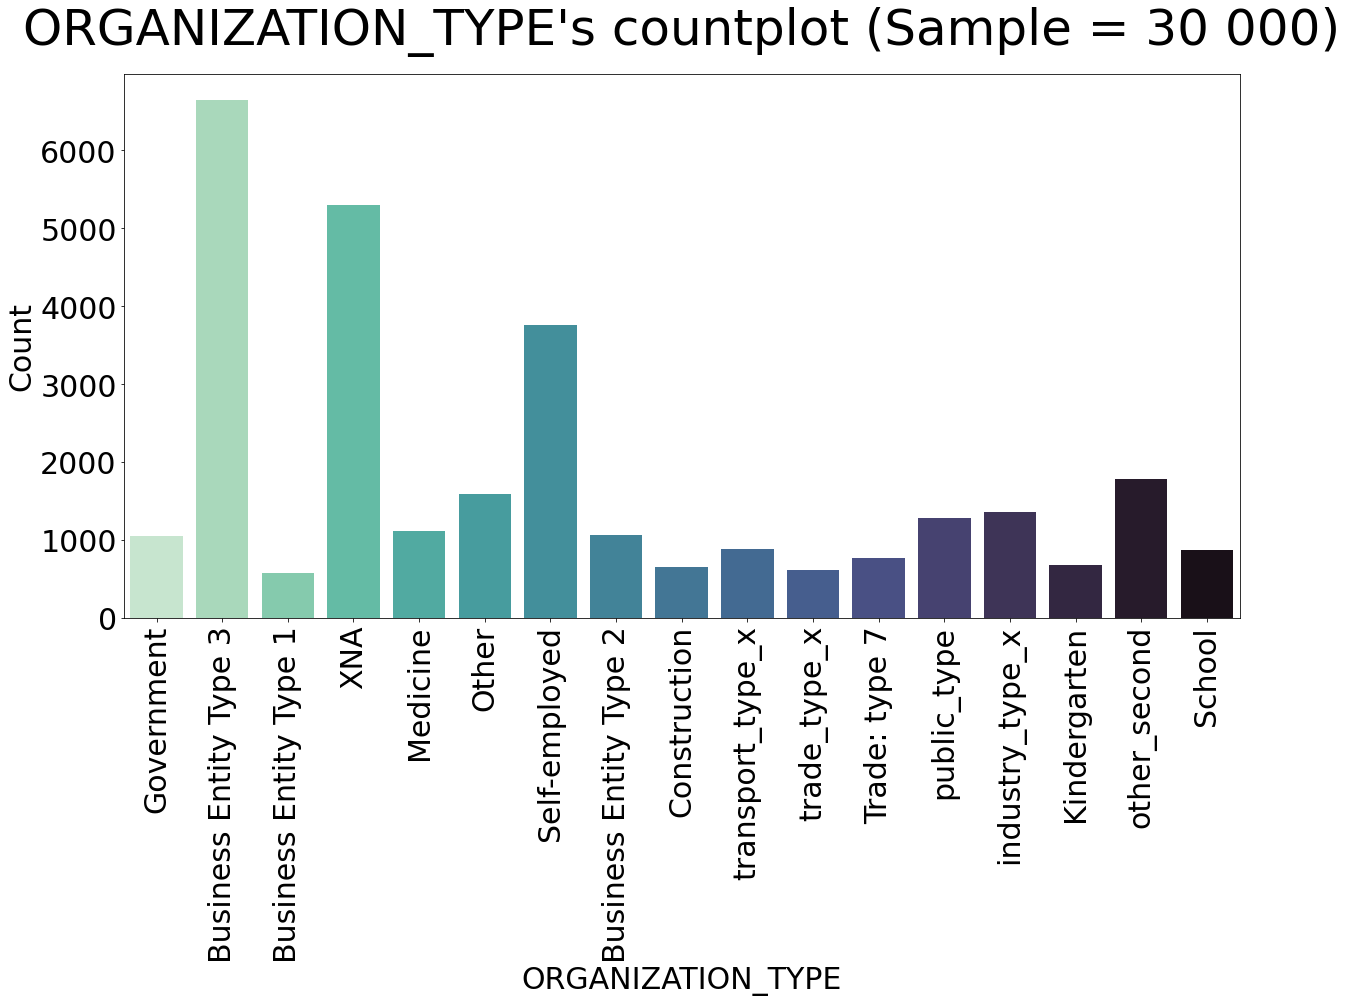

In [33]:
# Plots categorical features

for column_name in categorical_not_binary_columns:
    
    nuniques = application_train[column_name].nunique()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.countplot(data=application_train_untargeted.sample(30000),
                  x=column_name,
                  palette=sns.color_palette('mako_r', nuniques),
                  ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel(column_name, fontsize=text_size)
    ax.set_ylabel('Count', fontsize=text_size)

    plt.title('{}\'s countplot (Sample = 30 000)'.format(column_name),
              fontsize=title_size,
              pad=30)
        
    if nuniques >= 4:
        ax.tick_params(axis='x', rotation=90)
        
    plt.show();
        
plt.show();

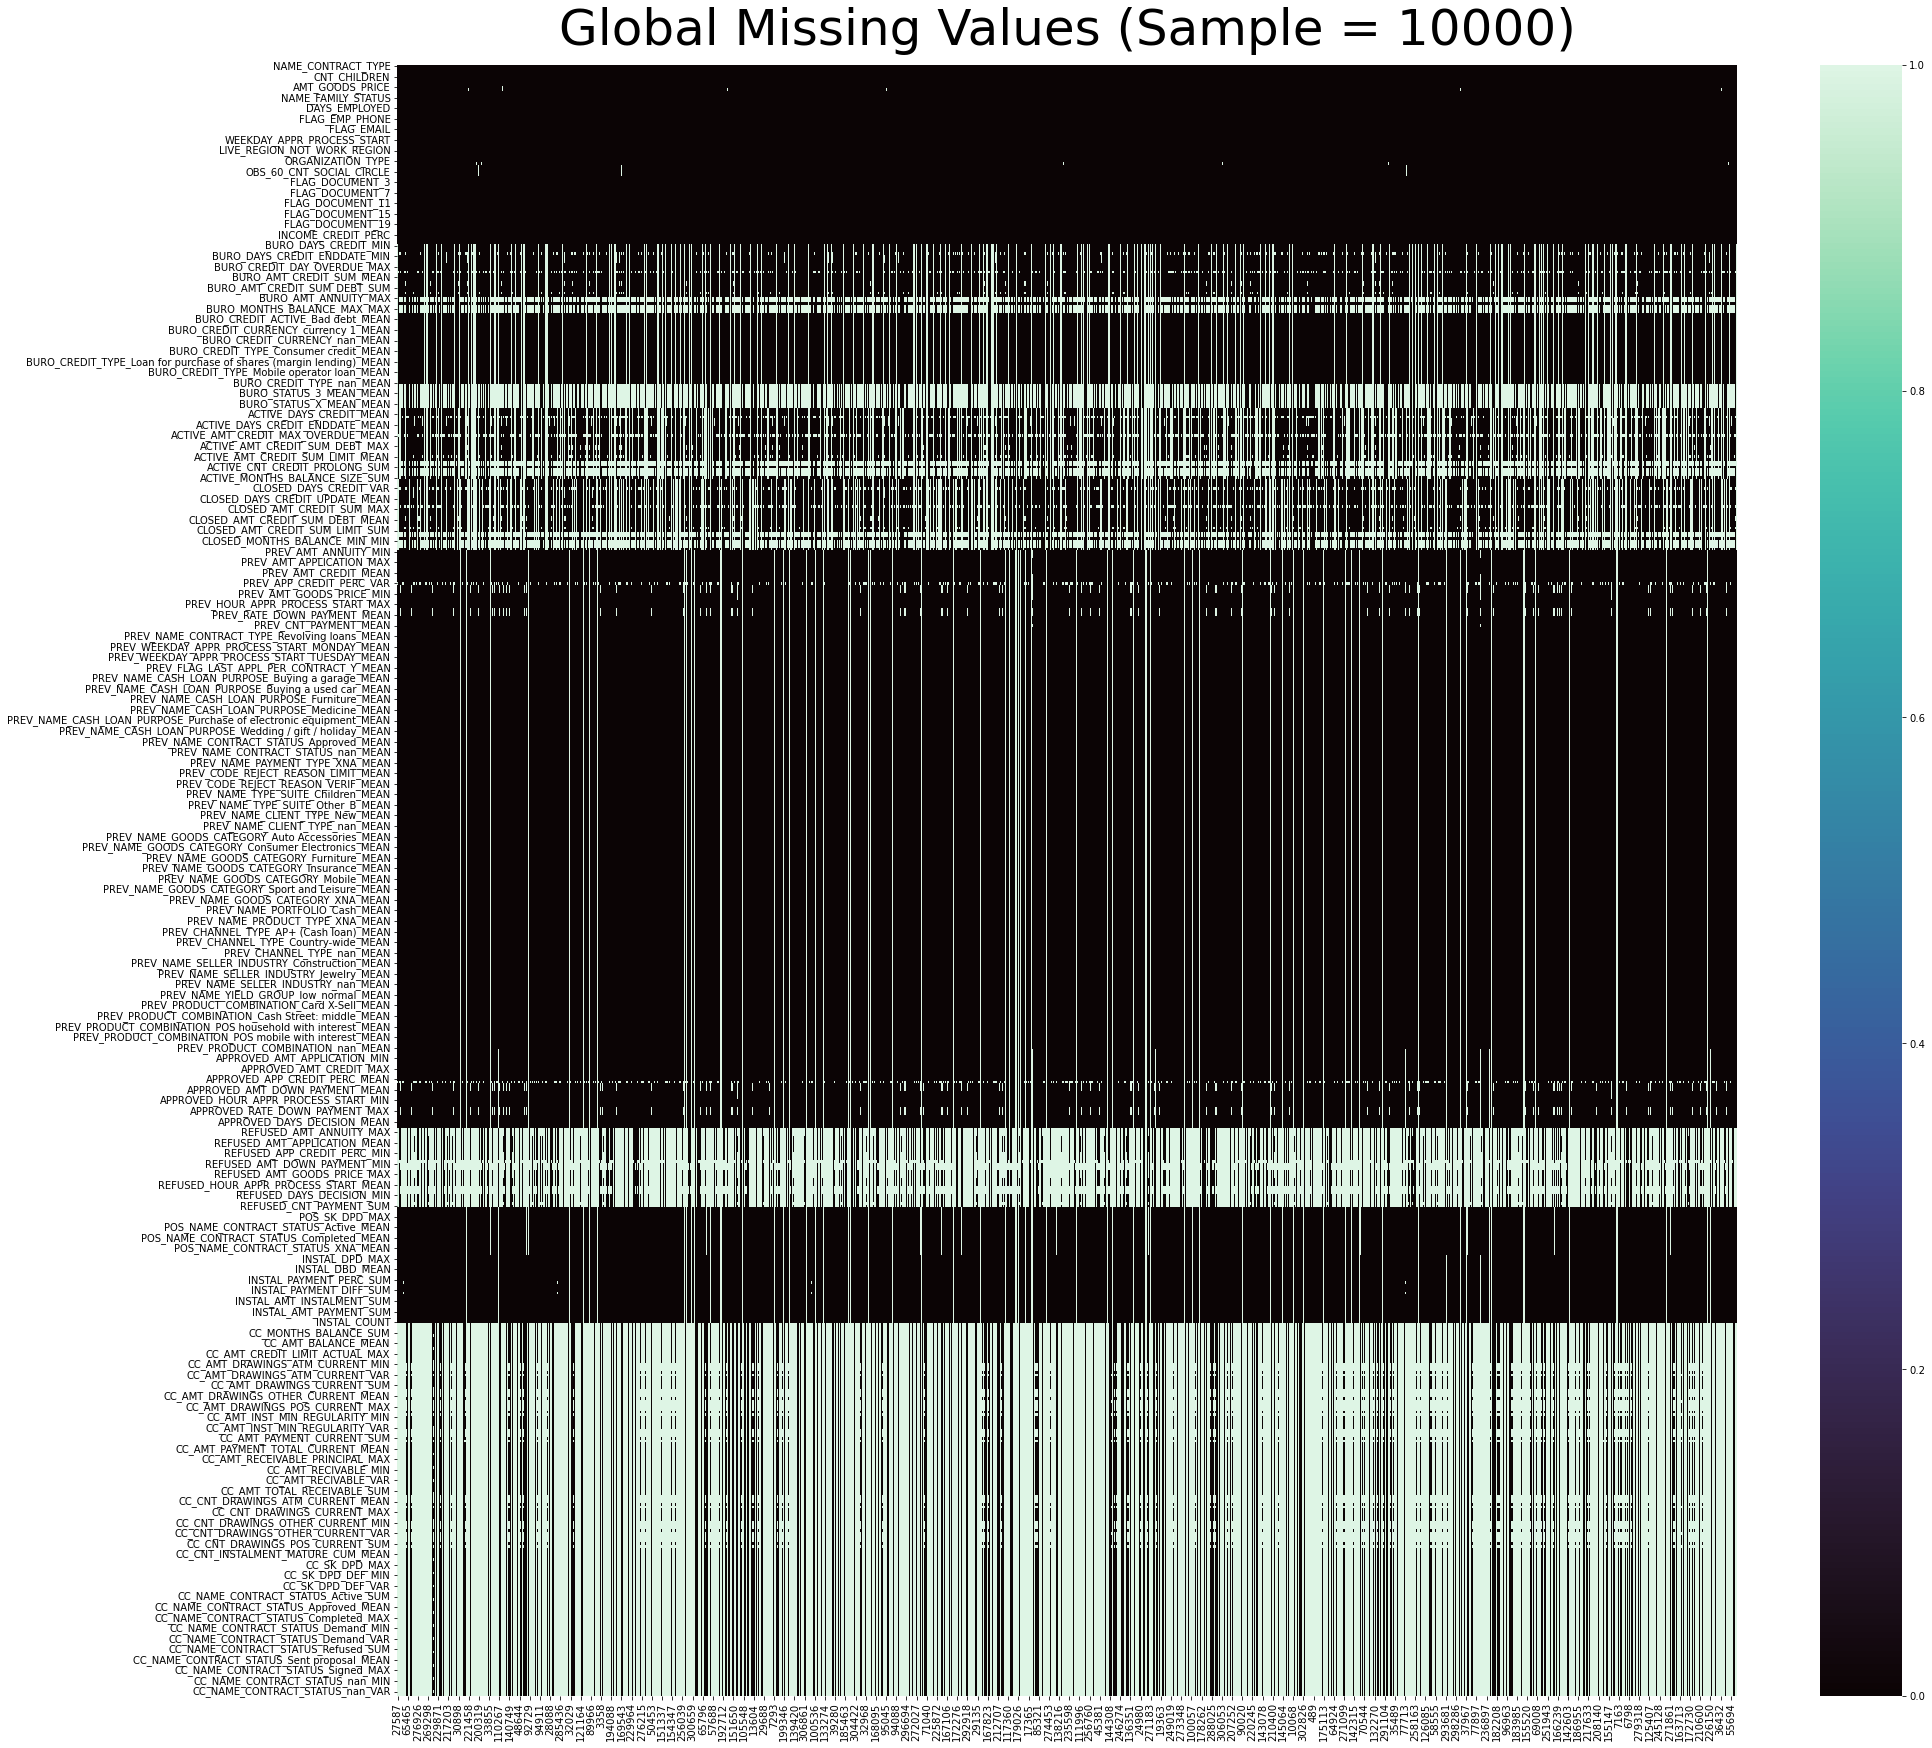

In [34]:
# Displays missing values

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data=application_train_untargeted.sample(10000).isna().transpose(),
            cmap=sns.color_palette('mako', as_cmap=True),
            ax=ax)

plt.title('Global Missing Values (Sample = 10000)', pad = 20, fontsize = 50)
plt.show();

<h6>Bivariate Analysis

In [35]:
# Imputes by the median the missing values of numerical non binary columns

application_train_untargeted_numerical_not_binary_columns_imputed = \
    numerical_pipeline\
        .fit_transform(application_train_untargeted[numerical_not_binary_columns])

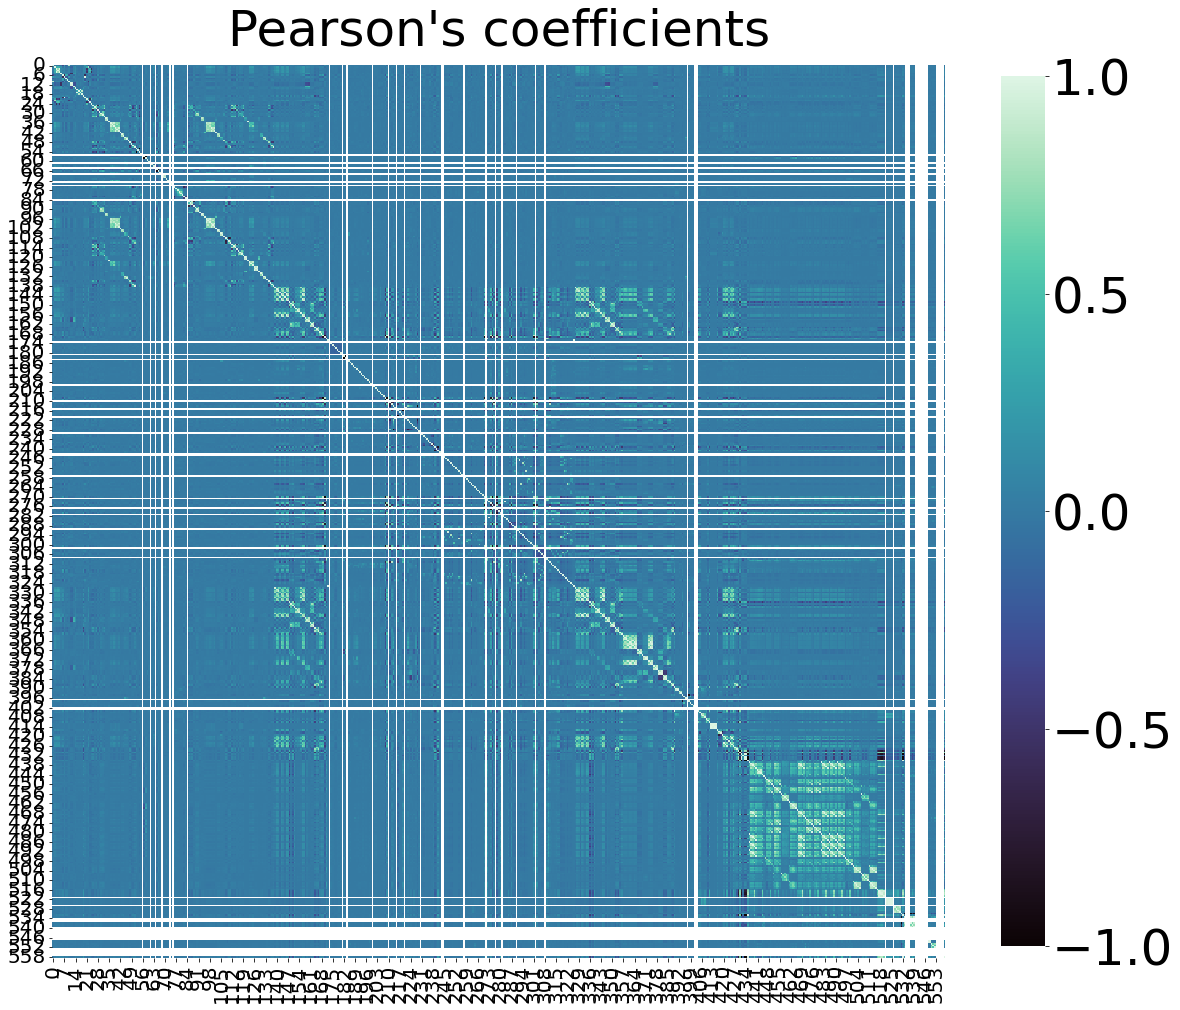

In [36]:
# Pearson\'s coefficients

# Blanck lines appear when a standard error is equal to zero

fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(
    data=pd.DataFrame(
            application_train_untargeted_numerical_not_binary_columns_imputed)\
            .sample(10000).corr(),
    square=True,
    cmap = sns.color_palette('mako', as_cmap=True),
    cbar_kws={'shrink': 0.8},
    ax = ax,
)

ax.tick_params(labelsize=20)
ax.tick_params(axis = 'x', rotation=90)
ax.tick_params(axis = 'y', rotation=0)
plt.title('Pearson\'s coefficients', pad = 20, fontsize = 50)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=50)

plt.show();

<h6>Multivariate Analysis

In [37]:
# Transforms 

transformed_application_train_for_dimentionality_reduction = \
    column_transformer\
        .fit_transform(application_train.iloc[:10000, 2:])

In [40]:
# Explores PCA explained variance

transformed_application_train_for_dimentionality_reduction_standardised = \
    StandardScaler().fit_transform(transformed_application_train_for_dimentionality_reduction)

pca_99_variance = \
    PCA(n_components=0.99, random_state=random_seed)\
     .fit(transformed_application_train_for_dimentionality_reduction_standardised)

pca_3_components = \
    PCA(n_components=3, random_state=random_seed)\
    .fit(transformed_application_train_for_dimentionality_reduction_standardised) 

In [41]:
# The first 367 principal components can explain 99 % of the total variance
# but such a dimentionality reduction technique won't be retained for interpretability
# purpose

len(pca_99_variance.explained_variance_ratio_)

# The first 3 components can explain around 12 % of the total variance

pca_3_components.explained_variance_ratio_.sum()*100

367

12.78870835753039

In [42]:
# Applies a Tsne on 2 components for visualization

t_sne = TSNE(n_components=2, perplexity=30, learning_rate=300, 
              init='random', random_state=random_seed)\
             .fit_transform(transformed_application_train_for_dimentionality_reduction)

In [44]:
t_sne_df = pd.DataFrame(t_sne)

t_sne_df['TARGET'] = application_train.iloc[:10000, 1]

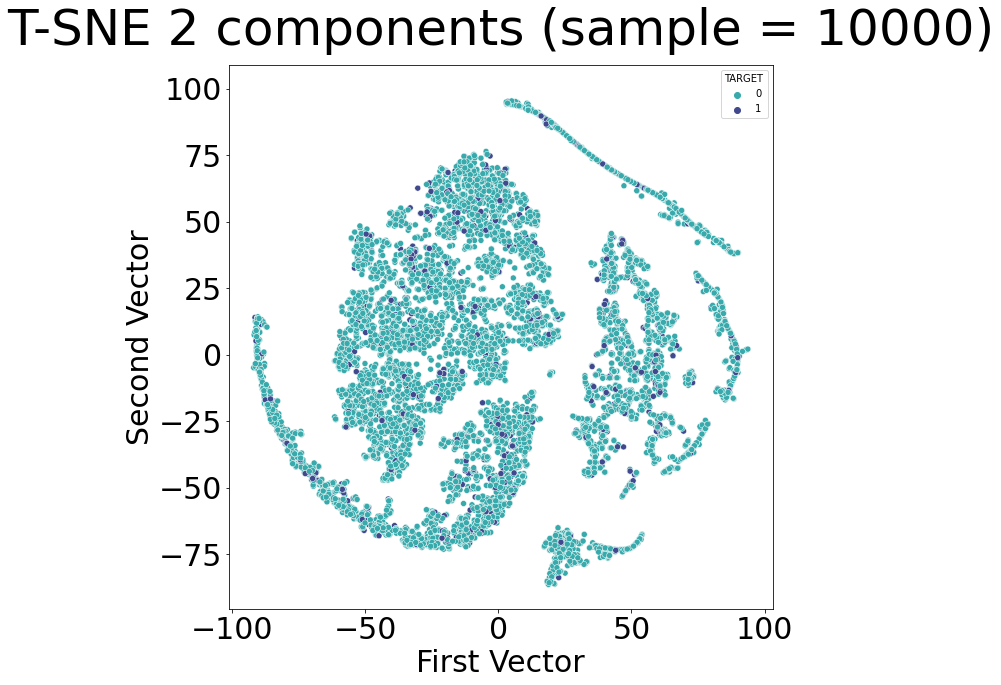

In [45]:
# Plots True labels Tsne

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=t_sne_df,
                x=0,
                y=1,
                palette = sns.color_palette('mako_r', 2),
                hue='TARGET')


ax.tick_params(labelsize=tick_size)
ax.set_xlabel('First Vector', fontsize=text_size)
ax.set_ylabel('Second Vector', fontsize=text_size)

plt.title('T-SNE 2 components (sample = 10000)',
          fontsize=title_size,
          pad=20)

plt.axis('square')
plt.show();

<h1>Export

In [ ]:
# Exports application_train

application_train.to_csv(r'E:\Data\Projet 7\Cleaned2\application_train_cleaned', index=False)